In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import statsmodels.api as sm
from scipy.signal import butter,filtfilt
from matplotlib import colors as mcolors
from sklearn.linear_model import LinearRegression
from random import sample
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
from tslearn.shapelets import LearningShapelets
from collections import Counter

#### This notebook offers a walk-through to show how the market dynamic label works and offers Visualization of results to tune the parameters for your dataset.

#### Methods and Visulization included
1. Band-pass filter
2. Deterministic trend(linear model)
3. Cross-validation of 2 with clustering
4. TSNE plot of 2 and 3
5. Length-constrained deterministic trend
6. Stock clustering 

In [2]:
def preprocess(data):
    data=data['Adj Close']
    data=data.reset_index()
    data=data.rename(columns={ 'Date': 'date'})
    data_dict={}
    tics=[tic for tic in data.columns][1:]
    for tic in tics:
        temp=data.loc[:,['date',tic]]
        temp.rename(columns={tic:'adjcp'},inplace=True)
        temp=temp.assign(pct_return=temp['adjcp'].pct_change().fillna(0))
        data_dict[tic]=temp
    return data_dict,tics
def apply_to_all(tics,dataset,function):
    for tic in tics:
        function(dataset[tic])
def plot_ori(data,name,titile_suffix=''):
    fig, ax = plt.subplots(1, 1, figsize=(20, 10),constrained_layout=True)
    if isinstance(data['date'][0],str):
        date=data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
    else:
        date=data['date']
    ax.plot(date, data['adjcp'])
    ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M'))
    ax.set_title(name+'_adjcp'+str(titile_suffix),fontsize=20)
    ax.grid(True)
def plot_pct(data,name):
    fig, ax = plt.subplots(1, 1, figsize=(20, 10),constrained_layout=True)
    if isinstance(data['date'][0],str):
        date=data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
    else:
        date=data['date']
    ax.plot(date, data['pct_return'])
    ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M'))
    ax.set_title(name+'pct_return',fontsize=20)
    ax.grid(True)
def plot_both(data,name):
    plot_ori(data,name)
    plot_pct(data,name)
def plot_filter(data,name,low=6, high=32, K=12):
    # see sm.tsa.filters.bkfilter for more detail, this method is not applied to the pipline for now
    filtered_data=sm.tsa.filters.bkfilter(data[['adjcp','pct_return']],low,high,K)
    if isinstance(data['date'][0],str):
        date=data['date'][K:-K].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
    else:
        date=data['date'][K:-K]
    fig, ax = plt.subplots(2, 1, figsize=(20, 10),constrained_layout=True)
    ax[0].plot(date,filtered_data['adjcp_cycle'],label='adjcp_cycle')
    ax[1].plot(date,filtered_data['pct_return_cycle'],label='pct_return_cycle')
    ax[0].xaxis.set_major_locator(mdates.YearLocator(base=1))
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M'))
    ax[1].xaxis.set_major_locator(mdates.YearLocator(base=1))
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M'))
    ax[0].set_title(name+'_adjcp_cycle',fontsize=20)
    ax[1].set_title(name+'_pct_return_cycle',fontsize=20)
    ax[0].grid(True)
    ax[1].grid(True)
def butter_lowpass_filter(data, Wn, order):
    # suppose the data is sample at 7Hz (7days / week) so fs=7 and fn=7/2, we would like to eliminate volatility on weekly scale, then we should have
    # Wn=1/(7/2)=2/7 
    b, a = butter(order, Wn, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y
def adjcp_apply_filter(data,Wn_adjcp,Wn_pct,order):
    data['adjcp_filtered']=butter_lowpass_filter(data['adjcp'], Wn_adjcp, order)
    data['pct_return_filtered']=butter_lowpass_filter(data['pct_return'], Wn_pct, order)
def plot_by_suffix(data,name,data_suffix,savefig):
    fig, ax = plt.subplots(2, 1, figsize=(20, 10),constrained_layout=True)
    if isinstance(data['date'][0],str):
        date=data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
    else:
        date=data['date']
    ax[0].plot(date, data['adjcp'+data_suffix])
    ax[0].xaxis.set_major_locator(mdates.YearLocator(base=1))
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M'))
    ax[0].set_title(name+'_adjcp'+data_suffix,fontsize=20)
    ax[1].plot(date, data['pct_return'+data_suffix])
    ax[1].xaxis.set_major_locator(mdates.YearLocator(base=1))
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M'))
    ax[1].set_title(name+'_pct_return'+data_suffix,fontsize=20)
    if savefig:
        fig.savefig('res/'+name+data_suffix+'.png')
def find_index_of_turning(data):
    turning_points=[0]
    data=data.reset_index(drop=True)
    for i in range(data['pct_return_filtered'].size-1):
        if data['pct_return_filtered'][i]*data['pct_return_filtered'][i+1]<0:
            turning_points.append(i+1)
    if turning_points[-1]!=data['pct_return_filtered'].size:
        turning_points.append(data['pct_return_filtered'].size)
    return turning_points
def linear_regession_turning_points(data_ori,tic,length_constrain=0):
    data=data_ori.reset_index(drop=True)
    turning_points=find_index_of_turning(data)
    turning_points_new=[turning_points[0]]
    if length_constrain!=0:
        for i in range(1,len(turning_points)-1):
            if turning_points[i]-turning_points_new[-1]>=length_constrain:
                turning_points_new.append(turning_points[i])
        turning_points_new.append(turning_points[-1])
        turning_points=turning_points_new
    coef_list=[]
    normalized_coef_list=[]
    y_pred_list=[]
    for i in range(len(turning_points)-1):
        x_seg=np.asarray([j for j in range(turning_points[i],turning_points[i+1])]).reshape(-1, 1)
#         print(x_seg,data['adjcp_filtered'].iloc[turning_points[i]:turning_points[i+1]])
        adj_cp_model = LinearRegression().fit(x_seg,data['adjcp_filtered'].iloc[turning_points[i]:turning_points[i+1]])
        y_pred = adj_cp_model.predict(x_seg)
        normalized_coef_list.append(100*adj_cp_model.coef_/data['adjcp_filtered'].iloc[turning_points[i]])
        coef_list.append(adj_cp_model.coef_)
        y_pred_list.append(y_pred)
    return np.asarray(coef_list),np.asarray(turning_points),y_pred_list,normalized_coef_list
def dynamic_flag(dynamic_num,coef,parameters):
    seg1,seg2,seg3=parameters
    if dynamic_num==4:
        if coef<=seg1:
            flag=0
        elif coef>seg1 and coef<=seg2:
            flag=1
        elif coef>seg2 and coef<=seg3:
            flag=2
        elif coef>seg3:
            flag=3
    elif dynamic_num==3:
        if coef<=seg1:
            flag=0
        elif coef>seg1 and coef<=seg3:
            flag=1
        elif coef>seg3:
            flag=2
    else:
        raise Exception('This dynamic num is currently not supported')
    return flag
def linear_regession_label(data,y_pred_list,turning_points,low,high,normalized_coef_list,cluster_metric,tic,dynamic_num=4):
    data=data.reset_index(drop=True)[cluster_metric]
    data_seg=[]
    seg1,seg2,seg3=sorted([low,high,0])
    label=[]
    label_seg=[]
    index_seg=[]
    for i in range(len(turning_points)-1):
        x_seg=np.asarray([j for j in range(turning_points[i],turning_points[i+1])]).reshape(-1, 1)
        coef=normalized_coef_list[i]
        flag=dynamic_flag(dynamic_num,coef,[seg1,seg2,seg3])
        label.extend([flag]*(turning_points[i+1]-turning_points[i]))
        if turning_points[i+1]-turning_points[i]>2:
            data_seg.append(data.iloc[turning_points[i]:turning_points[i+1]].to_list())
            label_seg.append(flag)
            index_seg.append(tic+'_'+str(i))
    return label,data_seg,label_seg,index_seg
def linear_regession_plot(data,tic,y_pred_list,turning_points,low,high,savefig,normalized_coef_list,dynamic_num=4):
    data=data.reset_index(drop=True)
    fig, ax = plt.subplots(3, 1, figsize=(20, 10),constrained_layout=True)
    ax[0].plot([i for i in range(data.shape[0])], data['adjcp_filtered'])
    seg1,seg2,seg3=sorted([low,high,0])
    colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())
    for i in range(len(turning_points)-1):
        x_seg=np.asarray([j for j in range(turning_points[i],turning_points[i+1])]).reshape(-1, 1)
        y_pred = y_pred_list[i]
        coef=normalized_coef_list[i]
        flag=dynamic_flag(dynamic_num,coef,[seg1,seg2,seg3])
        ax[1].plot(x_seg,y_pred,color=colors[flag], label='cat'+str(flag))
        ax[2].plot(x_seg,data['adjcp'].iloc[turning_points[i]:turning_points[i+1]],color=colors[flag], label='cat'+str(flag))
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    ax[0].set_title(tic+'_linear_regression_dynamic',fontsize=20)
    if savefig:
        fig.savefig('res/linear_model/'+tic+'.png')
def linear_regession_timewindow(data_ori,tic,adjcp_timewindow):
    data=data_ori.iloc[:adjcp_timewindow*(data_ori['adjcp_filtered'].size//adjcp_timewindow),:]
    adjcp_window_data=[data[['adjcp_filtered']][i*adjcp_timewindow:(i+1)*adjcp_timewindow].to_numpy().reshape(-1) for i in range(data['adjcp_filtered'].size//adjcp_timewindow)]
    coef_list=[]
    fig, ax = plt.subplots(2, 1, figsize=(20, 10),constrained_layout=True)
    ax[0].plot([i for i in range(data.shape[0])], data['adjcp_filtered'])
    for i,data_seg in enumerate(adjcp_window_data):
        x_seg=np.asarray([i*adjcp_timewindow+j for j in range(adjcp_timewindow)]).reshape(-1, 1)
        adj_cp_model = LinearRegression().fit(x_seg,data_seg)
        y_pred = adj_cp_model.predict(x_seg)
        ax[1].plot([i*adjcp_timewindow+j for j in range(adjcp_timewindow)],y_pred)
        coef_list.append(adj_cp_model.coef_)
    return coef_list
def validation_plot(data,tic,cluster_metic,turning_point,savefig,seg_list,label_list,color_list):
    data_cluster=data.reset_index(drop=True)[cluster_metic]
    data_ori=data.reset_index(drop=True)['adjcp']
    data_filtered=data.reset_index(drop=True)['adjcp_filtered']
    fig, ax = plt.subplots(3, 1, figsize=(20, 10),constrained_layout=True)
    colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())
    for i in range(len(turning_points)-1):
        x_seg=np.asarray([j for j in range(turning_points[i],turning_points[i+1])]).reshape(-1, 1)
        y=data_cluster.iloc[turning_points[i]:turning_points[i+1]]
        y_1=data_ori.iloc[turning_points[i]:turning_points[i+1]]
        y_2=data_filtered.iloc[turning_points[i]:turning_points[i+1]]
        if turning_points[i+1]-turning_points[i]<=1 or tic+'_'+str(i) not in seg_list :
            continue
        flag=label_list[seg_list.index(tic+'_'+str(i))]
        if color_list[flag]:
            c=color_list[flag]
        else:
            c=flag+len(color_list)
        ax[0].plot(x_seg,y,color=colors[c], label='cluster'+str(flag))
        ax[1].plot(x_seg,y_1,color=colors[c], label='cluster'+str(flag))
        ax[2].plot(x_seg,y_2,color=colors[c], label='cluster'+str(flag))
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    ax[0].set_title(tic+'_linear_regression_crossvalidation',fontsize=20)
    if savefig:
        fig.savefig('res/linear_model/'+tic+'_cross_validation.png')

# Data download and preprocessing

In [3]:
ticks=' '.join(list(pd.read_csv('../data/dj30/dj30.csv')['tic'].unique()))

In [4]:
nasdaq=yf.download (tickers = ticks, start = "2012-01-01",
                              end = "2022-01-01", interval = "1d").dropna(axis=1)

[*********************100%***********************]  29 of 29 completed


In [5]:
data_dict,tics=preprocess(nasdaq)

# Data descrption and Basic manipulation

In [ ]:
for i,tic in enumerate(tics):
    plot_both(data_dict[tic],tic)
    if i>0:
        break

# band-pass filter

In [45]:
for tic in tics:
    #It is strongly recommended to adjust the Wn based on different data. 
    #You can refer to https://en.wikipedia.org/wiki/Butterworth_filter for parameter setting 
    adjcp_apply_filter(data_dict[tic],Wn_adjcp=2/7,Wn_pct=2/14,order = 4)

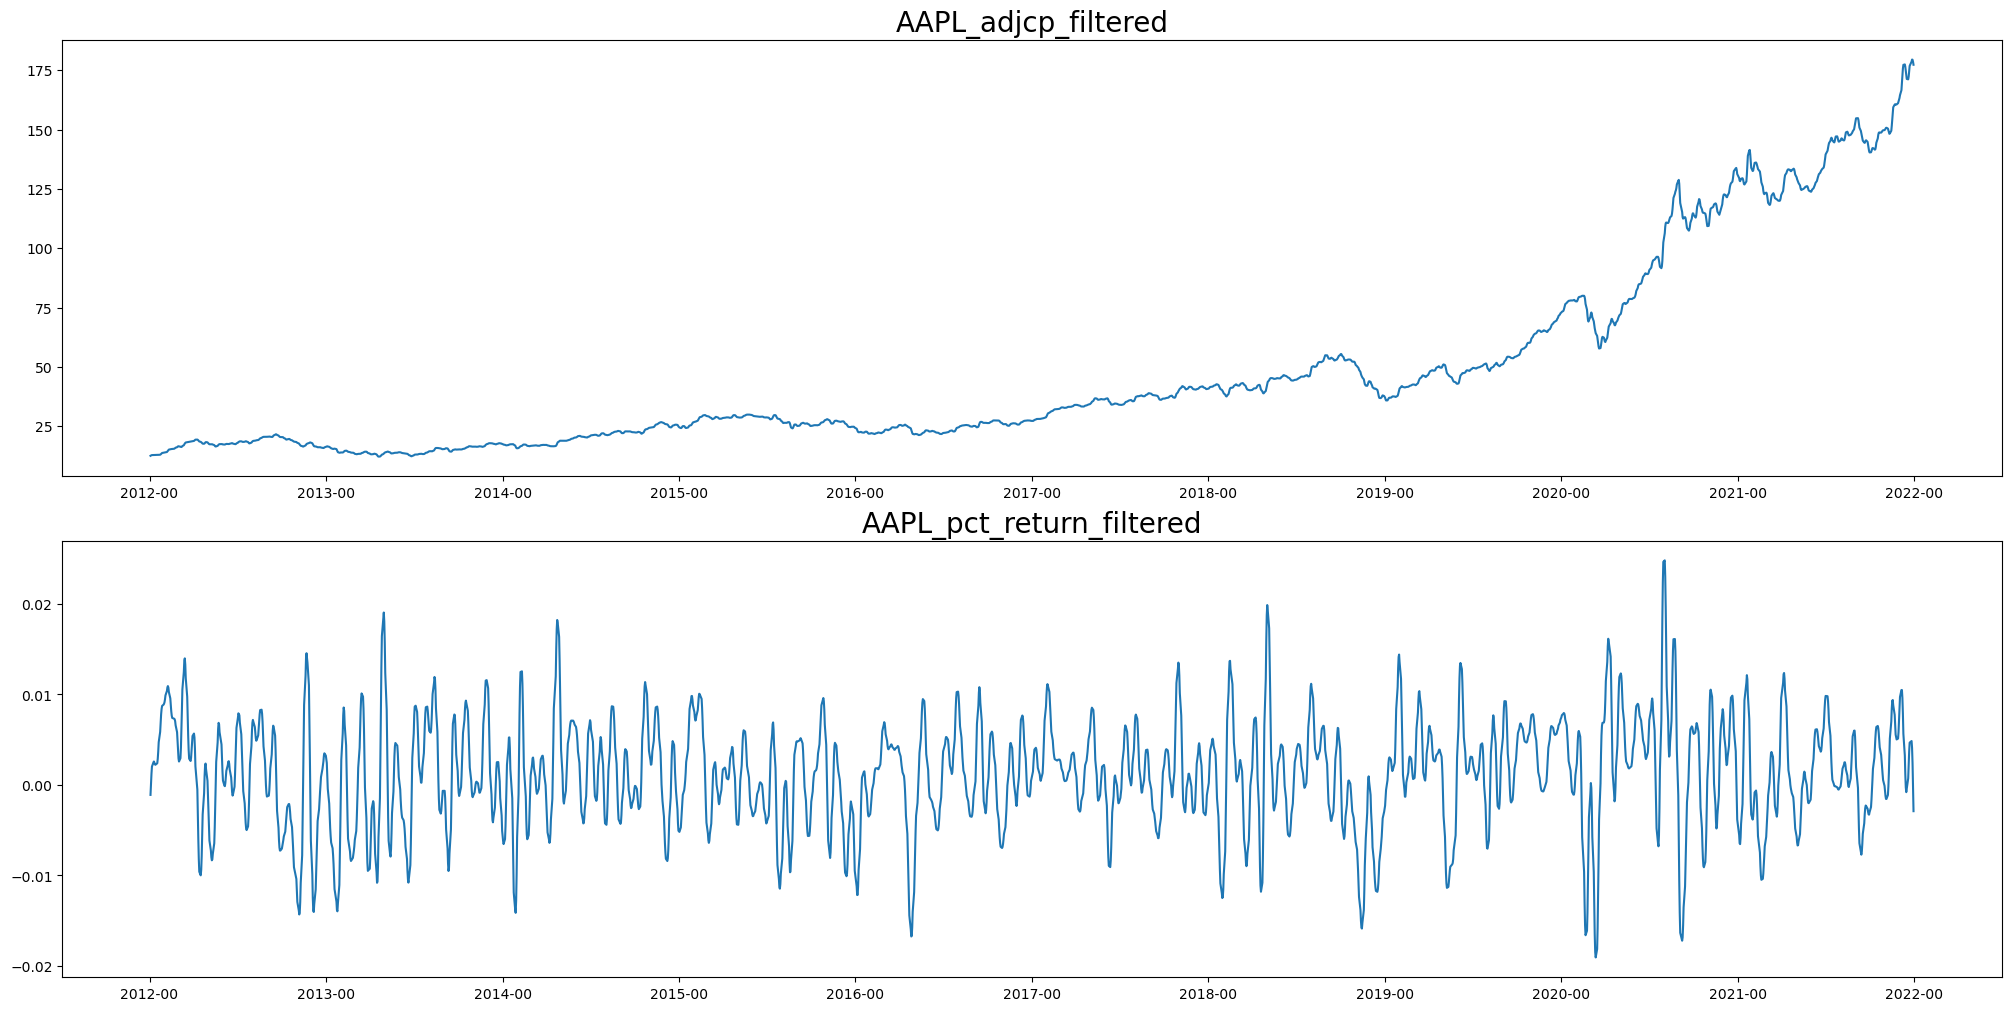

In [46]:
for i,tic in enumerate(tics):
    #It is strongly recommended to adjust the Wn based on different data. 
    #You can refer to https://en.wikipedia.org/wiki/Butterworth_filter for parameter setting 
    adjcp_apply_filter(data_dict[tic],Wn_adjcp=2/7,Wn_pct=2/14,order = 4)
    if i<1:
        plot_by_suffix(data_dict[tic],tic,'_filtered',savefig=False)
        plt.show()

# Min_Max normalization

In [51]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    norm_data = numerator / (denominator + 1e-7)
    return norm_data

In [52]:
for tic in tics:
    data_dict[tic]['adjcp_filtered_normalized']=MinMaxScaler(data_dict[tic]['adjcp_filtered'])
    data_dict[tic]['pct_return_filtered_normalized']=MinMaxScaler(data_dict[tic]['pct_return_filtered'])

In [ ]:
for tic in tics:
    plot_by_suffix(data_dict[tic],tic,'_filtered_normalized',savefig=False)
    plt.show()

# Deterministic Trends(linear model)

In [15]:
turning_points_dict={}
coef_list_dict={}
norm_coef_list_dict={}
y_pred_dict={}
for i,tic in enumerate(tics):
    coef_list,turning_points,y_pred_list,norm_coef_list=linear_regession_turning_points(data_ori=data_dict[tic],tic=tic)
    turning_points_dict[tic]=turning_points
    coef_list_dict[tic]=coef_list
    y_pred_dict[tic]=y_pred_list
    norm_coef_list_dict[tic]=norm_coef_list

In [16]:
all_coef_list=np.vstack([array for array in norm_coef_list_dict.values()])

In [ ]:
coef_stats=pd.DataFrame(all_coef_list).describe()
display(coef_stats)
percent_25=coef_stats.loc['25%',0]
percent_75=coef_stats.loc['75%',0]

The low and high threshold for dynamic classification is adjustable.A value of -0.5 and 0.5 stand for -0.5% and 0.5% change per step.

In [19]:
def run_linear_model(metric,tics,turning_points_dict,coef_list_dict,y_pred_dict,norm_coef_list_dict,plot,savefig,dynamic_num=4,low=-0.5,high=0.5):
    all_data_seg=[]
    all_label_seg=[]
    all_index_seg=[]
    for i,tic in enumerate(tics):
        turning_points=turning_points_dict[tic]
        coef_list=coef_list_dict[tic]
        y_pred_list=y_pred_dict[tic]
        norm_coef_list=norm_coef_list_dict[tic]
        label,data_seg,label_seg,index_seg=linear_regession_label(data_dict[tic],y_pred_list,turning_points,low,high,norm_coef_list,metric,tic,dynamic_num)
    #     display(data_seg[0])
        all_data_seg.extend(data_seg)
        all_label_seg.extend(label_seg)
        all_index_seg.extend(index_seg)
        data_dict[tic]['label']=label
        if plot and plot>i:
            linear_regession_plot(data_dict[tic],tic,y_pred_list,turning_points,low,high,savefig=savefig,normalized_coef_list=norm_coef_list,dynamic_num=3)
    return all_data_seg,all_label_seg,all_index_seg

### The following sets of plots are (raw data, deterministic trend with dynamics labeled, raw data with dynamics labeled) of each stock

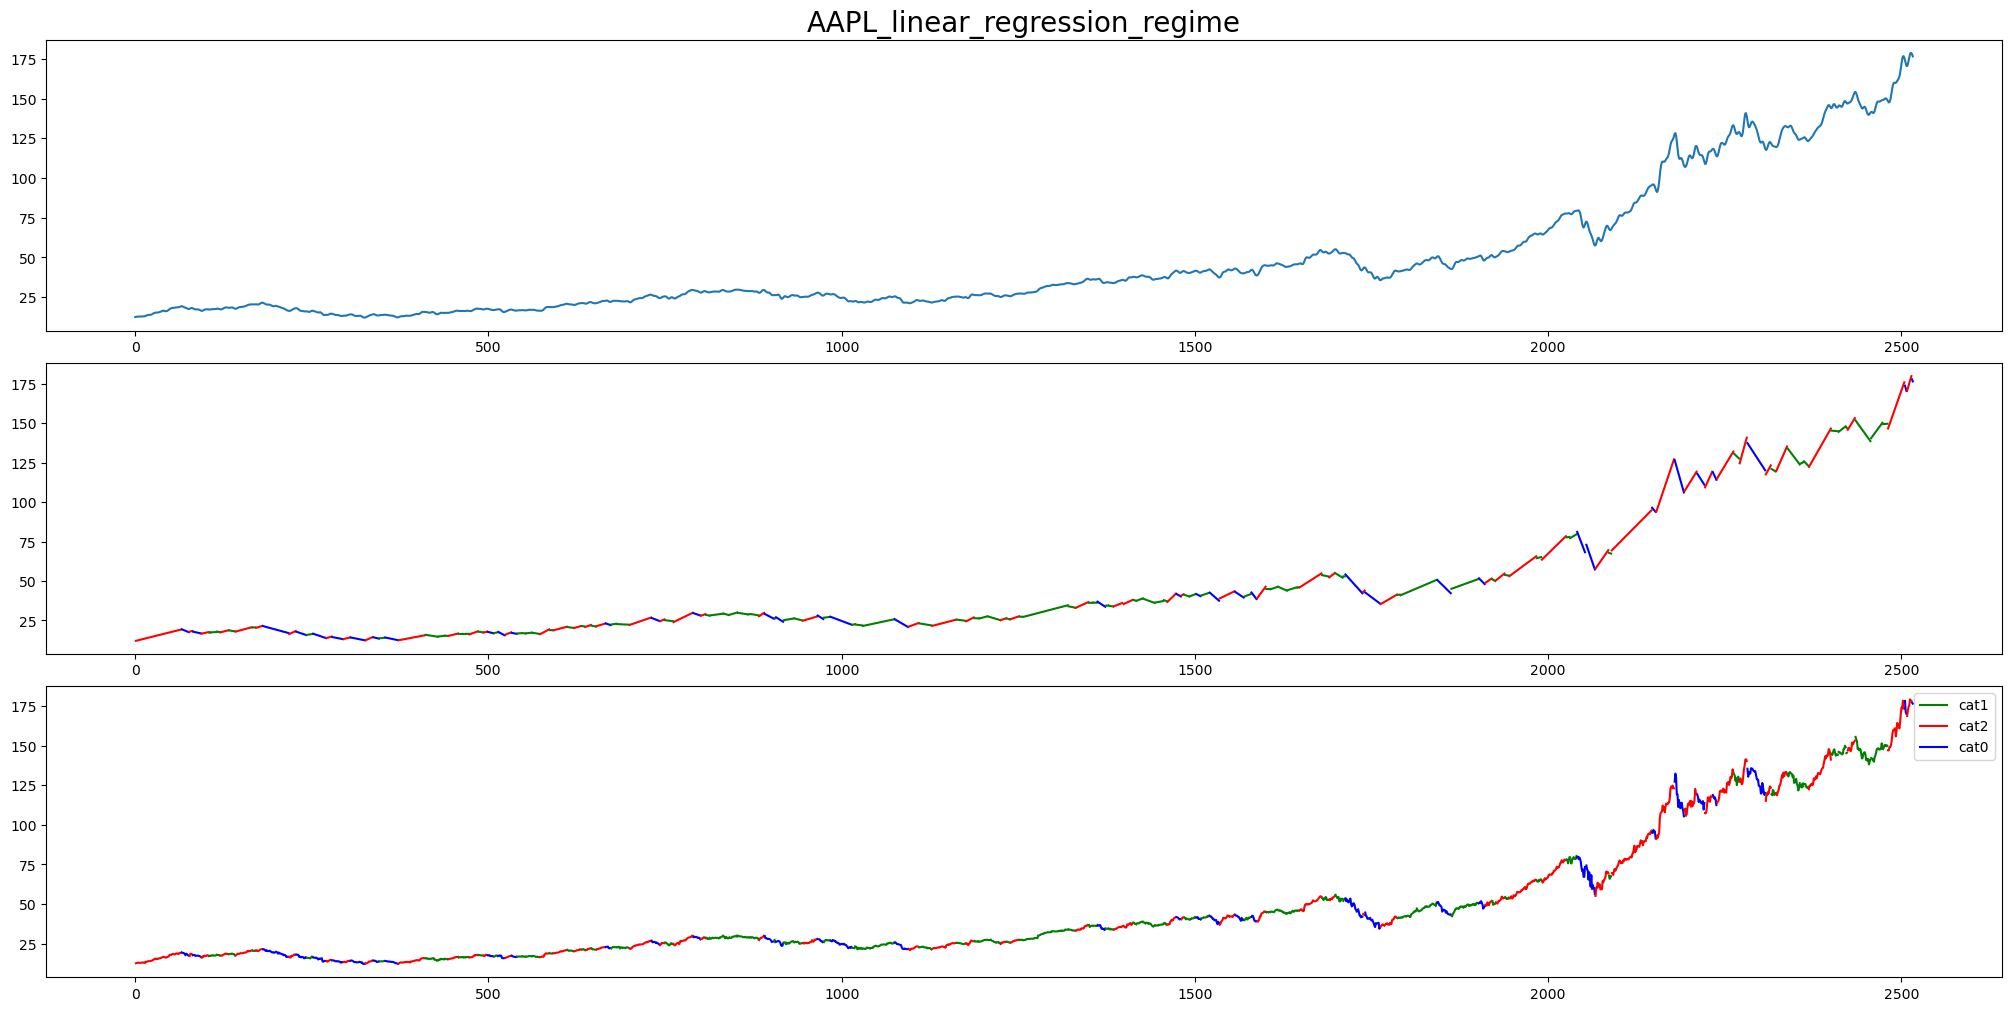

In [20]:
adjcp_data_seg,all_label_seg,all_index_seg=run_linear_model('adjcp_filtered_normalized',tics,turning_points_dict,coef_list_dict,y_pred_dict,norm_coef_list_dict,1,False)
pct_return_normalized_data_seg,all_label_seg,all_index_seg=run_linear_model('pct_return_filtered_normalized',tics,turning_points_dict,coef_list_dict,y_pred_dict,norm_coef_list_dict,False,False)
pct_return_data_seg,all_label_seg,all_index_seg=run_linear_model('pct_return_filtered',tics,turning_points_dict,coef_list_dict,y_pred_dict,norm_coef_list_dict,False,False)

#  Cross validation

We use multiple cluster methods to cross validate how our deterministic trend method

In [24]:
def cross_validate(label,model,number):
    c_list=[Counter() for _ in range(4)]
    c=Counter()
    for i in range(len(all_label_seg)):
        c_list[all_label_seg[i]][label[i]]+=1
        c[label[i]]+=1
    cluster_num_counter=Counter(label)
    color_list=[None for _ in range(model.n_clusters)]
    display(c,c_list)
    for i,c in enumerate(c_list):
        l,count=c.most_common(1)[0]
        color_list[l]=i
        total=c.total()
        percent=count/total
        print('The major cluster of dynamic '+str(i)+' is '+str(l)+'. '+str(round(percent,2))+' of this dynamic is in this cluster. '
             +str(round(count/cluster_num_counter[l],2))+' of this laebl is in this dynamic')
#     color_list=[i for i in range(model.n_clusters)]
    for i,tic in enumerate(tics):
        turning_points=turning_points_dict[tic]
        coef_list=coef_list_dict[tic]
        y_pred_list=y_pred_dict[tic]
        norm_coef_list=norm_coef_list_dict[tic]
#         linear_regession_plot(data_dict[tic],tic,y_pred_list,turning_points,-0.5,0.5,savefig=False,normalized_coef_list=norm_coef_list)
        if number>i:
            validation_plot(data_dict[tic],tic,'pct_return_filtered',turning_points,False,all_index_seg,label,color_list)

## dwt cluster

In [ ]:
fitting_data=to_time_series_dataset(pct_return_data_seg)
km=TimeSeriesKMeans(n_clusters=6, metric="dtw", max_iter=50,max_iter_barycenter=100,n_jobs=50,verbose=1).fit(fitting_data)

In [ ]:
label=km.predict(fitting_data)

Counter({1: 1158, 0: 1771, 2: 2362, 5: 155, 3: 101, 4: 8})

[Counter({0: 690, 5: 154, 2: 92, 4: 8}),
 Counter({2: 687, 0: 1071, 5: 1}),
 Counter({2: 1393, 1: 411, 0: 9}),
 Counter({1: 747, 2: 190, 3: 101, 0: 1})]

The major cluster of dynamic 0 is 0. 0.73 of this dynamic is in this cluster. 0.39 of this laebl is in this dynamic
The major cluster of dynamic 1 is 0. 0.61 of this dynamic is in this cluster. 0.6 of this laebl is in this dynamic
The major cluster of dynamic 2 is 2. 0.77 of this dynamic is in this cluster. 0.59 of this laebl is in this dynamic
The major cluster of dynamic 3 is 1. 0.72 of this dynamic is in this cluster. 0.65 of this laebl is in this dynamic


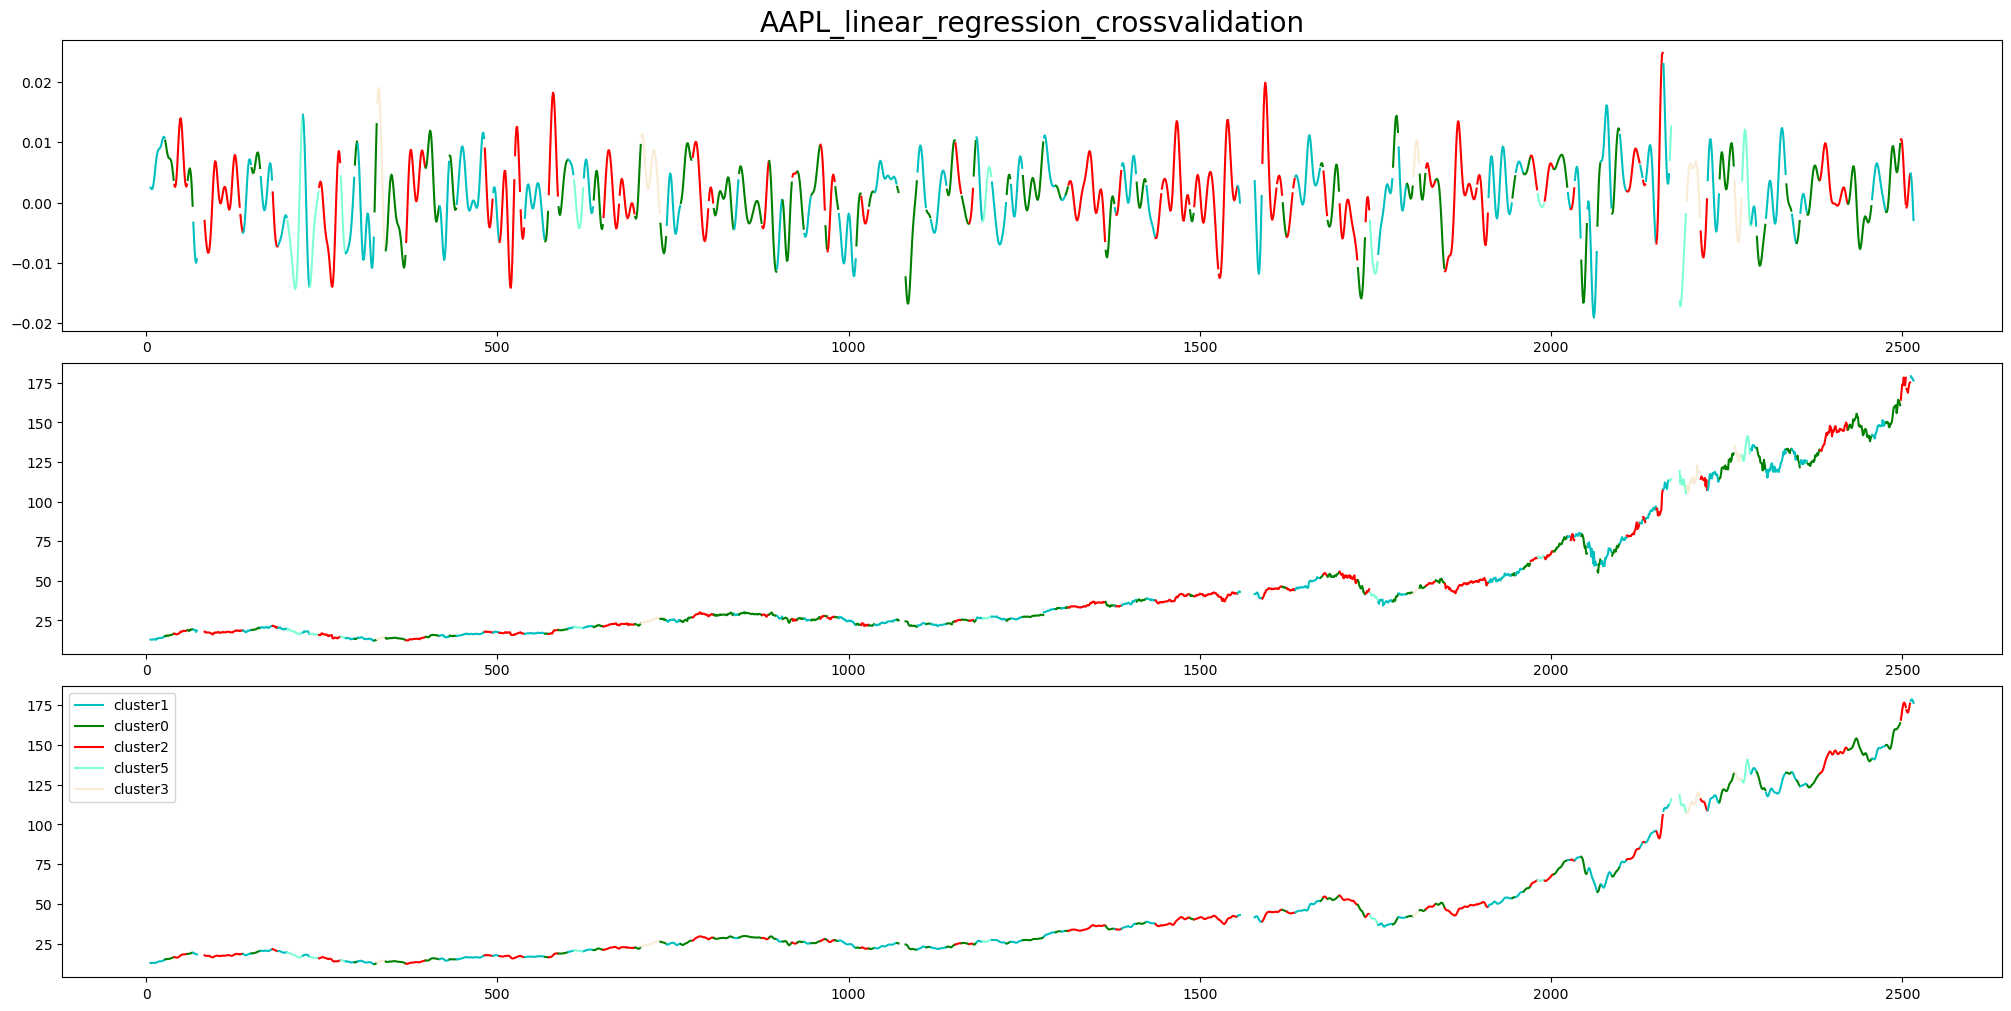

In [33]:
cross_validate(label,km,1)

## KNN

KNN is less convincing in this example, but you can try it on your dataset 

In [ ]:
from tslearn.clustering import KernelKMeans
gak_km = KernelKMeans(n_clusters=6, kernel="gak",verbose=2,n_jobs=50)
labels_gak = gak_km.fit_predict(fitting_data)

In [ ]:
cross_validate(labels_gak,gak_km,1)

# T-SNE

We regard each time-serie as an vector of a single dim and stack all vetors as multiple dims

In [64]:
from sklearn.manifold import TSNE

Interpolate the normalizaed adjcp/pct_return

In [149]:
def interpolation(data):
    max_len=max([len(d) for d in data])
    for i,d in enumerate(data):
        l=len(d)
        to_fill=max_len-l
        if to_fill!=0:
            interval=max_len//to_fill
            for j in range(to_fill):
                idx=(interval+1)*j+interval
                data[i].insert(min(idx,len(data[i])-1),float('nan'))
        data[i]=pd.Series(data[i]).interpolate(method='polynomial', order=2)
    return data

In [150]:
interpolated_pct_return_data_seg=np.array(interpolation(pct_return_data_seg))

In [ ]:
tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter = 300)
tsne_results = tsne.fit_transform(interpolated_pct_return_data_seg)

In [172]:
def TSNE_plot(data,label_list):
    colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())
    fig, ax = plt.subplots(1, 1, figsize=(20, 10),constrained_layout=True)
    for i in range(len(data)-1):
        label=label_list[i]
        ax.scatter(data[i][0],data[i][1],color=colors[label], alpha = 0.2,label='cluster'+str(label))
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.title('TSNE',fontsize=20)

TSNE of linear model

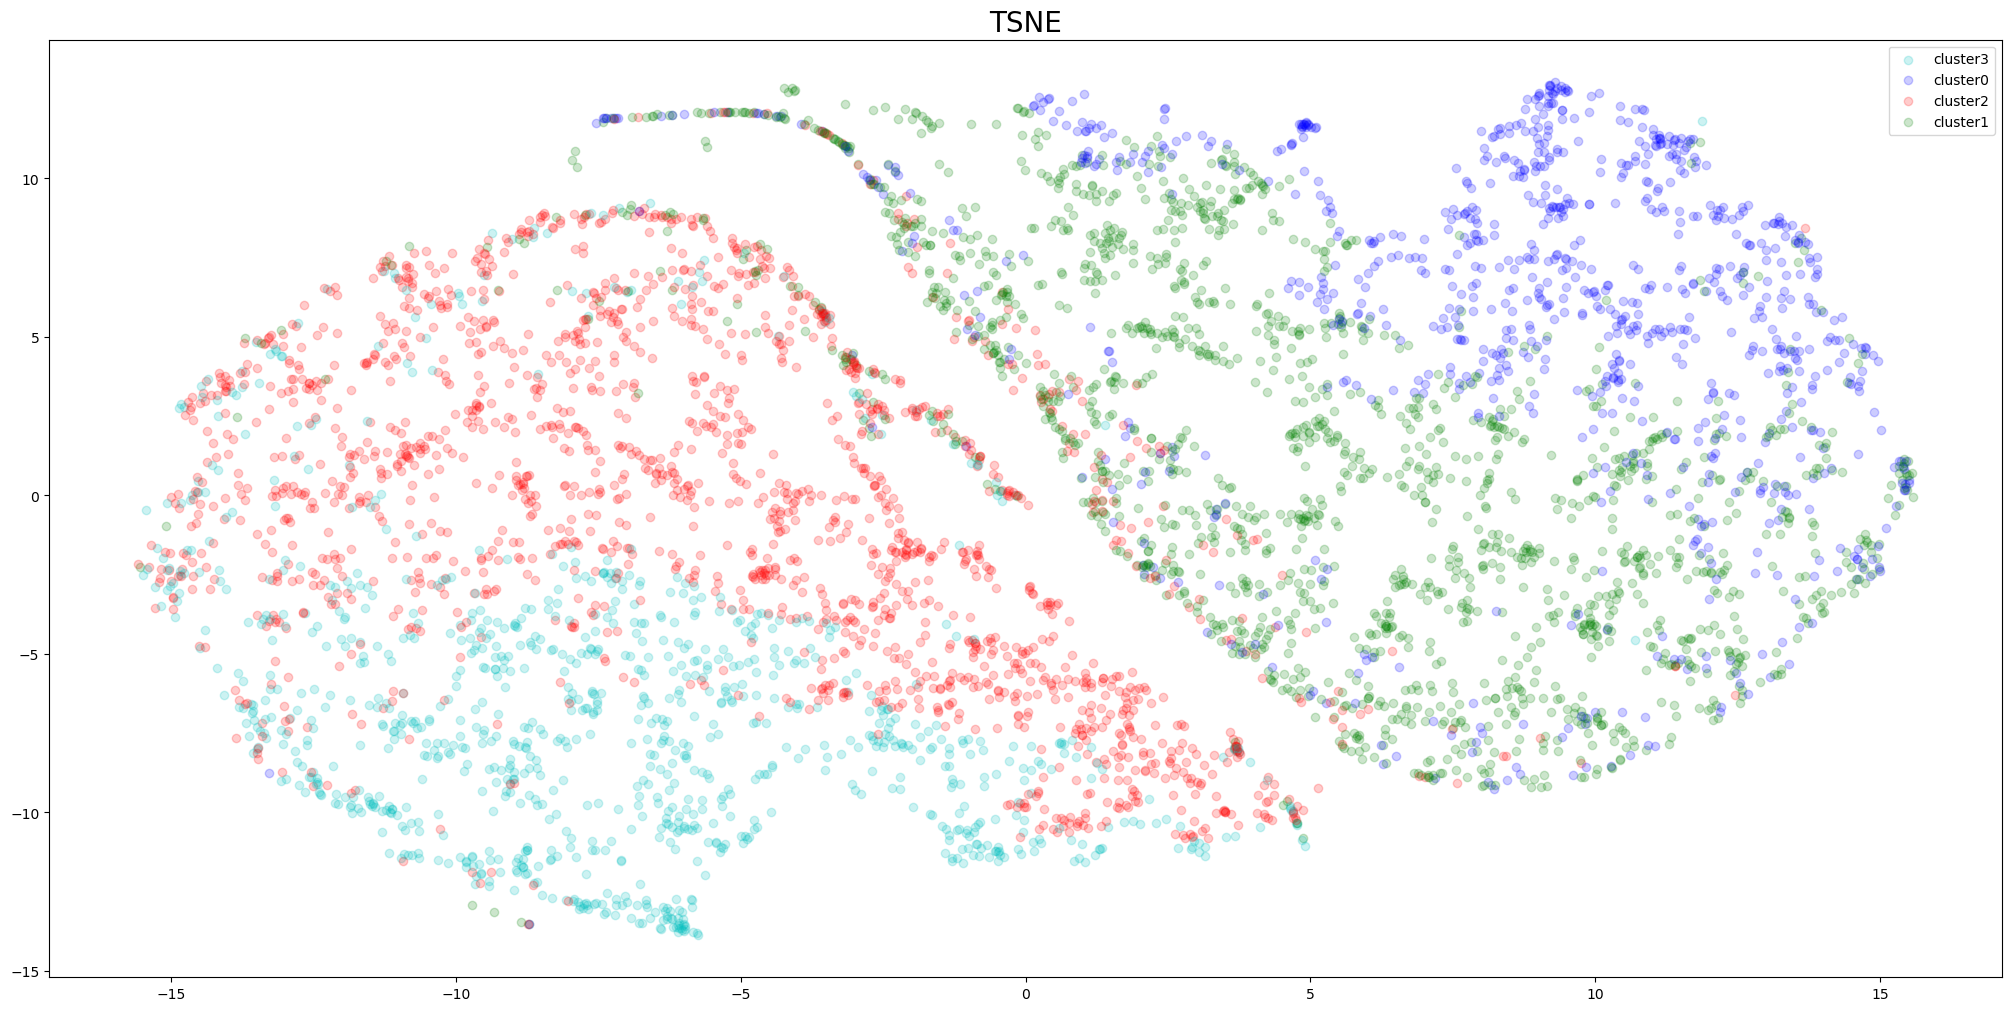

In [173]:
TSNE_plot(tsne_results,all_label_seg)

TSNE of DWT

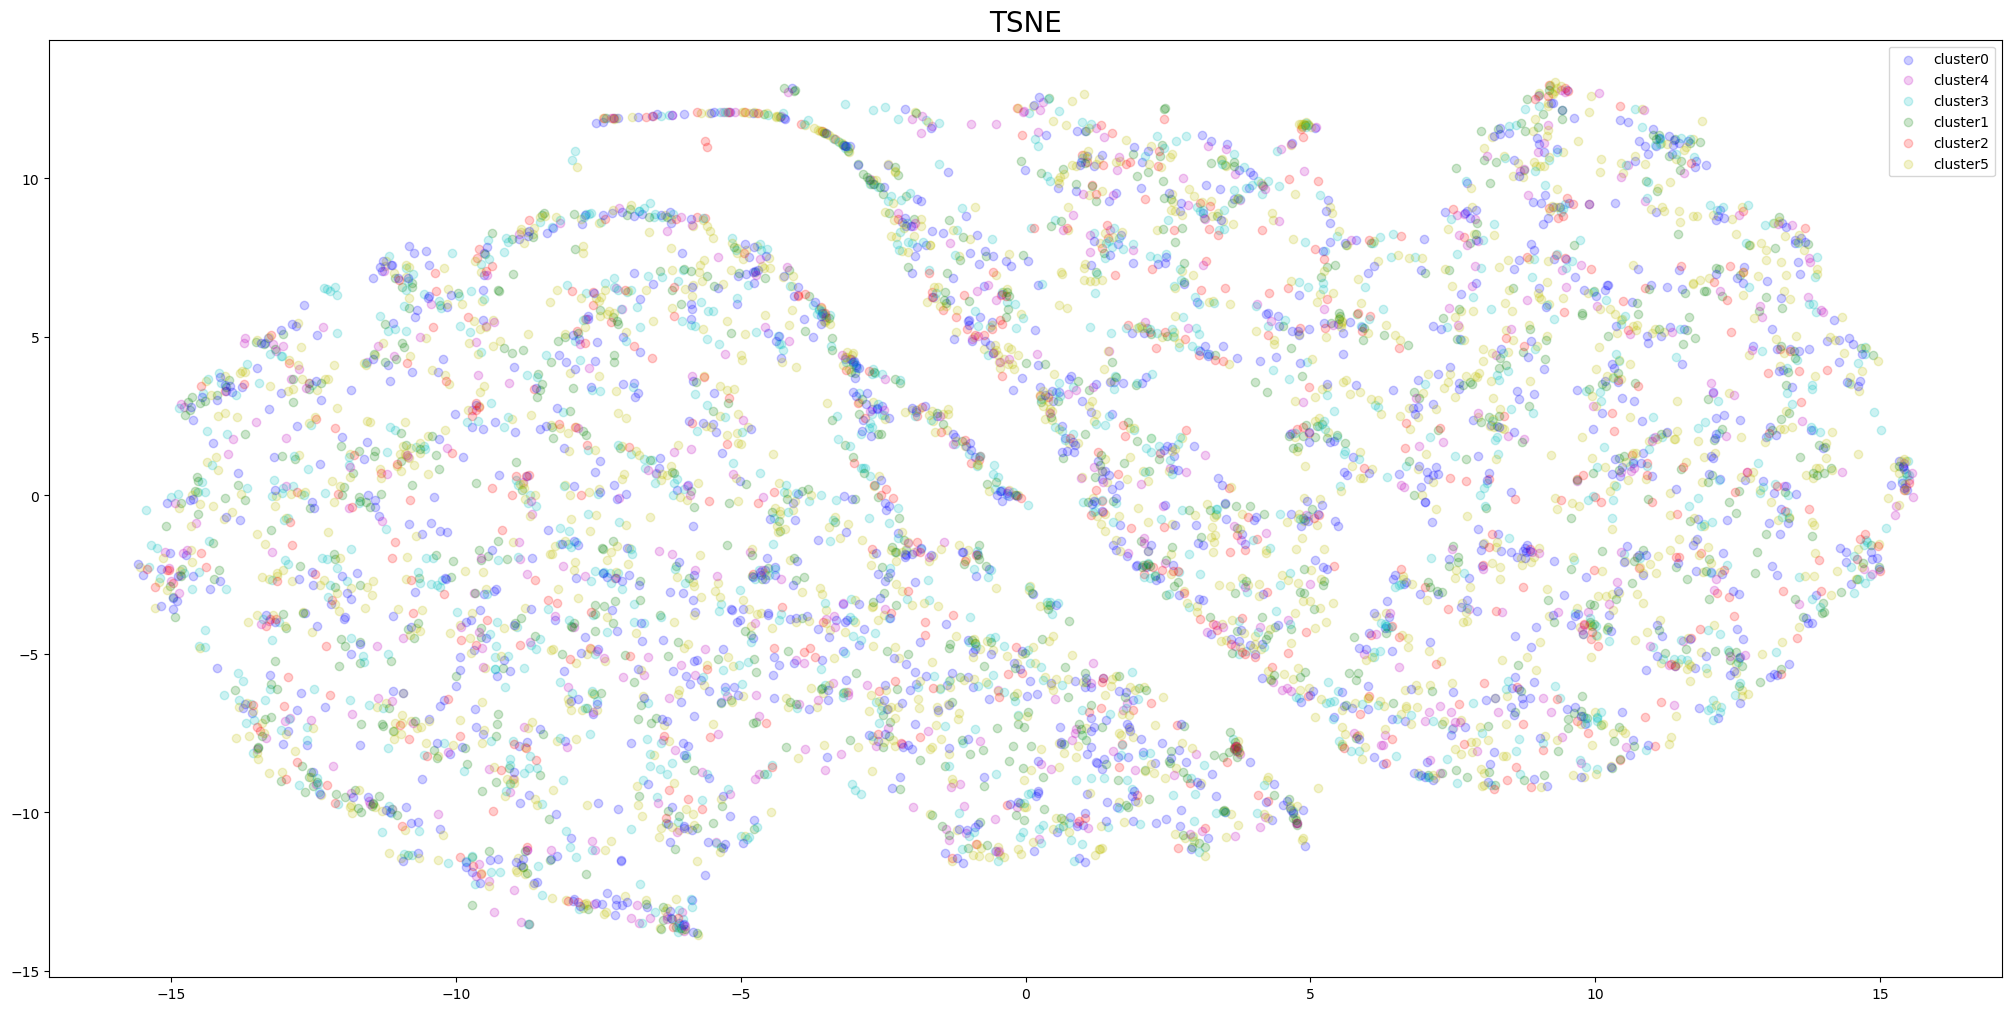

In [176]:
TSNE_plot(tsne_results,dwt_label)

TSNE of KNN

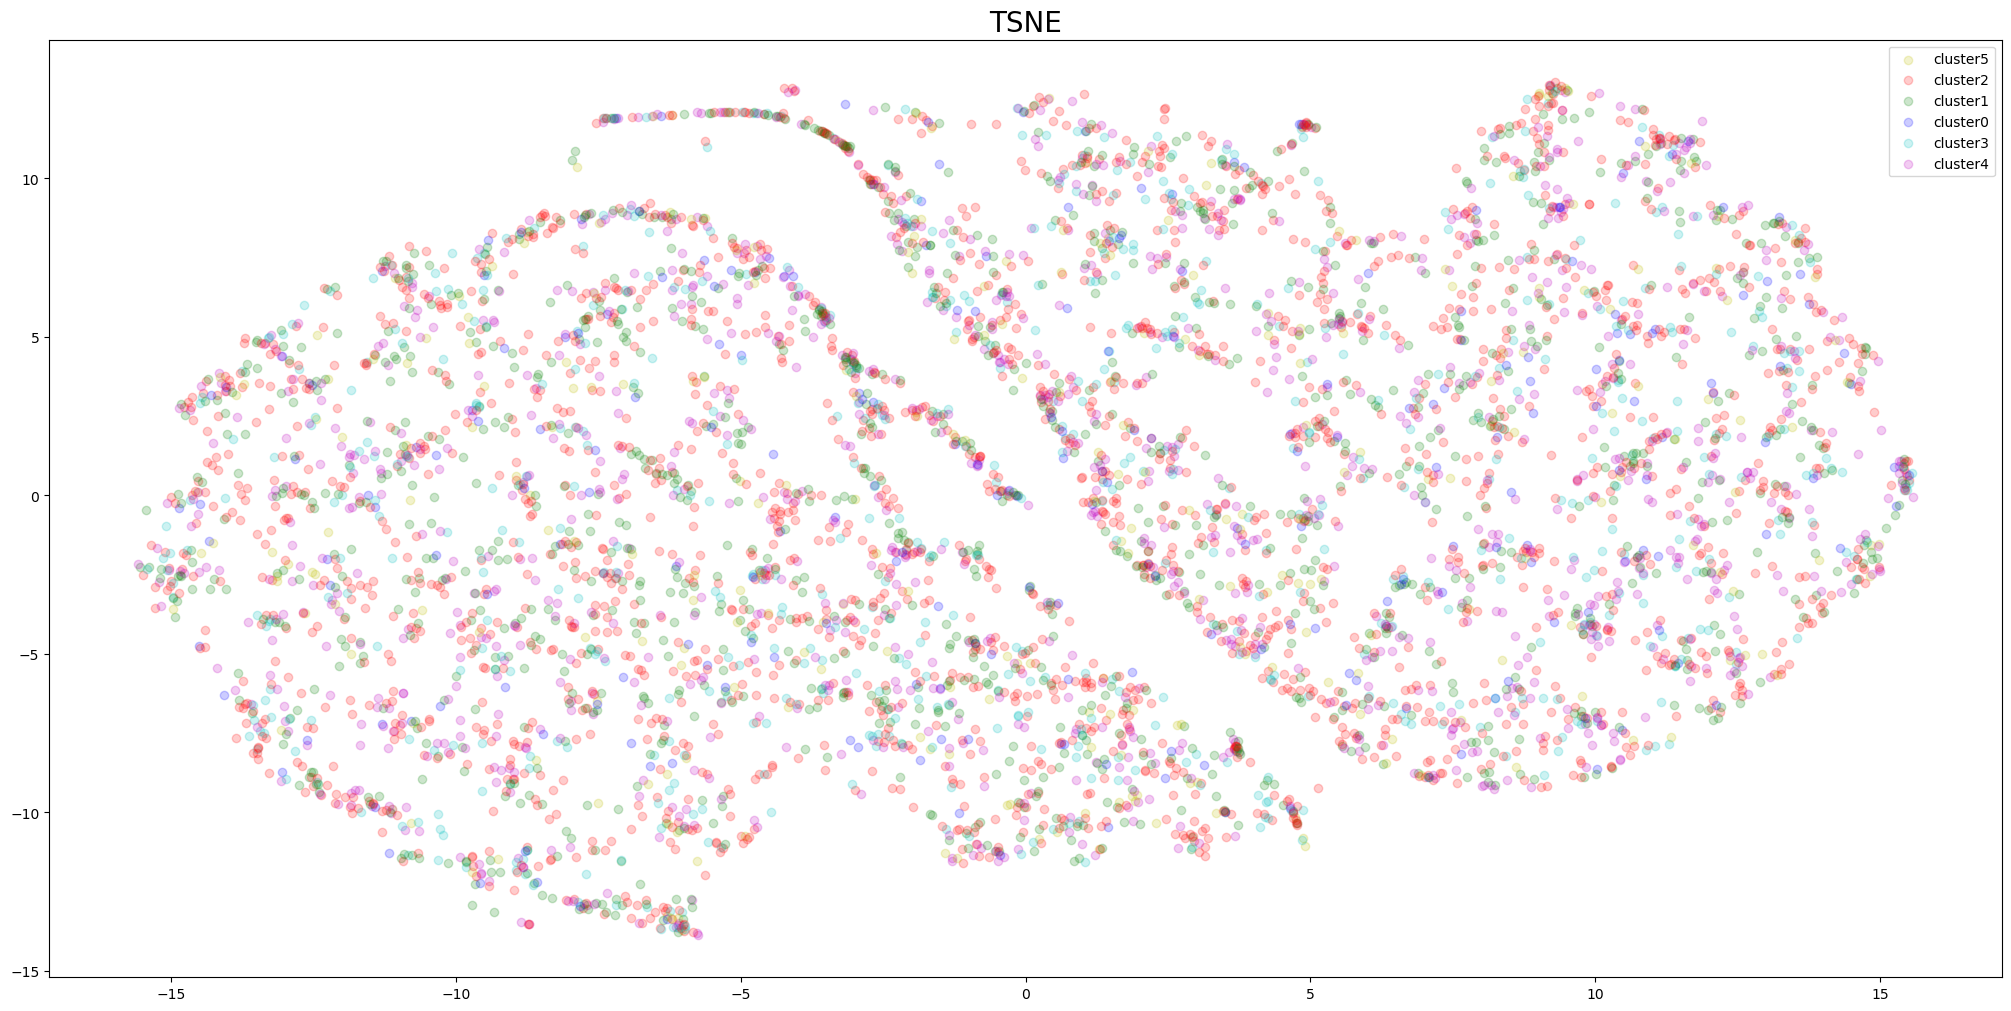

In [178]:
TSNE_plot(tsne_results,labels_gak)

# length constrained linear model

In use cases, we usually set constrain on the minimum length of a dynamic series, this is the post-processing process of the dynamic series to meet minimum
length

In [47]:
turning_points_dict={}
coef_list_dict={}
norm_coef_list_dict={}
y_pred_dict={}
for i,tic in enumerate(tics):
    coef_list,turning_points,y_pred_list,norm_coef_list=linear_regession_turning_points(data_ori=data_dict[tic],tic=tic,length_constrain=24)
    turning_points_dict[tic]=turning_points
    coef_list_dict[tic]=coef_list
    y_pred_dict[tic]=y_pred_list
    norm_coef_list_dict[tic]=norm_coef_list

In [48]:
all_coef_list=np.vstack([array for array in norm_coef_list_dict.values()])

In [49]:
coef_stats=pd.DataFrame(all_coef_list).describe()
display(coef_stats)
percent_25=coef_stats.loc['25%',0]
percent_75=coef_stats.loc['75%',0]

0
count  2220.000000
mean      0.079565
std       0.320038
min      -3.095165
25%      -0.092169
50%       0.085719
75%       0.257236
max       2.339544

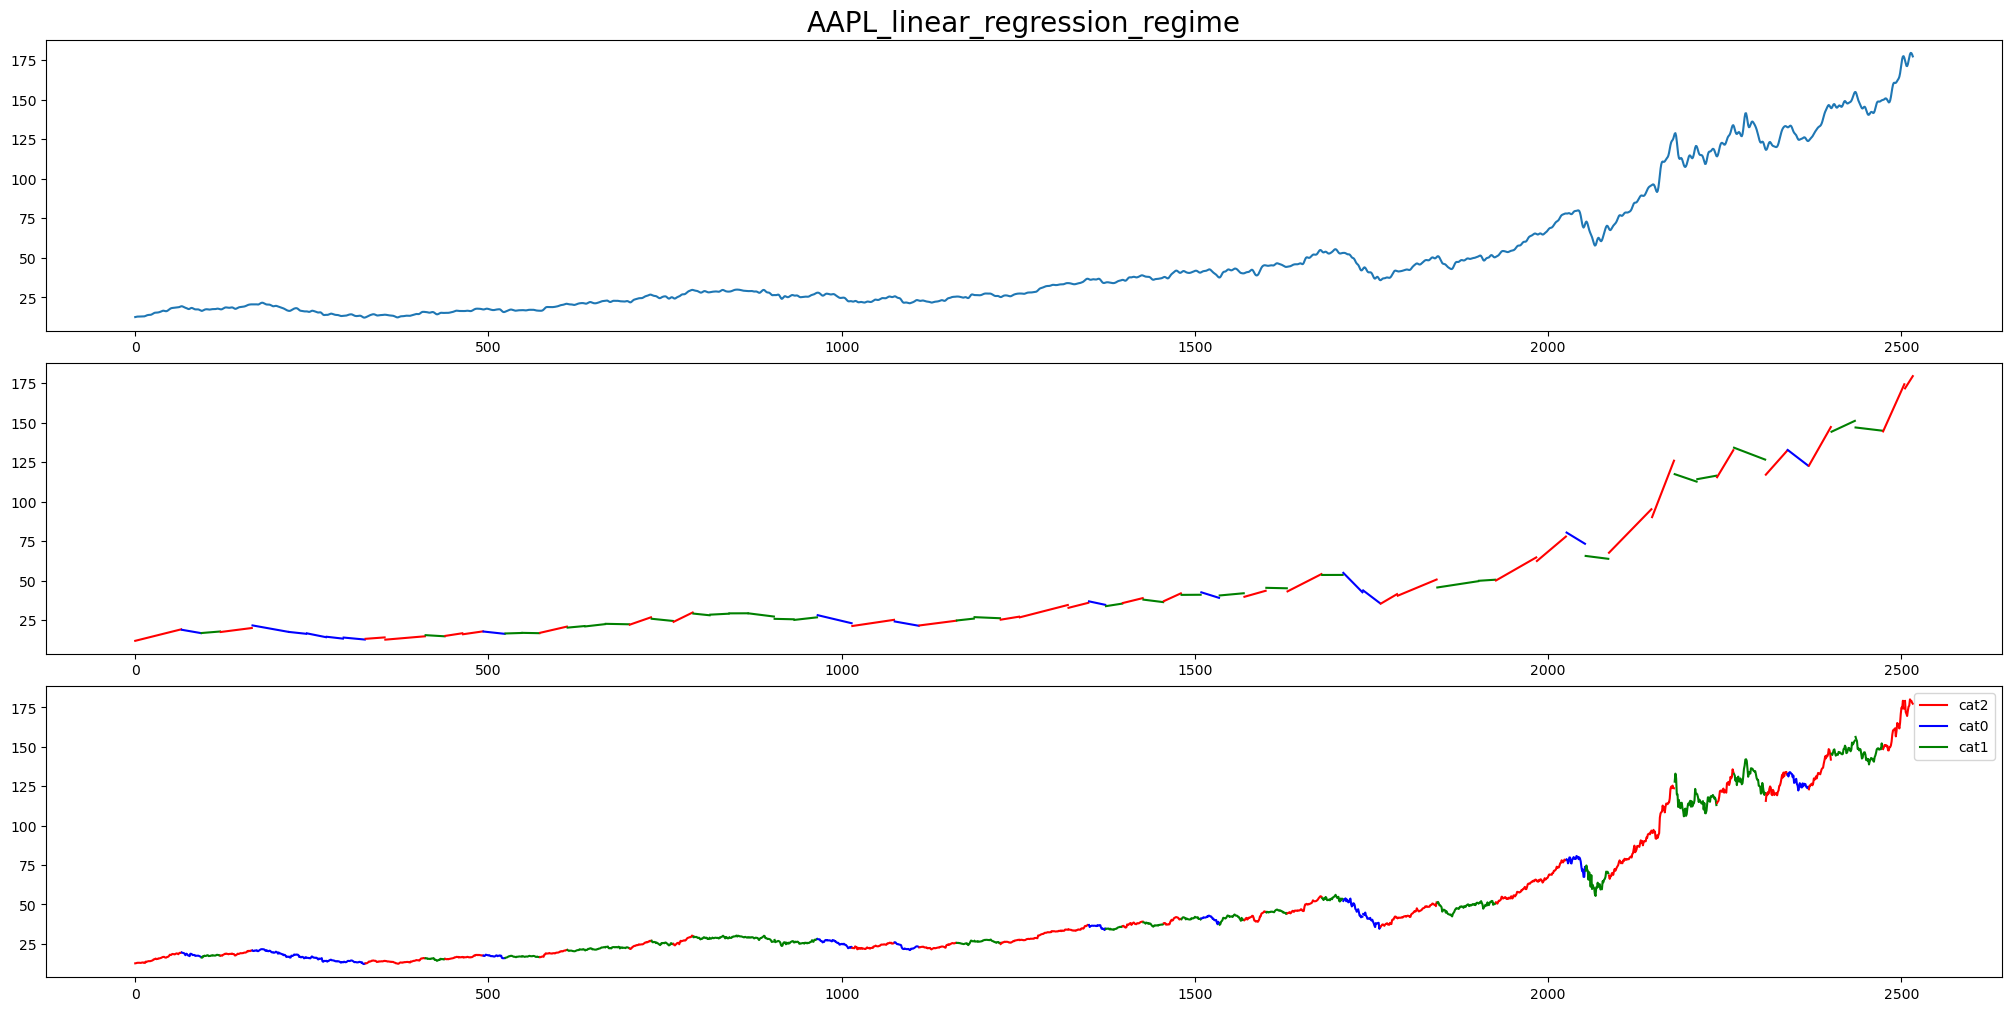

In [53]:
adjcp_data_seg,all_label_seg,all_index_seg=run_linear_model('adjcp_filtered_normalized',tics,turning_points_dict,coef_list_dict,y_pred_dict,norm_coef_list_dict,1,False,3,-0.25,0.25)
pct_return_normalized_data_seg,all_label_seg,all_index_seg=run_linear_model('pct_return_filtered_normalized',tics,turning_points_dict,coef_list_dict,y_pred_dict,norm_coef_list_dict,False,False,3,-0.25,0.25)
pct_return_data_seg,all_label_seg,all_index_seg=run_linear_model('pct_return_filtered',tics,turning_points_dict,coef_list_dict,y_pred_dict,norm_coef_list_dict,False,False,3,-0.25,0.25)

In [ ]:
interpolated_pct_return_data_seg=np.array(interpolation(pct_return_data_seg))

In [ ]:
tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter = 300)
tsne_results = tsne.fit_transform(interpolated_pct_return_data_seg)

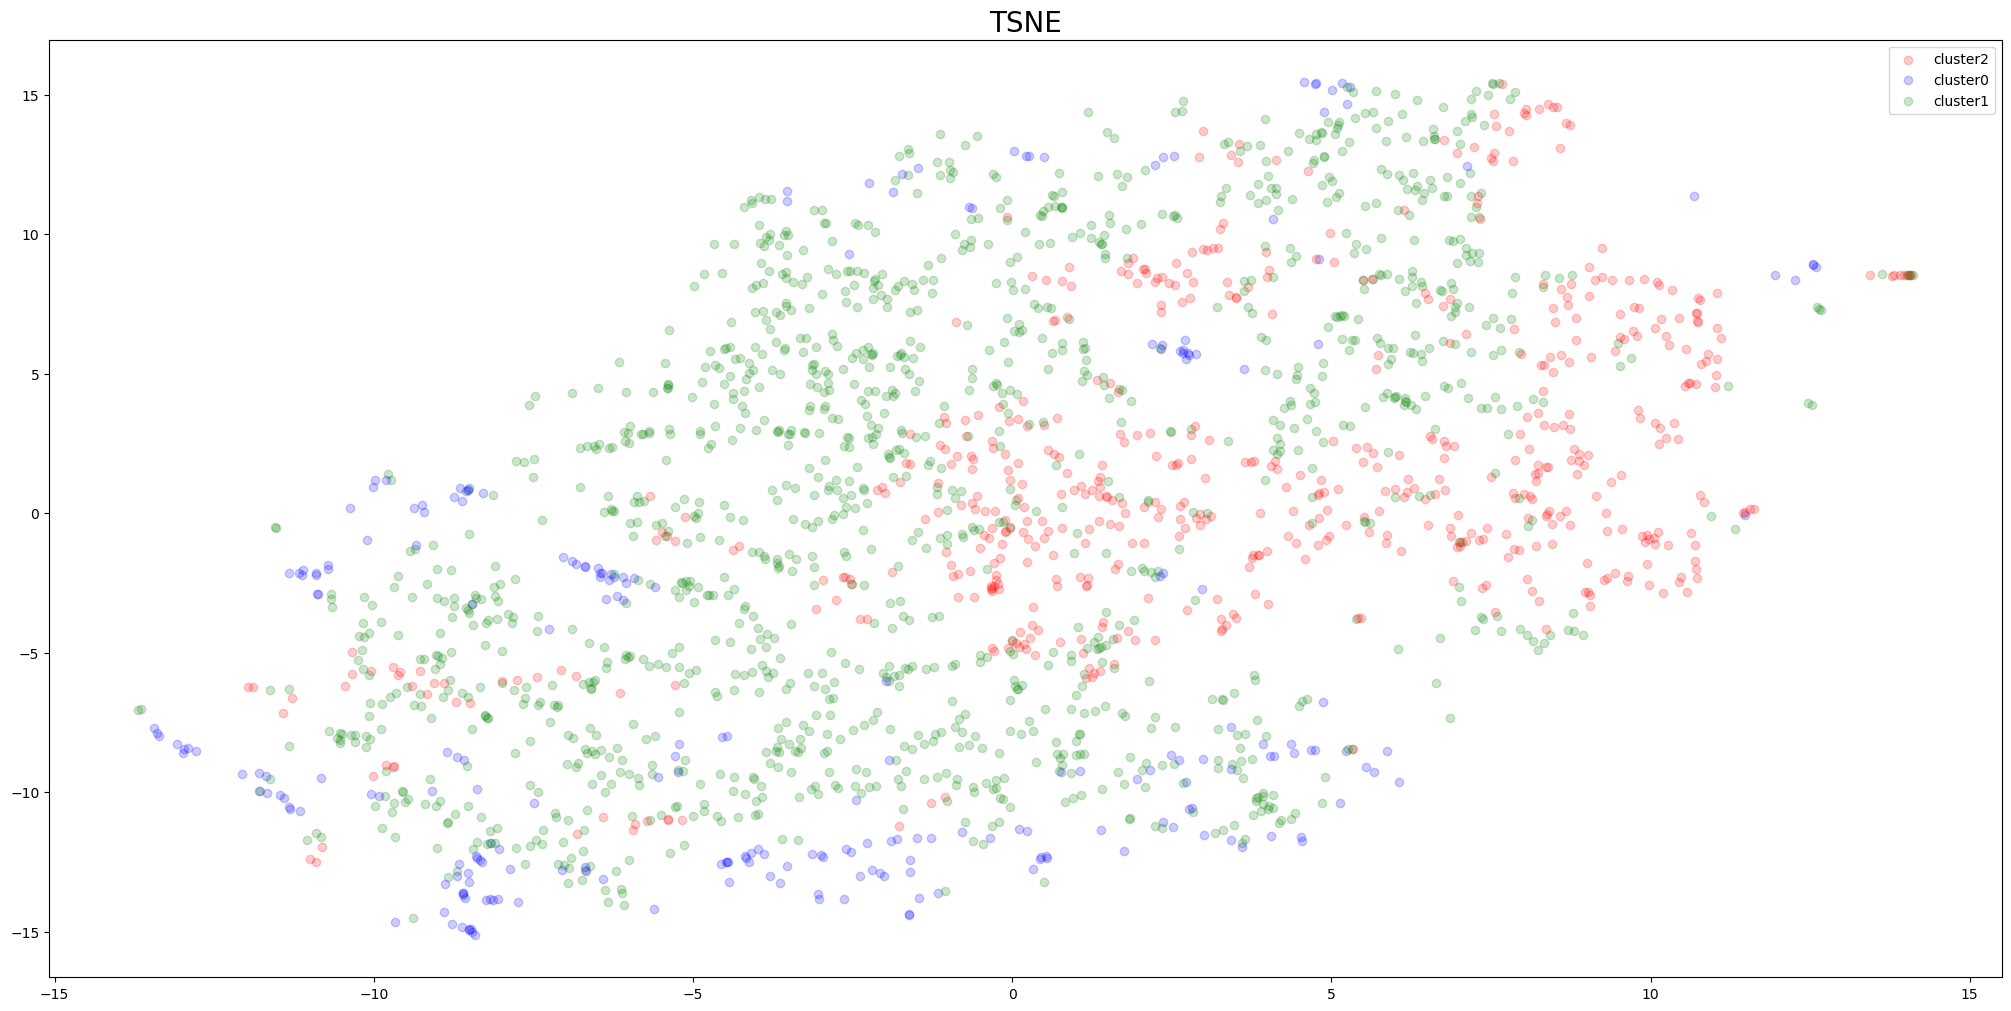

In [371]:
TSNE_plot(tsne_results,all_label_seg)

# Stock grouping based on similarity

In [38]:
data=pd.read_csv('../data/dj30/dj30.csv')

In [39]:
tics = data['tic'].unique()
data_dict = {}
for tic in tics:
    tic_data = data.loc[data['tic'] == tic, :]
    tic_data.sort_values(by='date', ascending=True)
    tic_data = tic_data.assign(pct_return=tic_data['adjcp'].pct_change().fillna(0))
    data_dict[tic] = tic_data.reset_index(drop=True).loc[:,['date','open','high','low','close','adjcp','pct_return']]

In [40]:
data_by_tic=[]
for tic in tics:
    data_by_tic.append(data_dict[tic].loc[:,['open','high','low','close','adjcp','pct_return']].values)

In [42]:
fitting_data=to_time_series_dataset(data_by_tic)

In [ ]:
km_stock=TimeSeriesKMeans(n_clusters=6, metric="dtw", max_iter=50,max_iter_barycenter=100,n_jobs=50,verbose=1).fit(fitting_data)

In [ ]:
label_stock=km_stock.predict(fitting_data)

In [292]:
label_dict=[[] for _ in range(km_stock.n_clusters)]
for i,tic in enumerate(tics): 
    label_dict[label_stock[i]].append(tic)

We cluster the stock into groups based on their adjclose

[['CSCO', 'INTC', 'KO', 'MRK', 'VZ', 'WBA'],
 ['GS', 'HD', 'UNH'],
 ['AMGN', 'CAT', 'CRM', 'HON', 'MCD', 'MMM', 'MSFT', 'V'],
 ['IBM'],
 ['BA'],
 ['AAPL', 'AXP', 'CVX', 'DIS', 'JNJ', 'JPM', 'NKE', 'PG', 'TRV', 'WMT']]

This is cluster 0


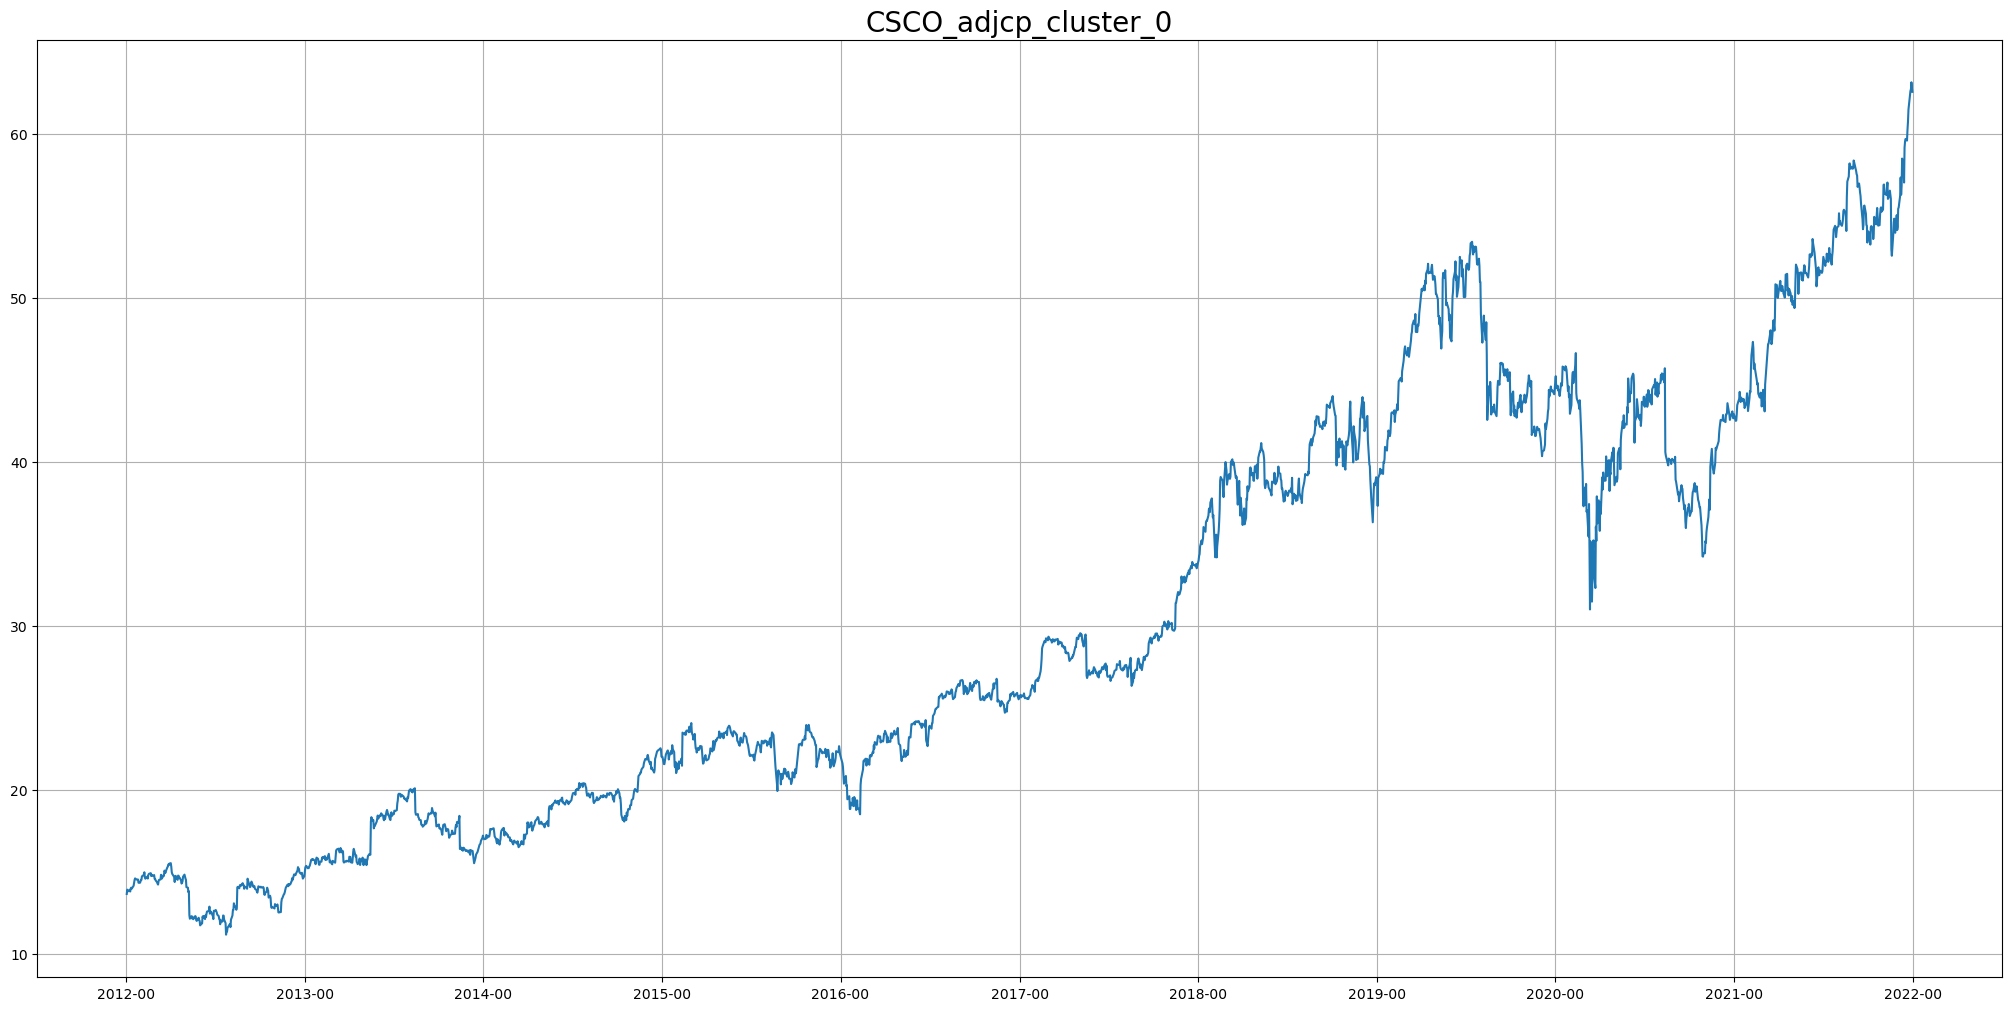

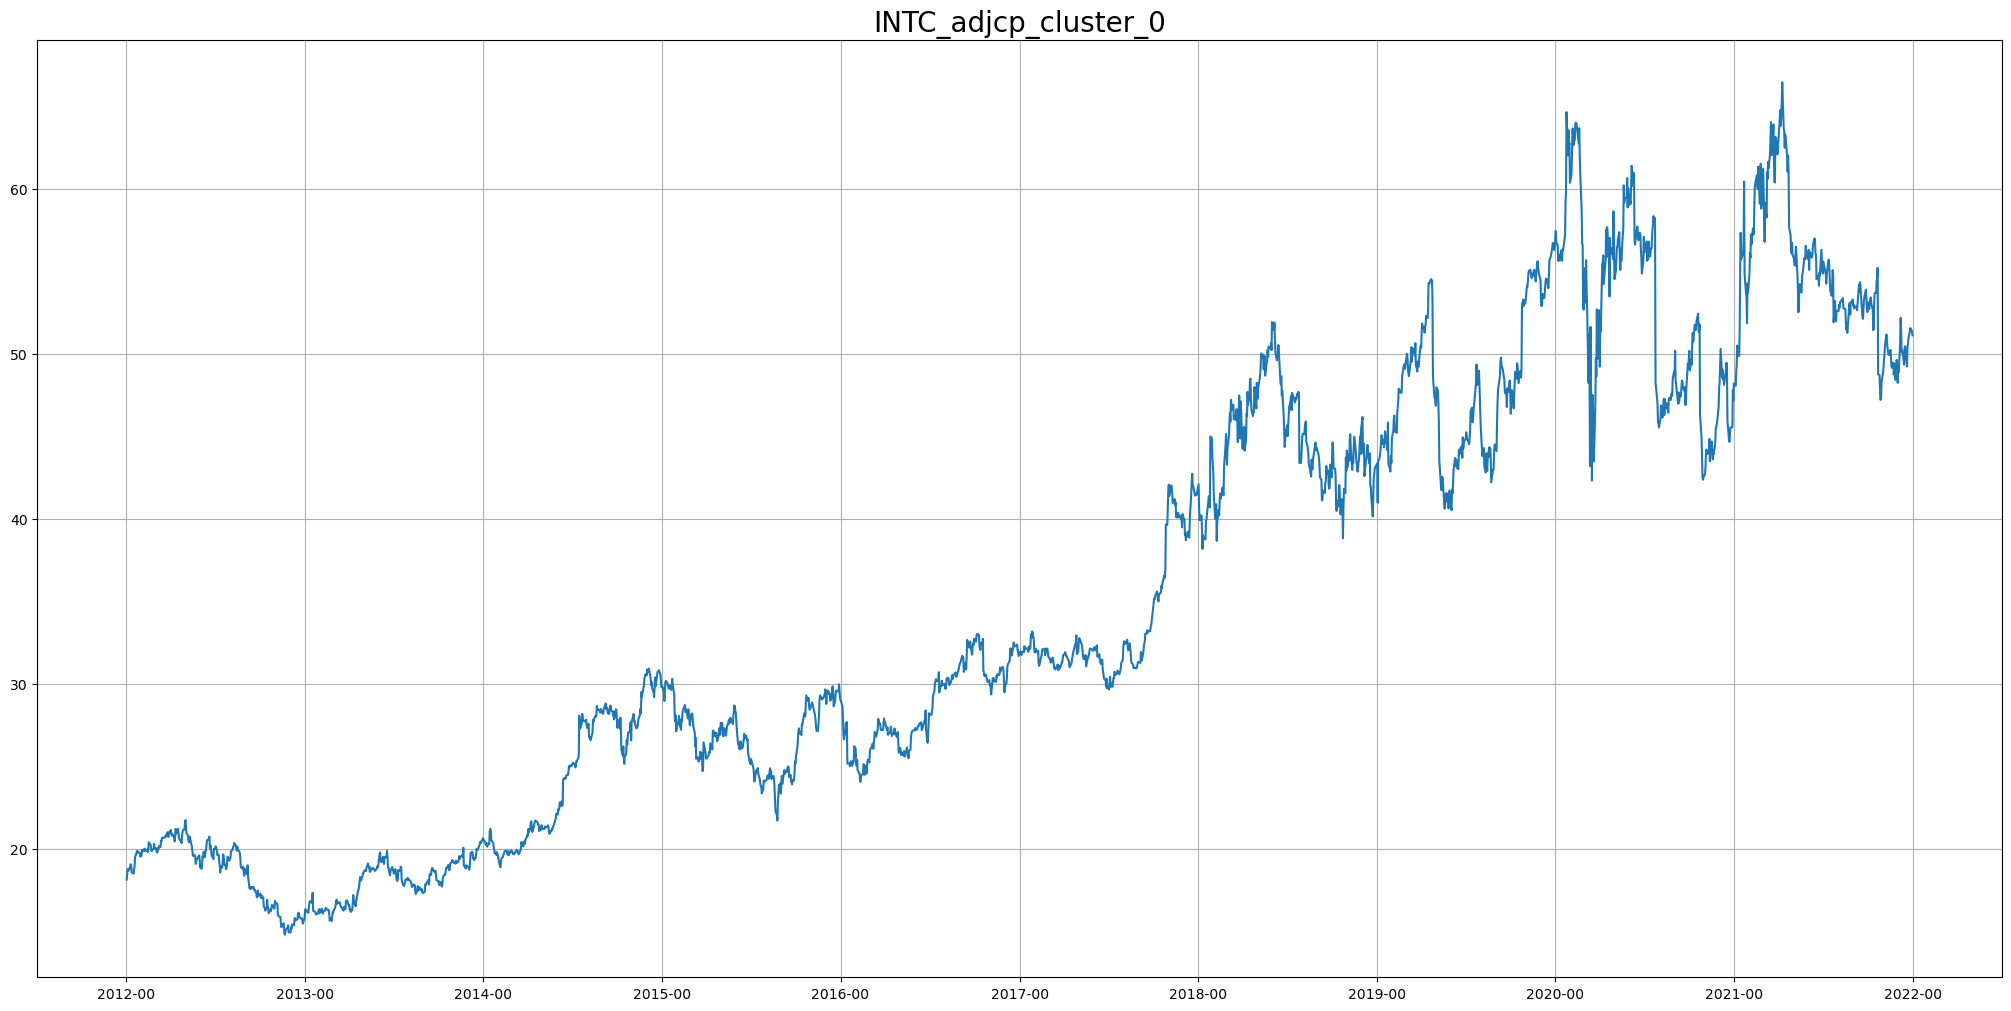

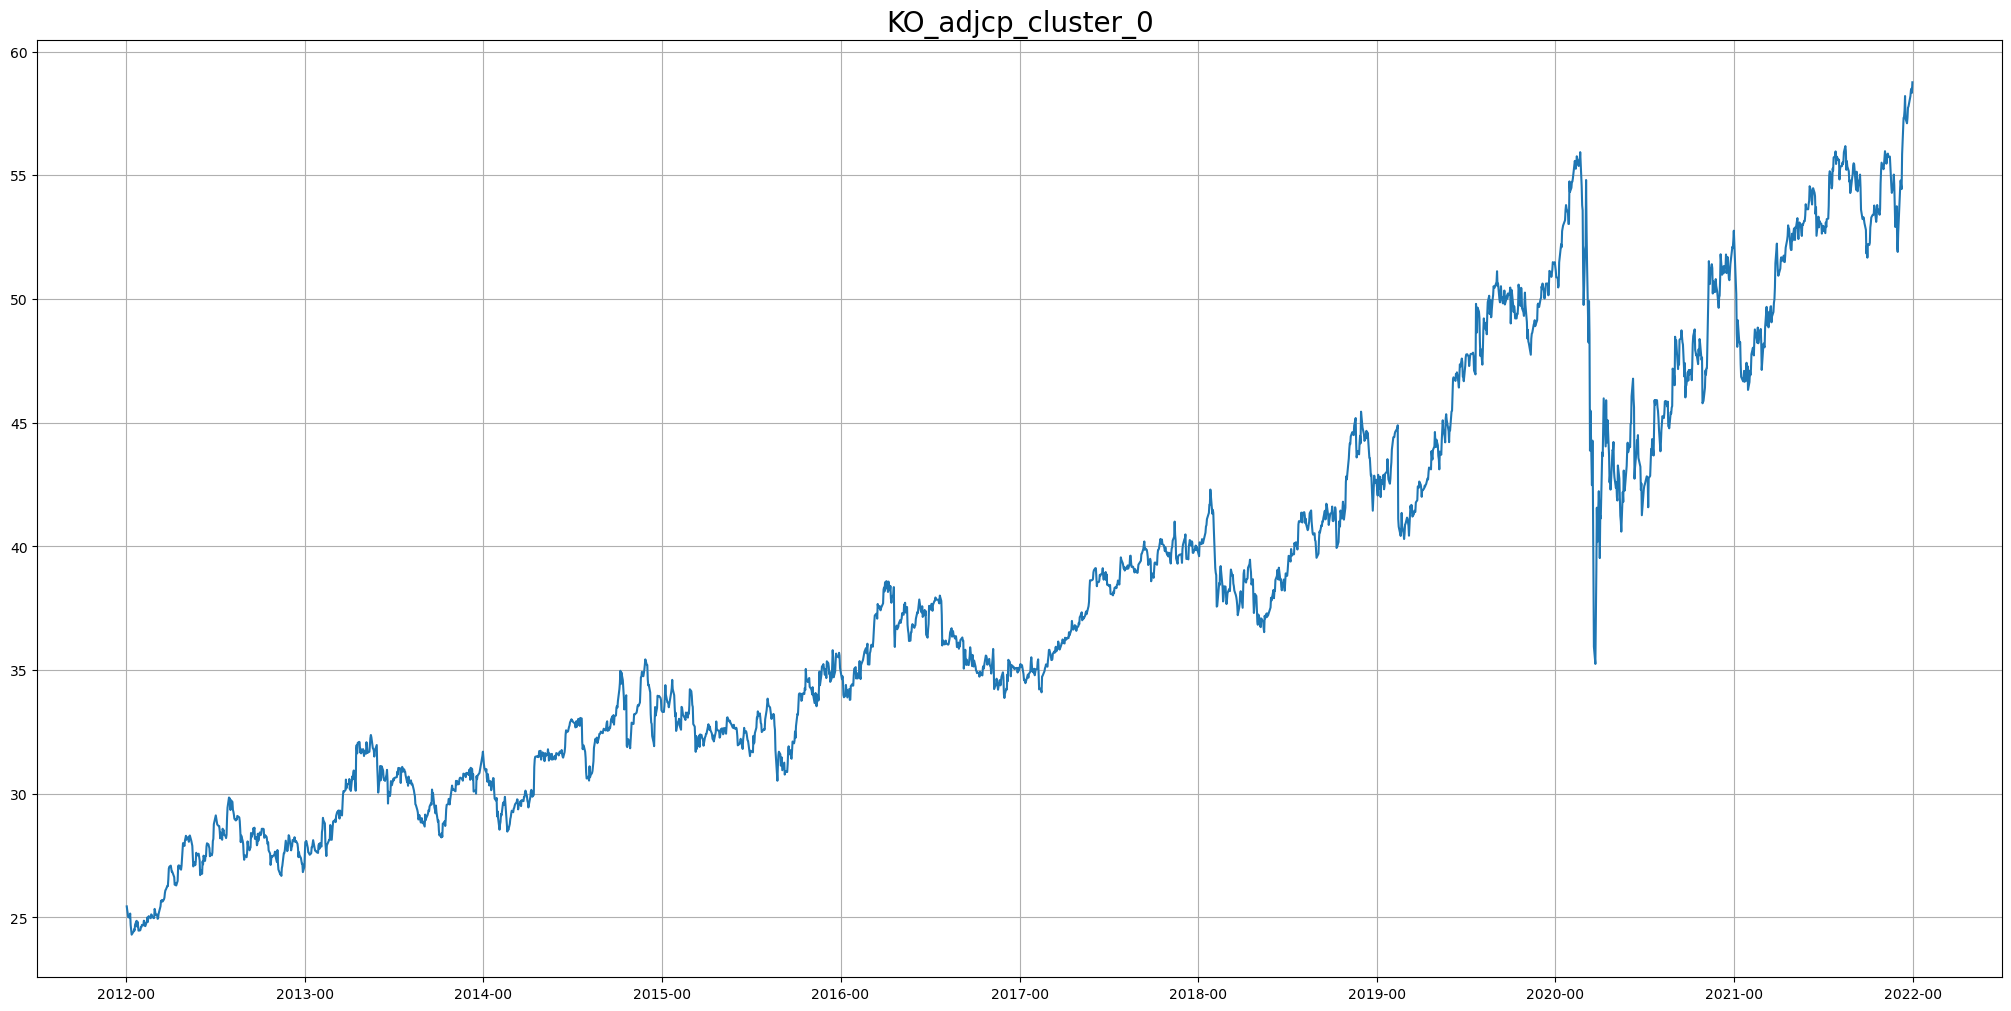

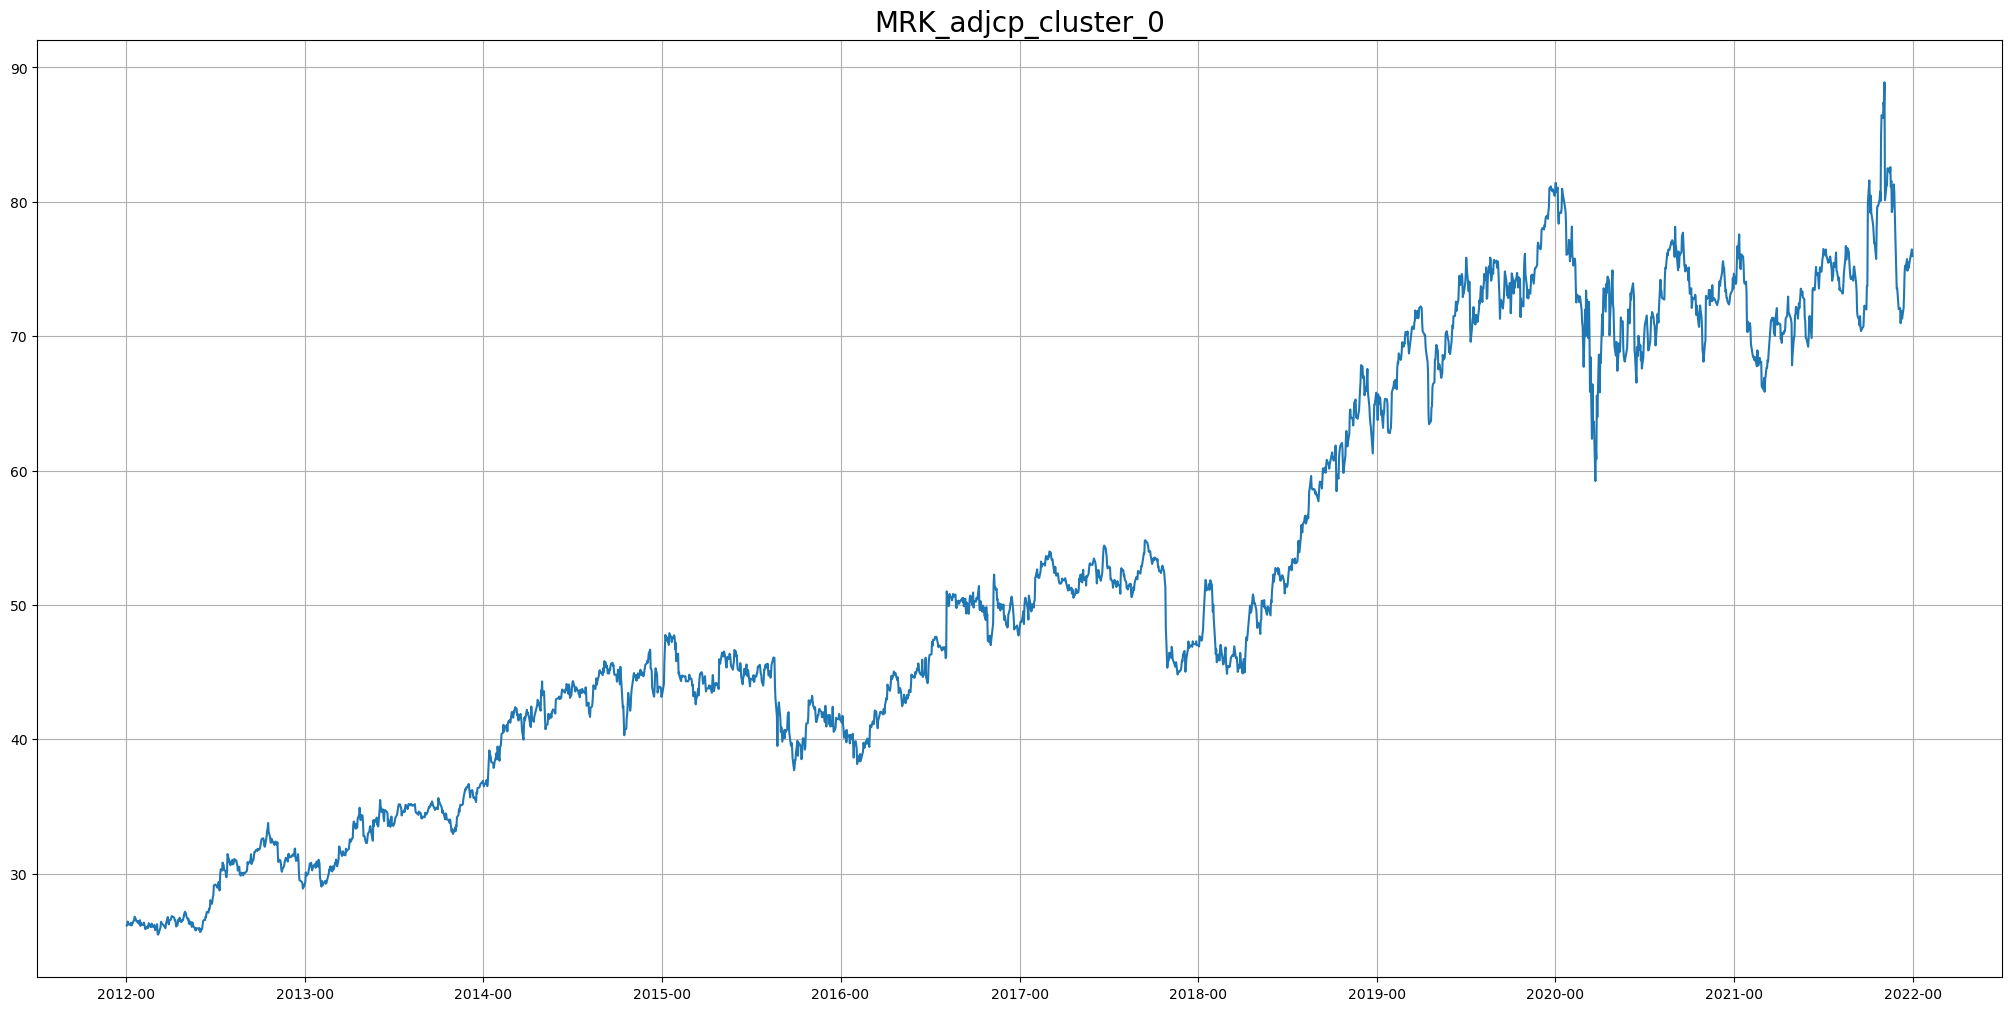

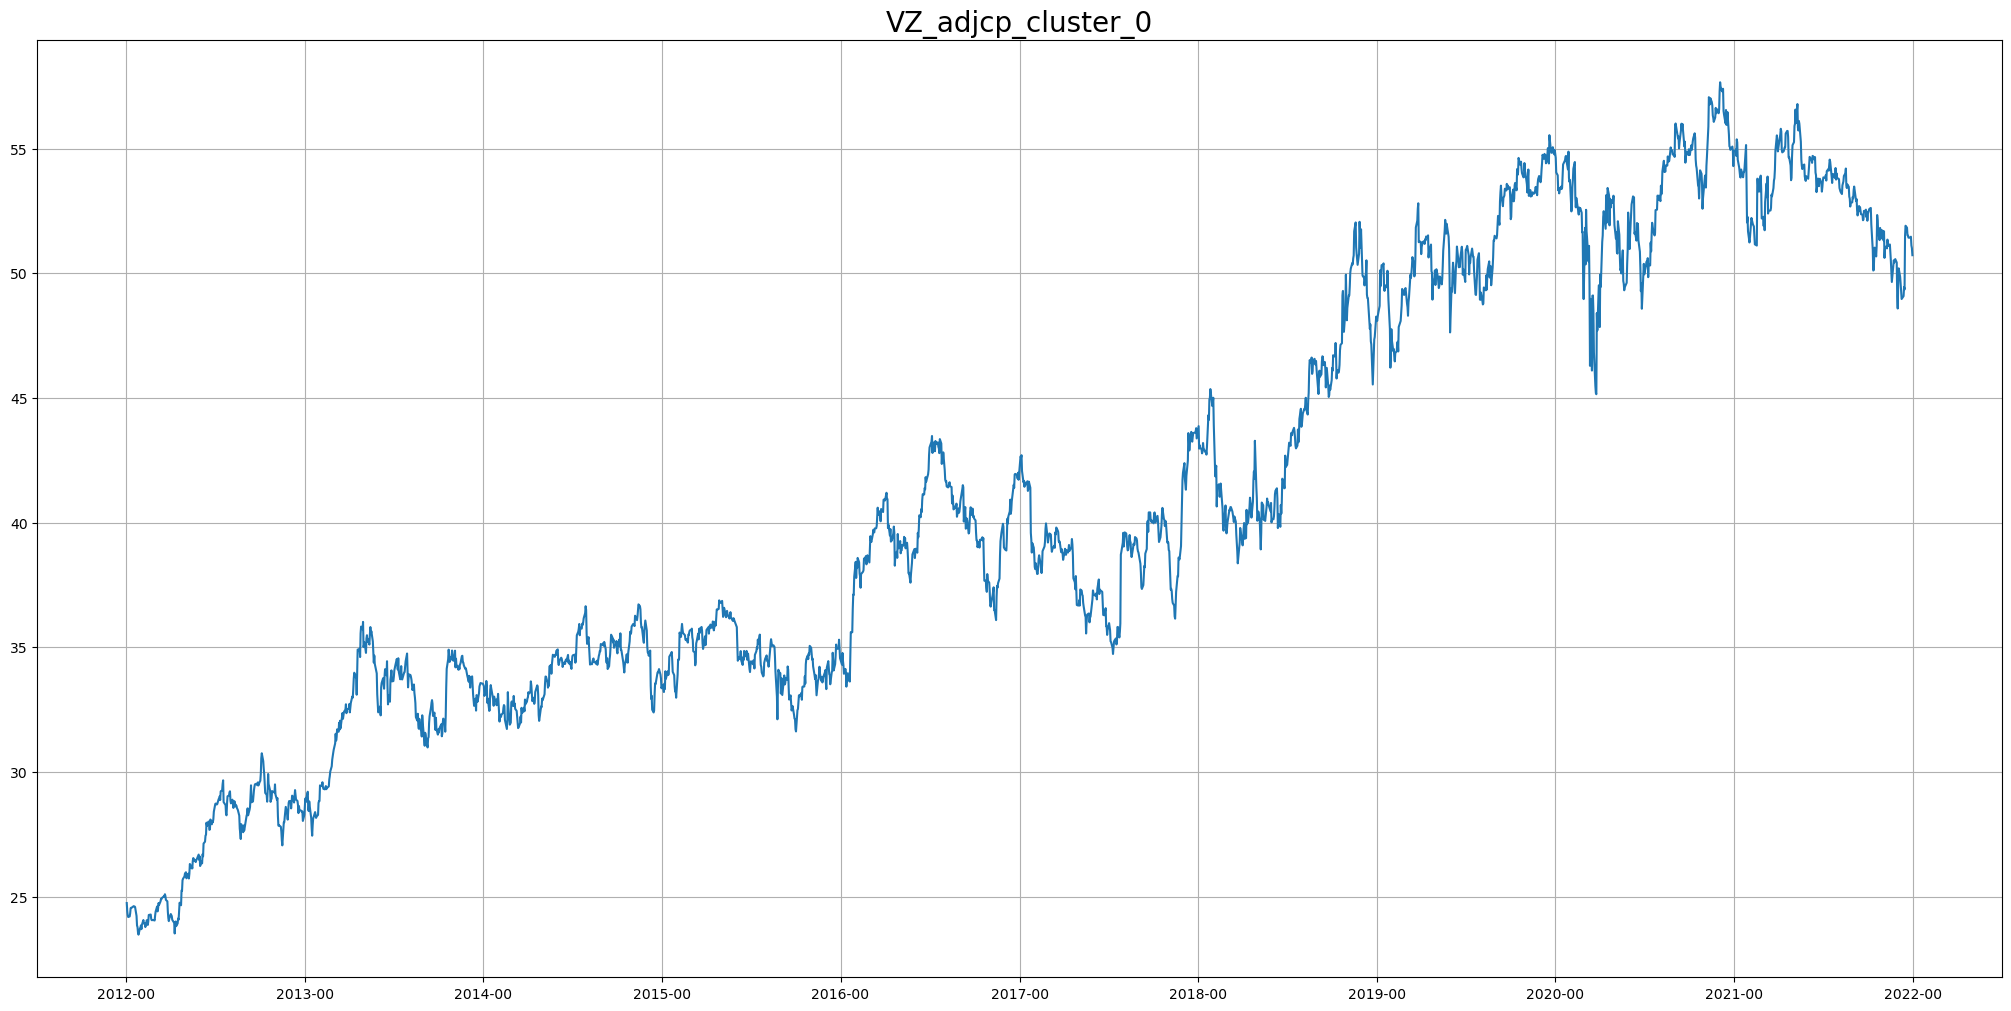

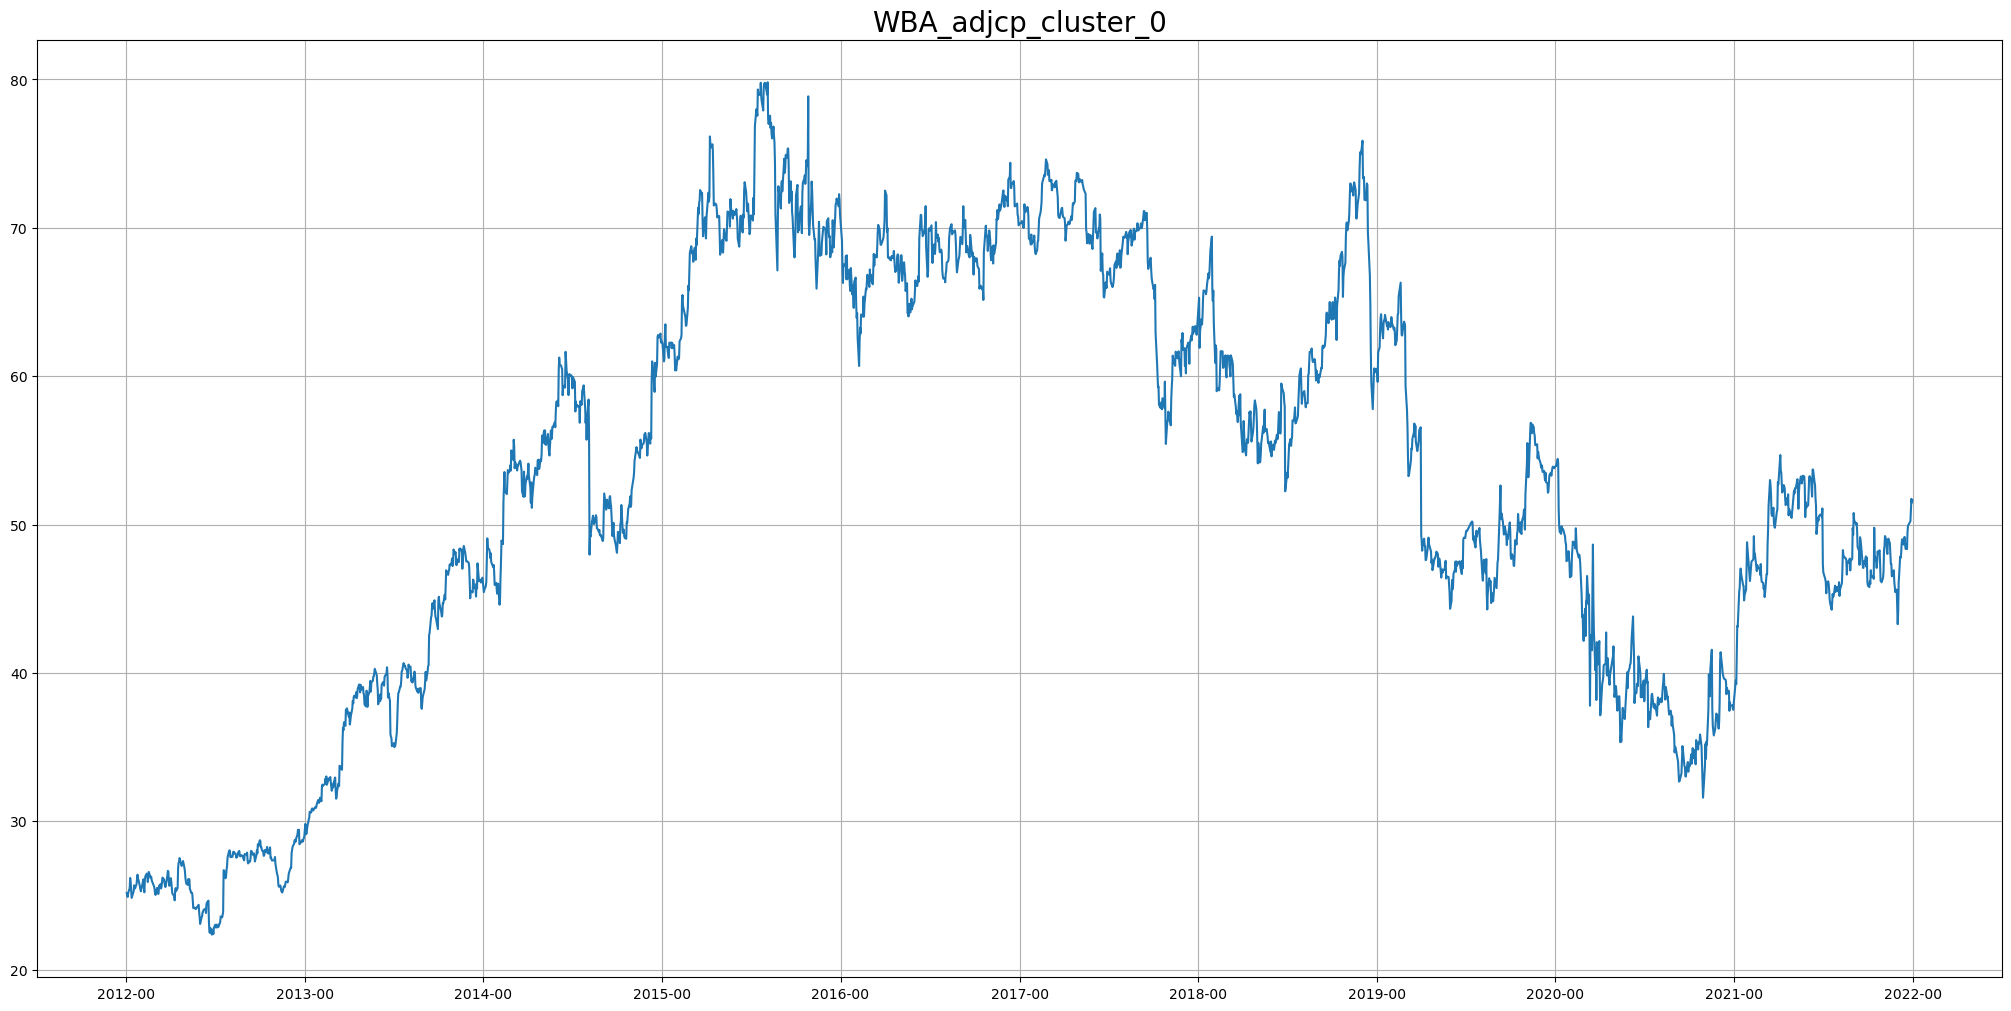

This is cluster 1


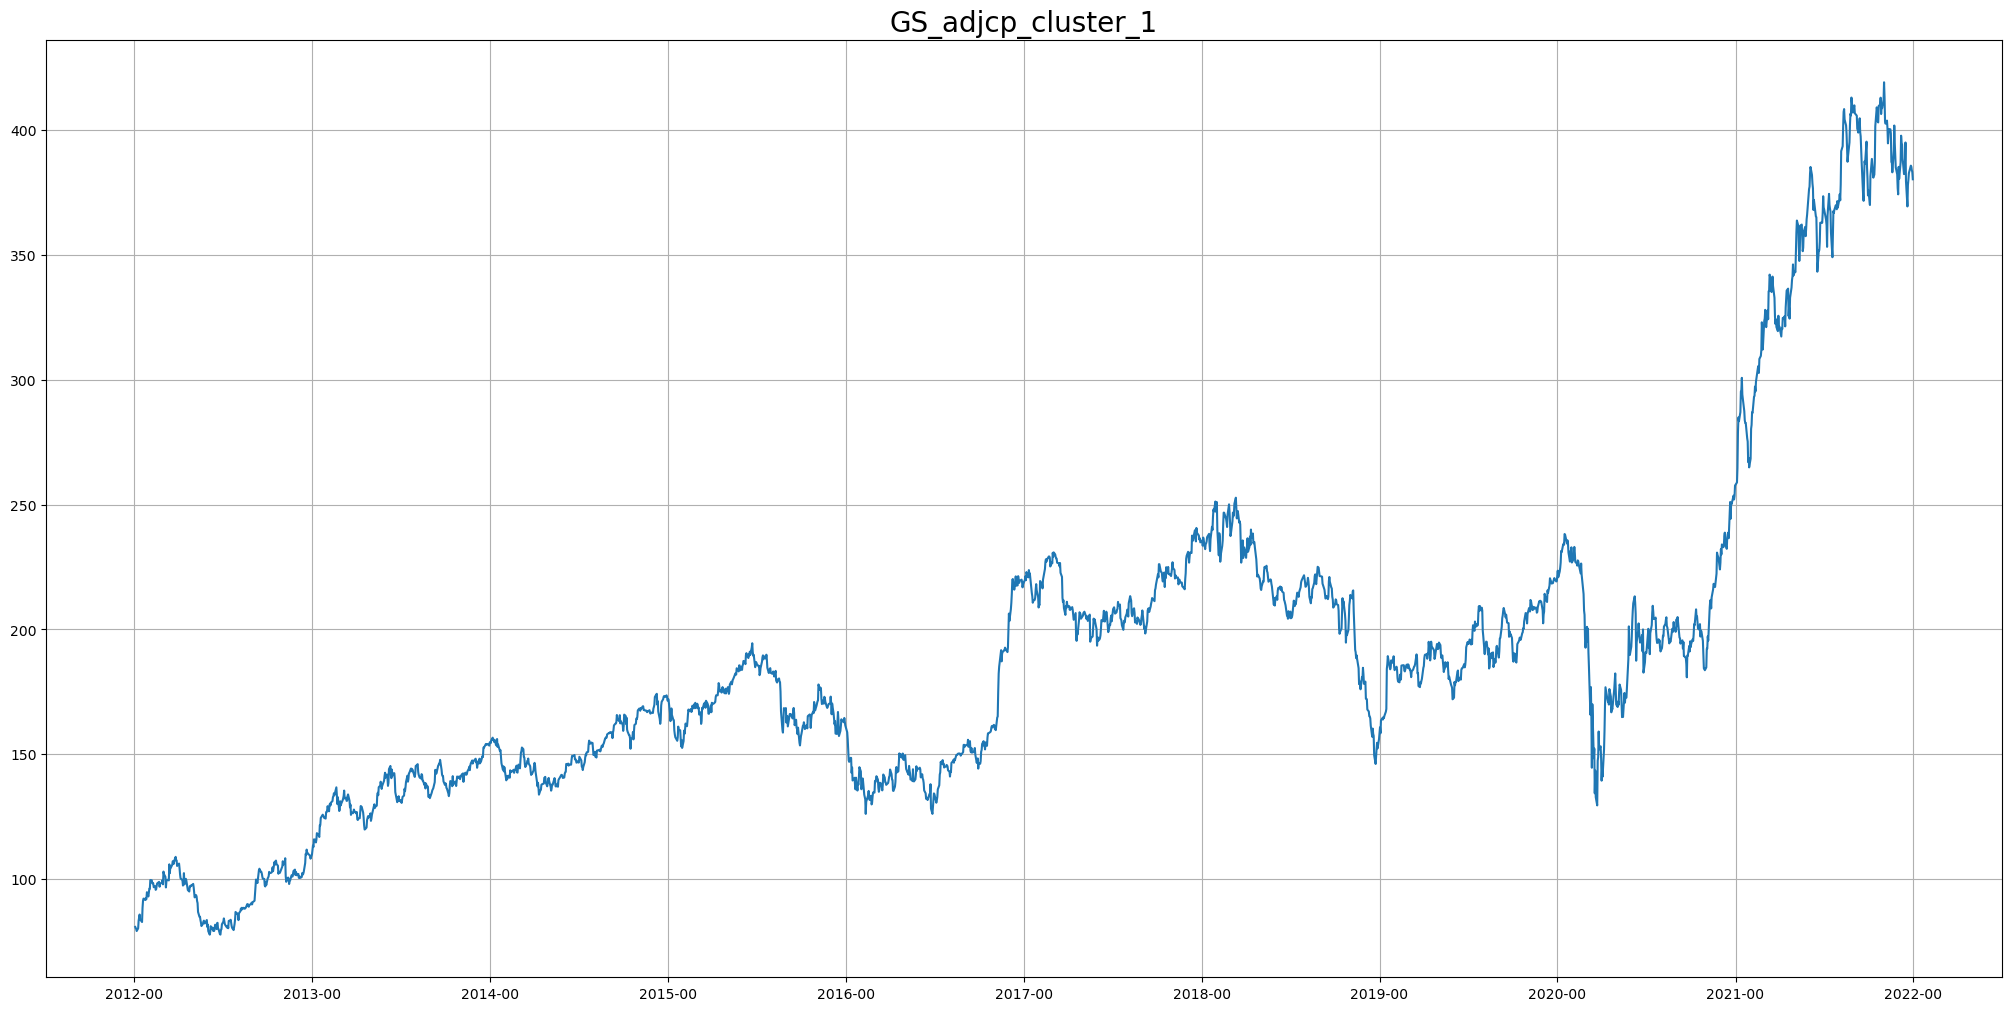

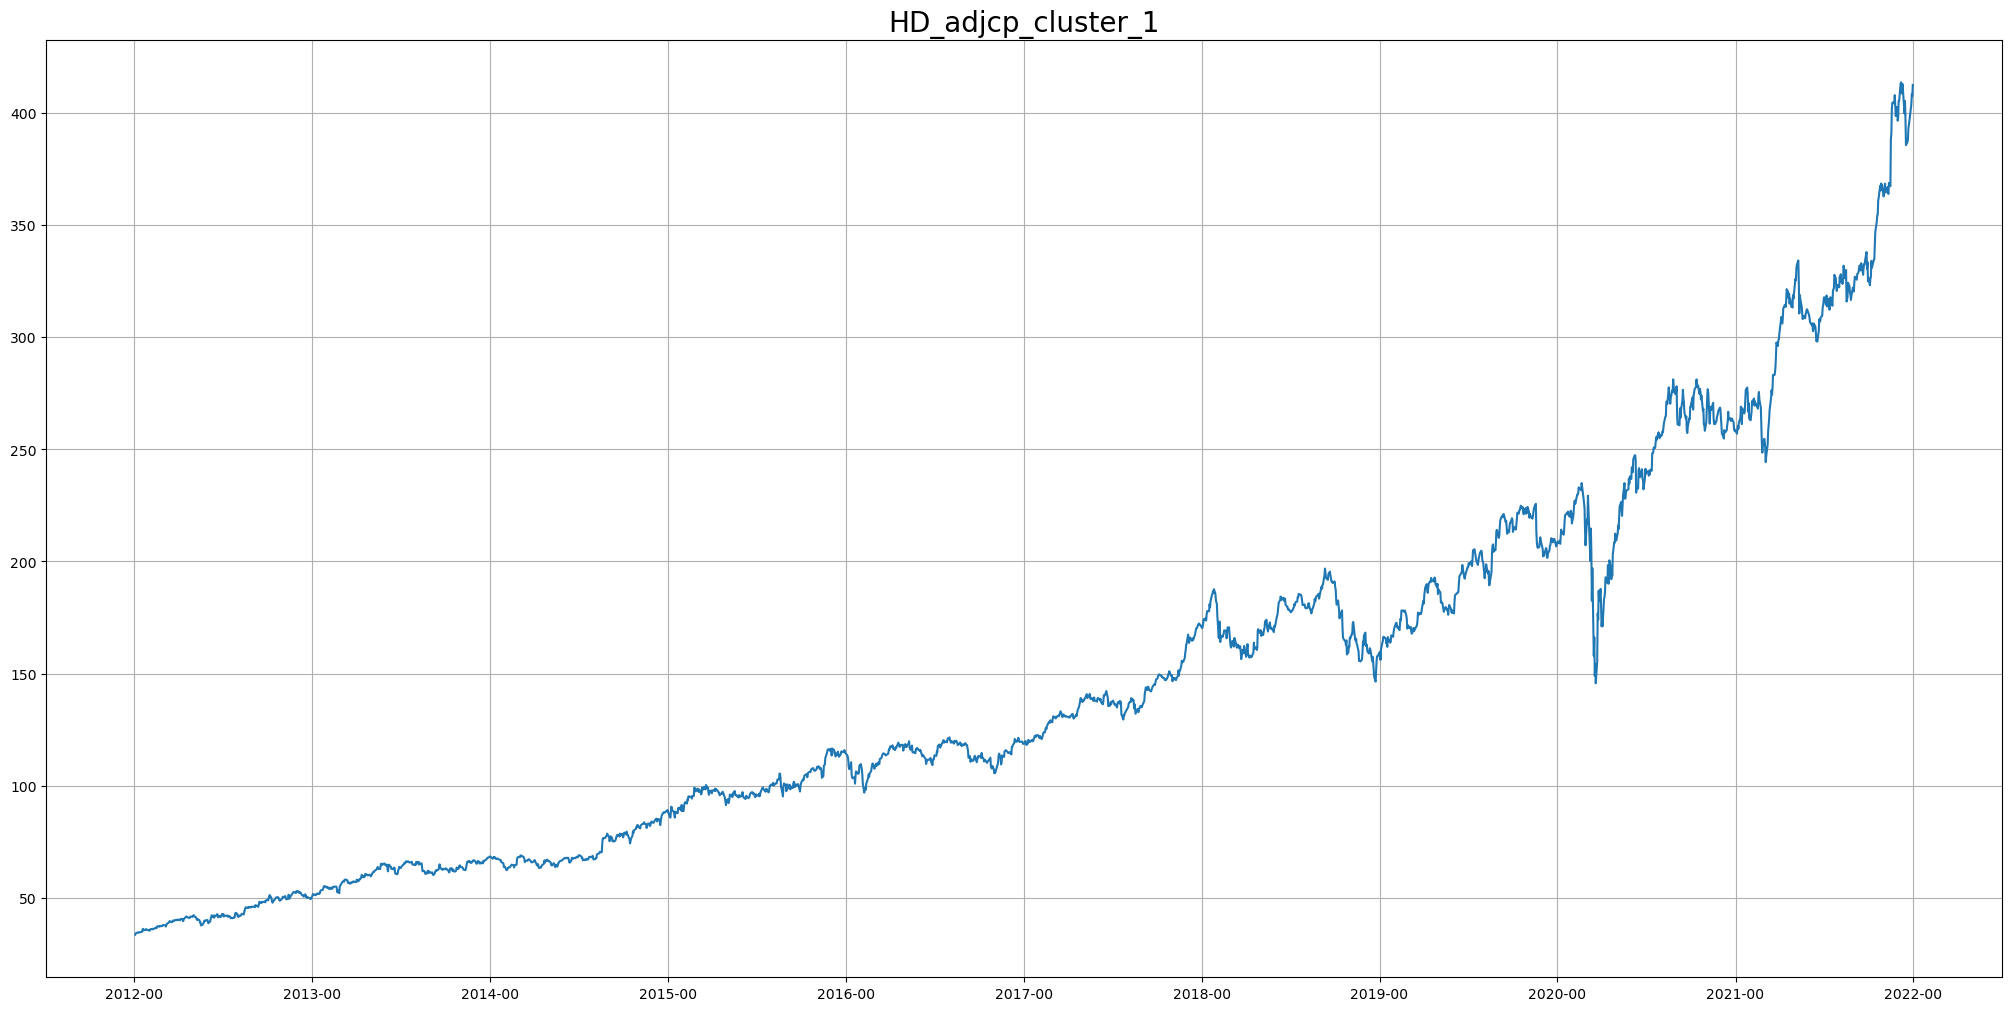

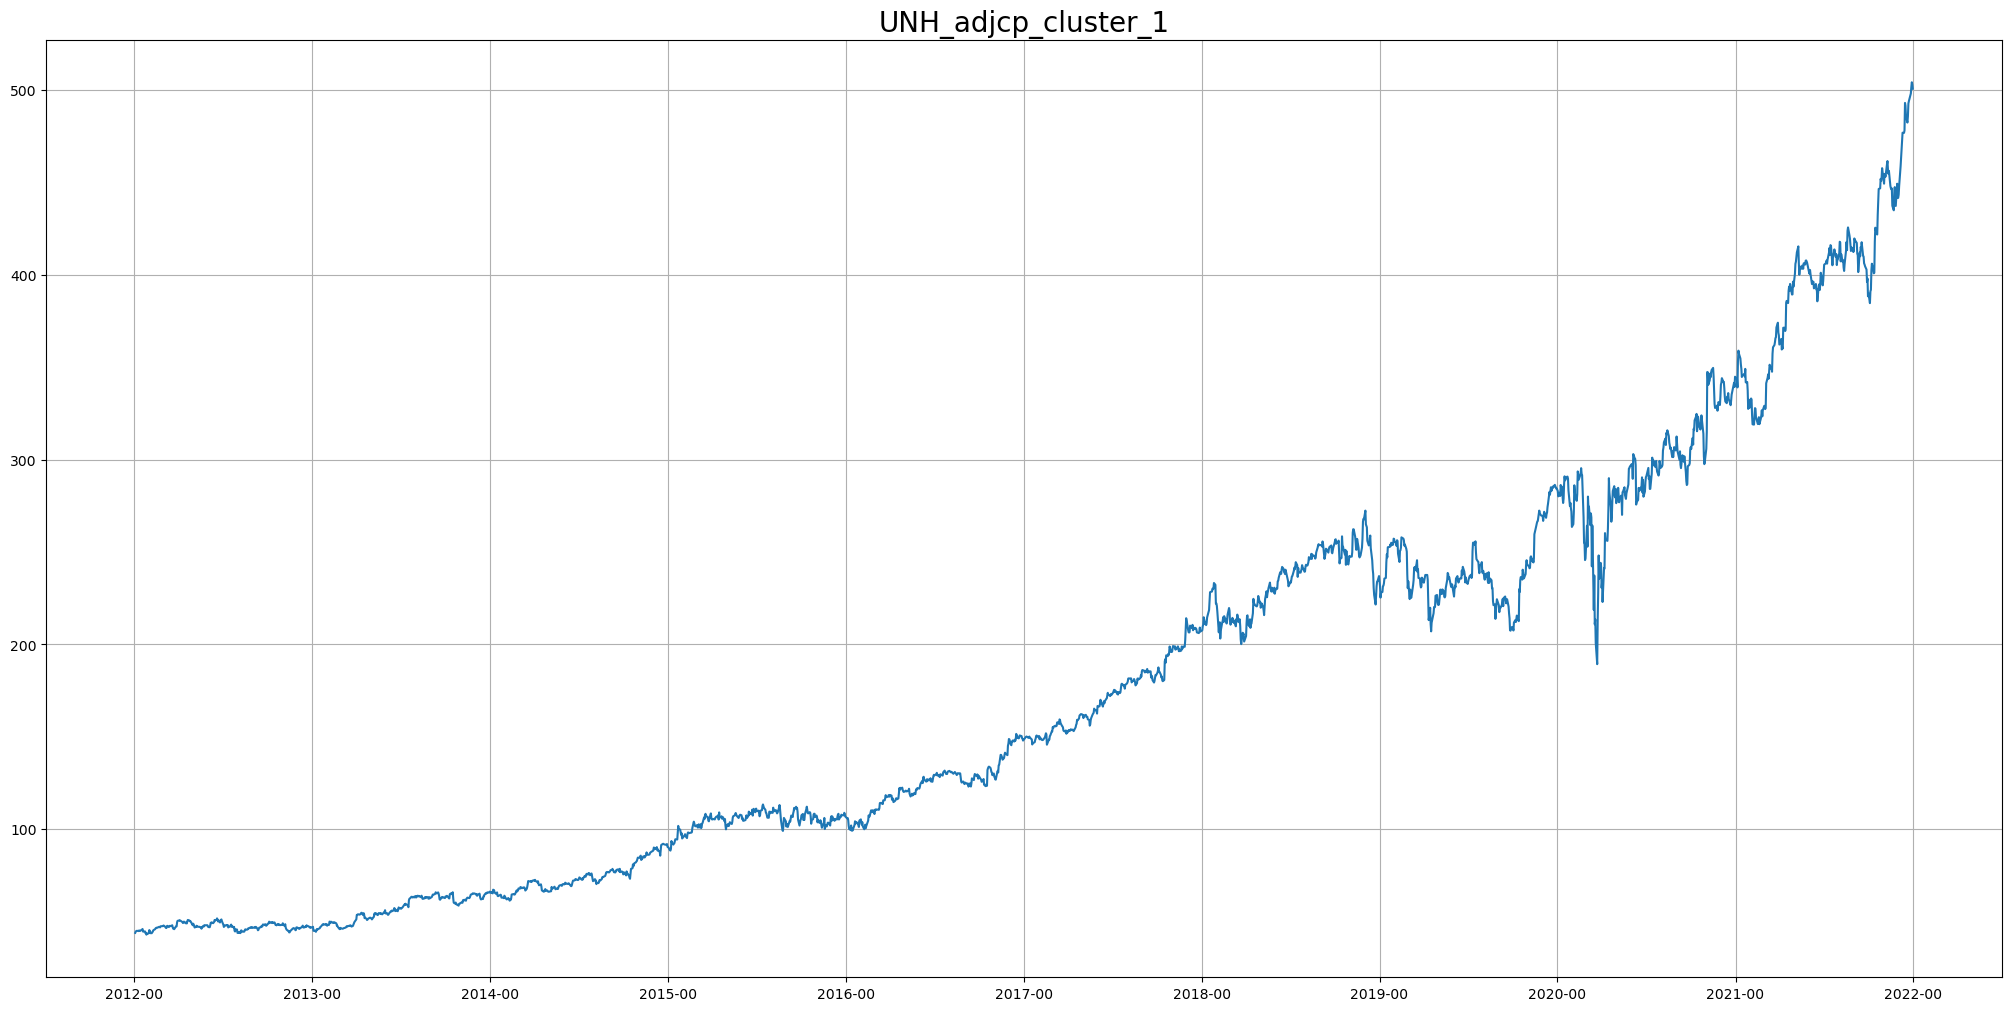

This is cluster 2


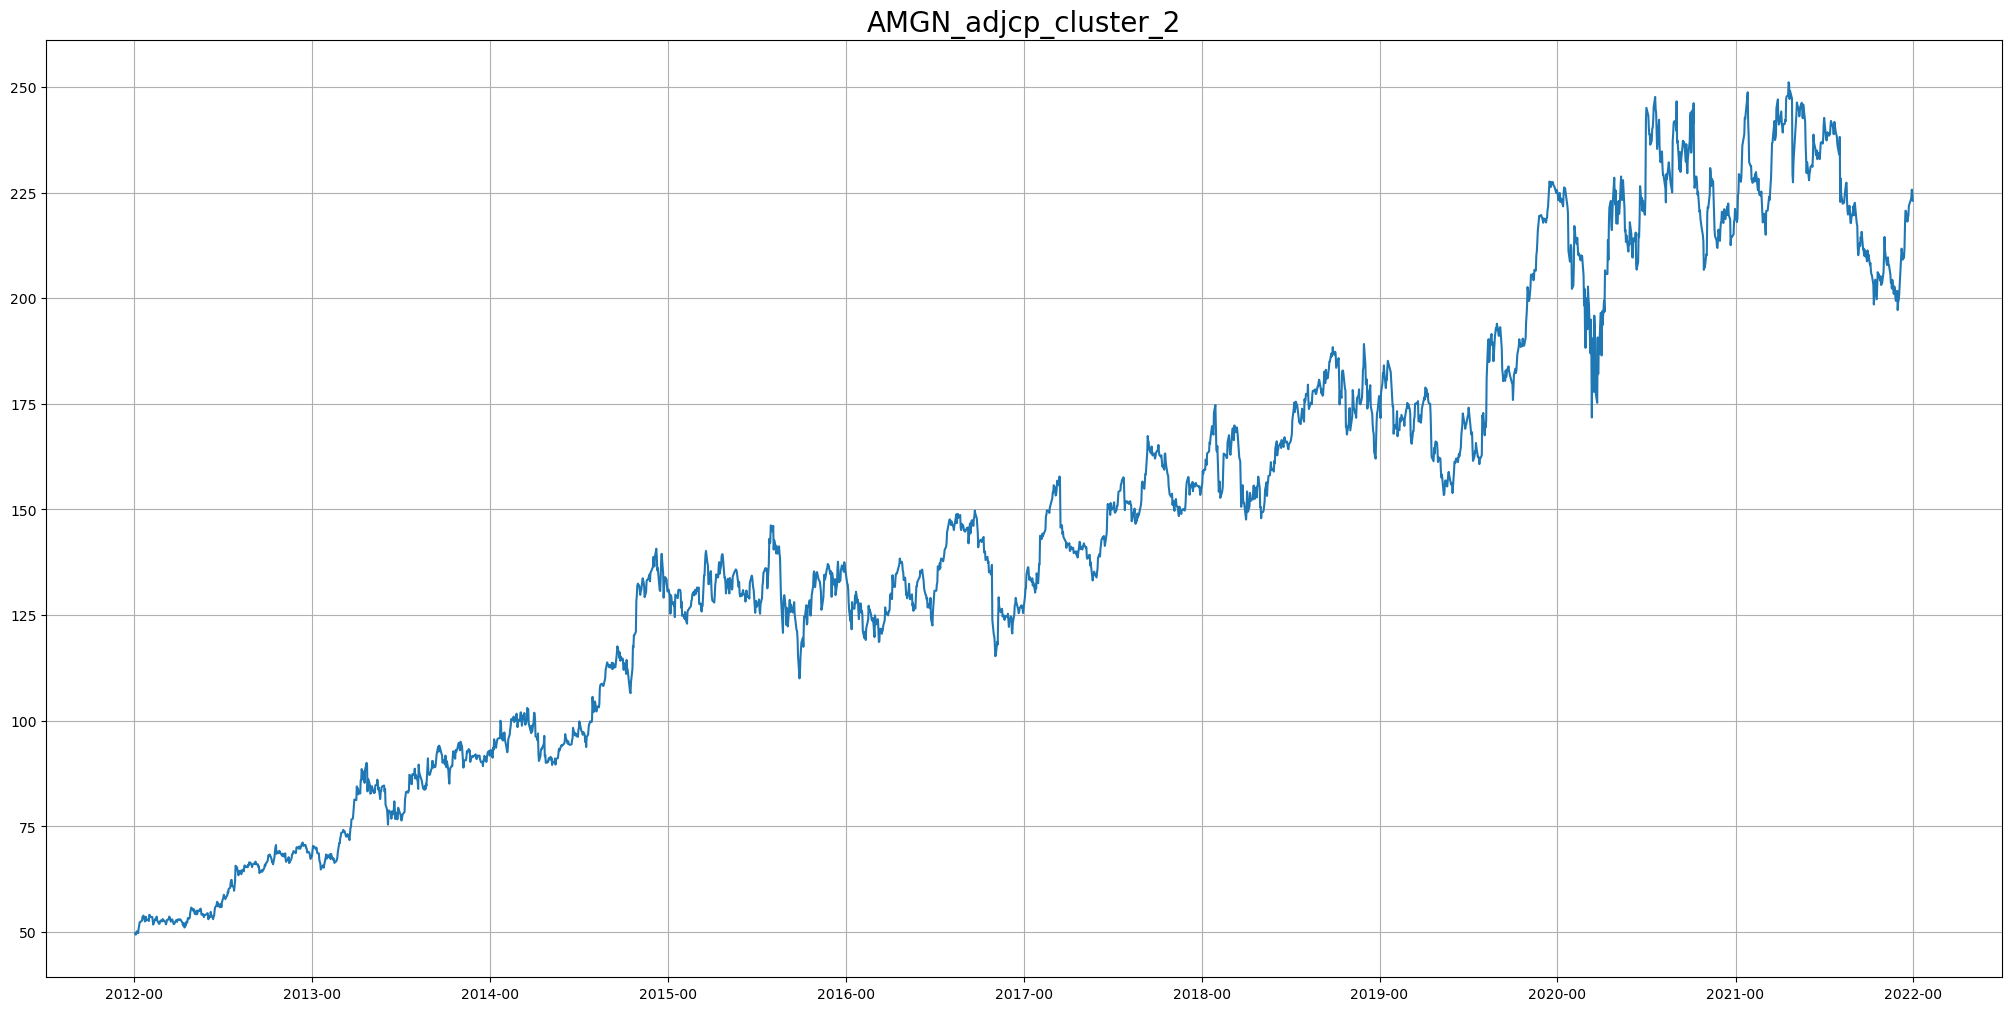

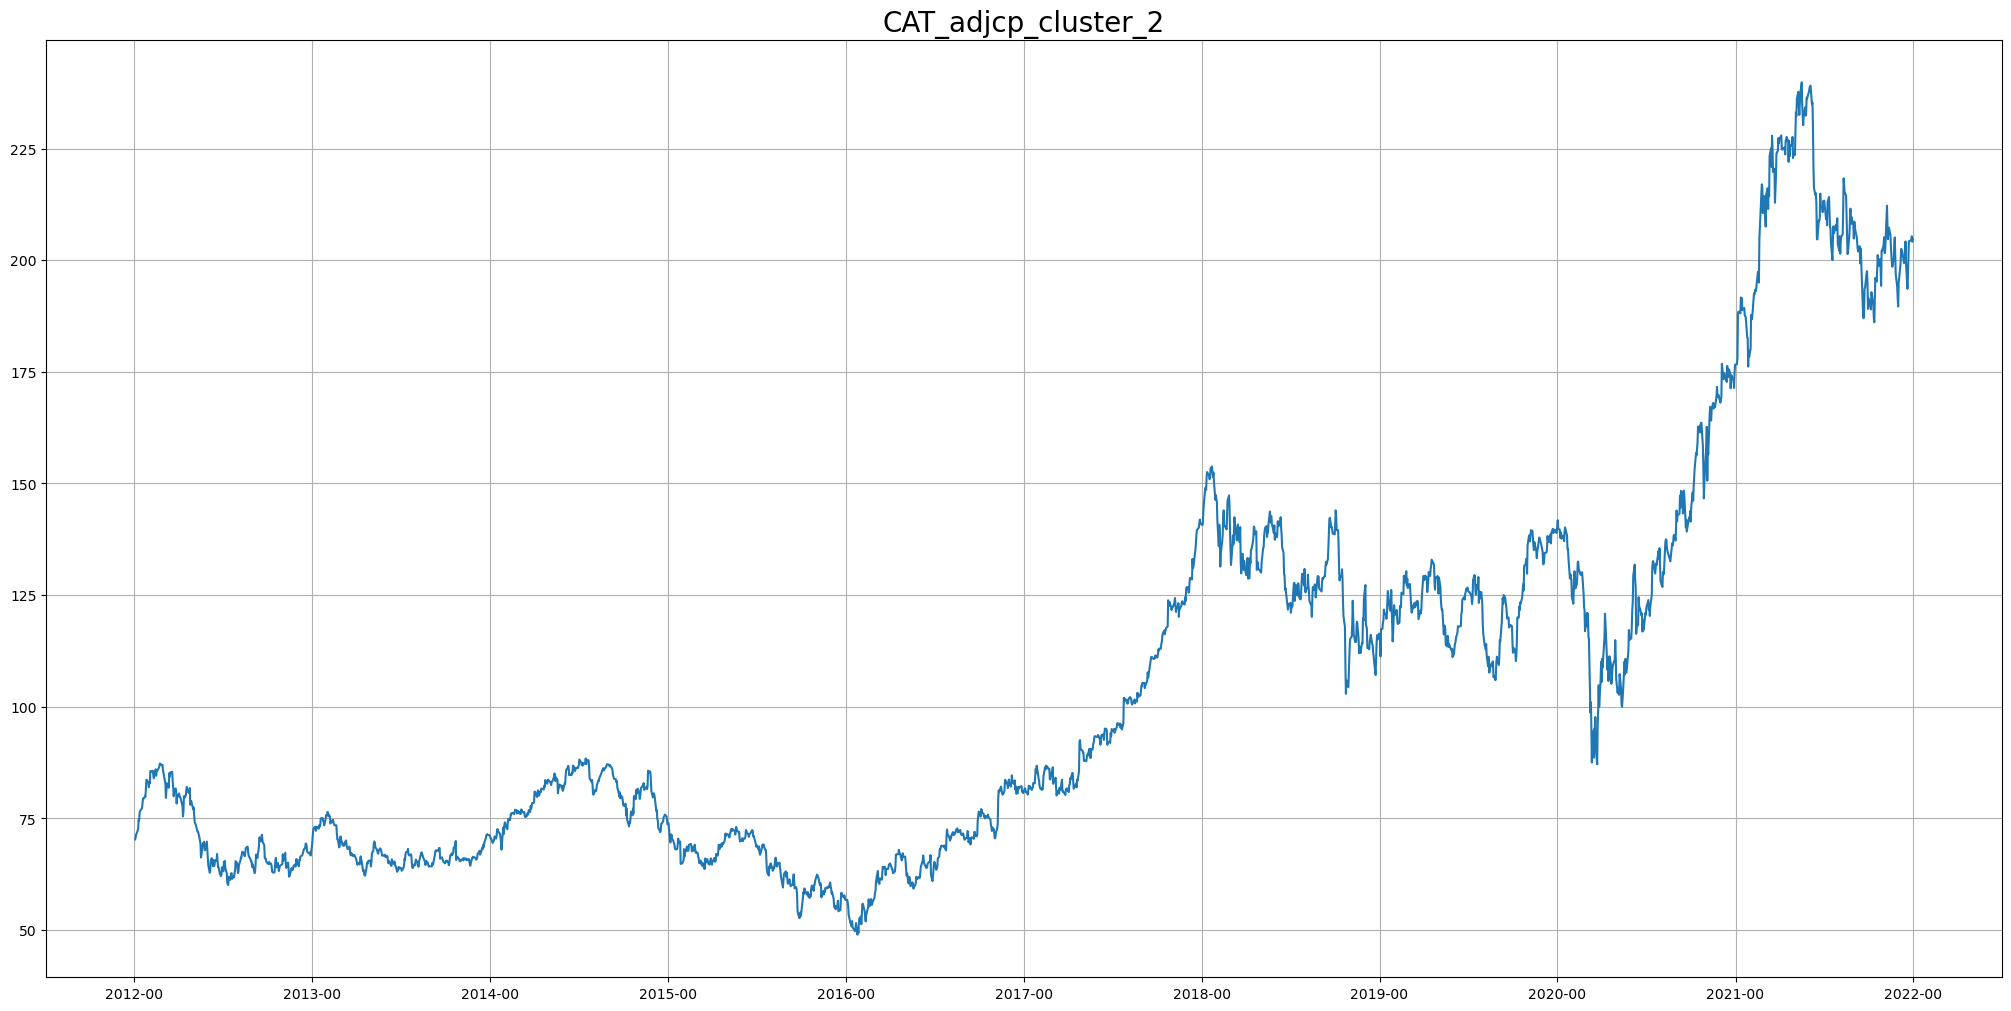

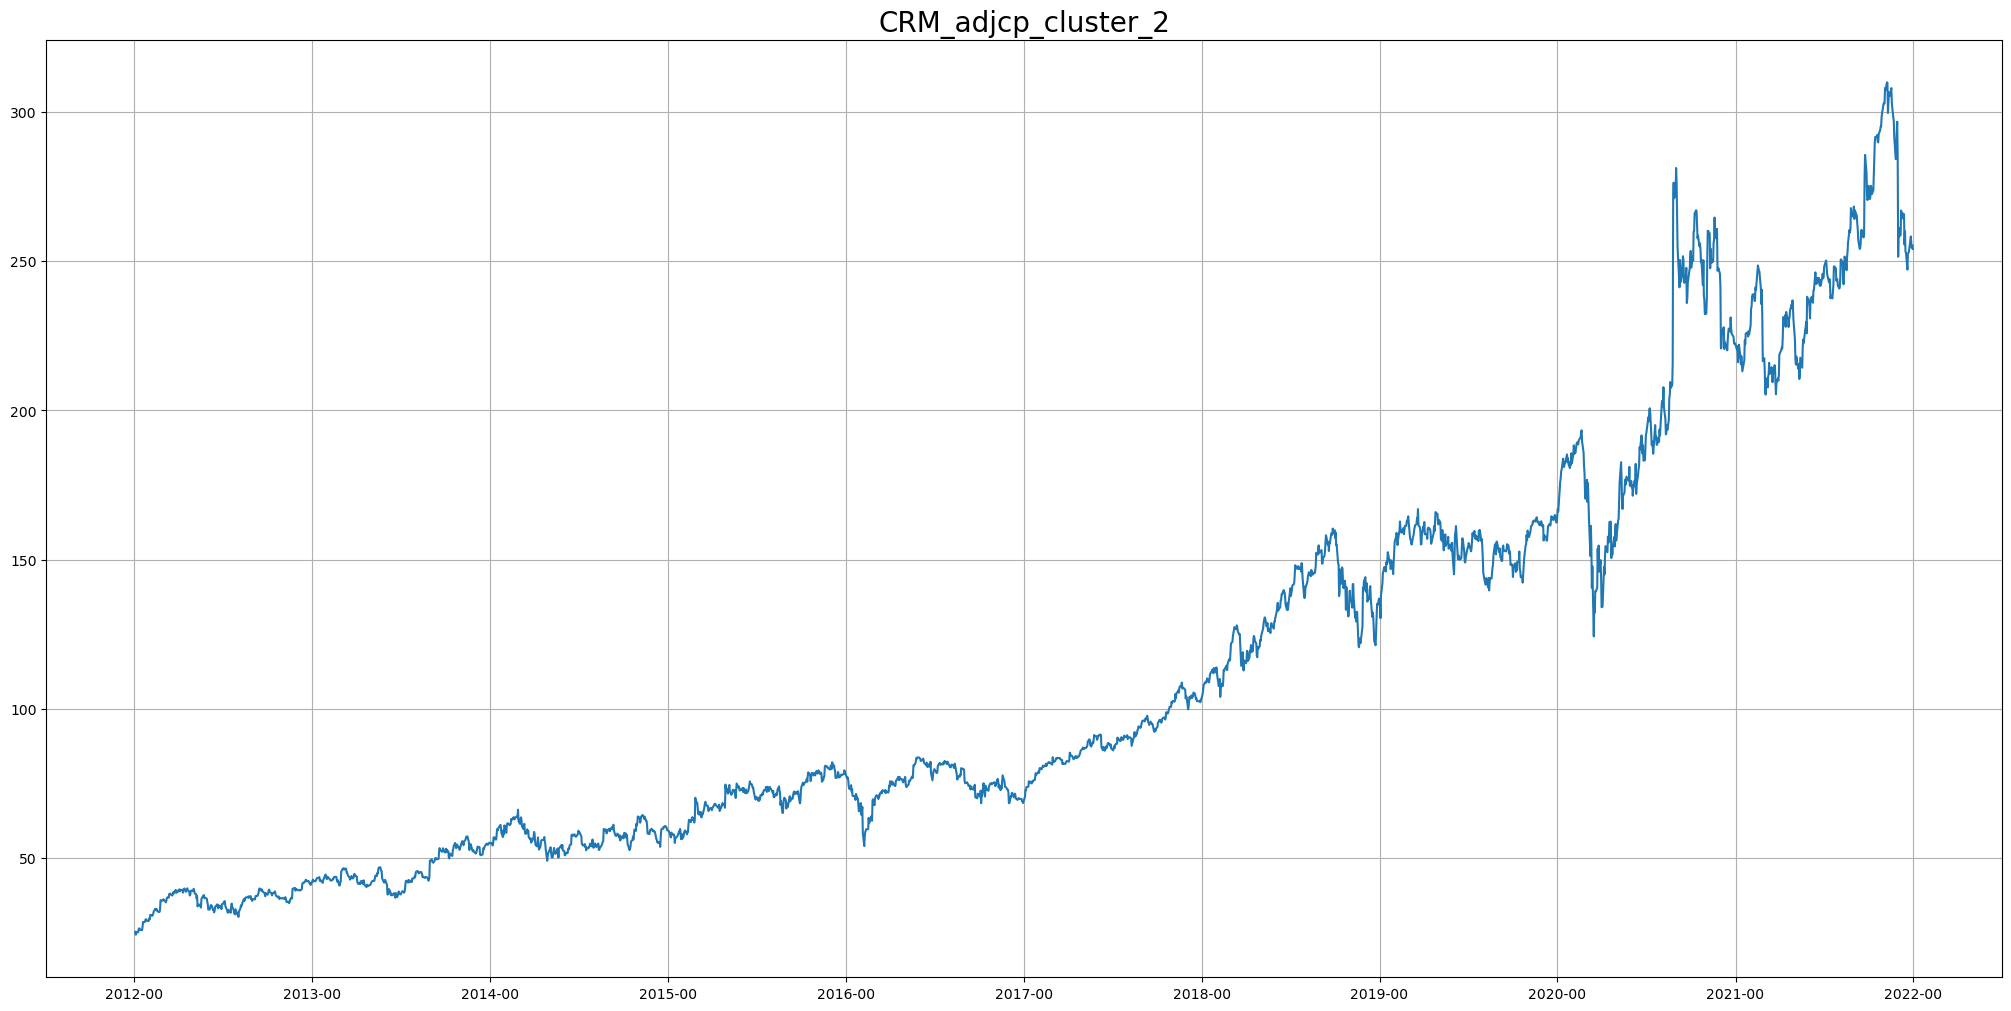

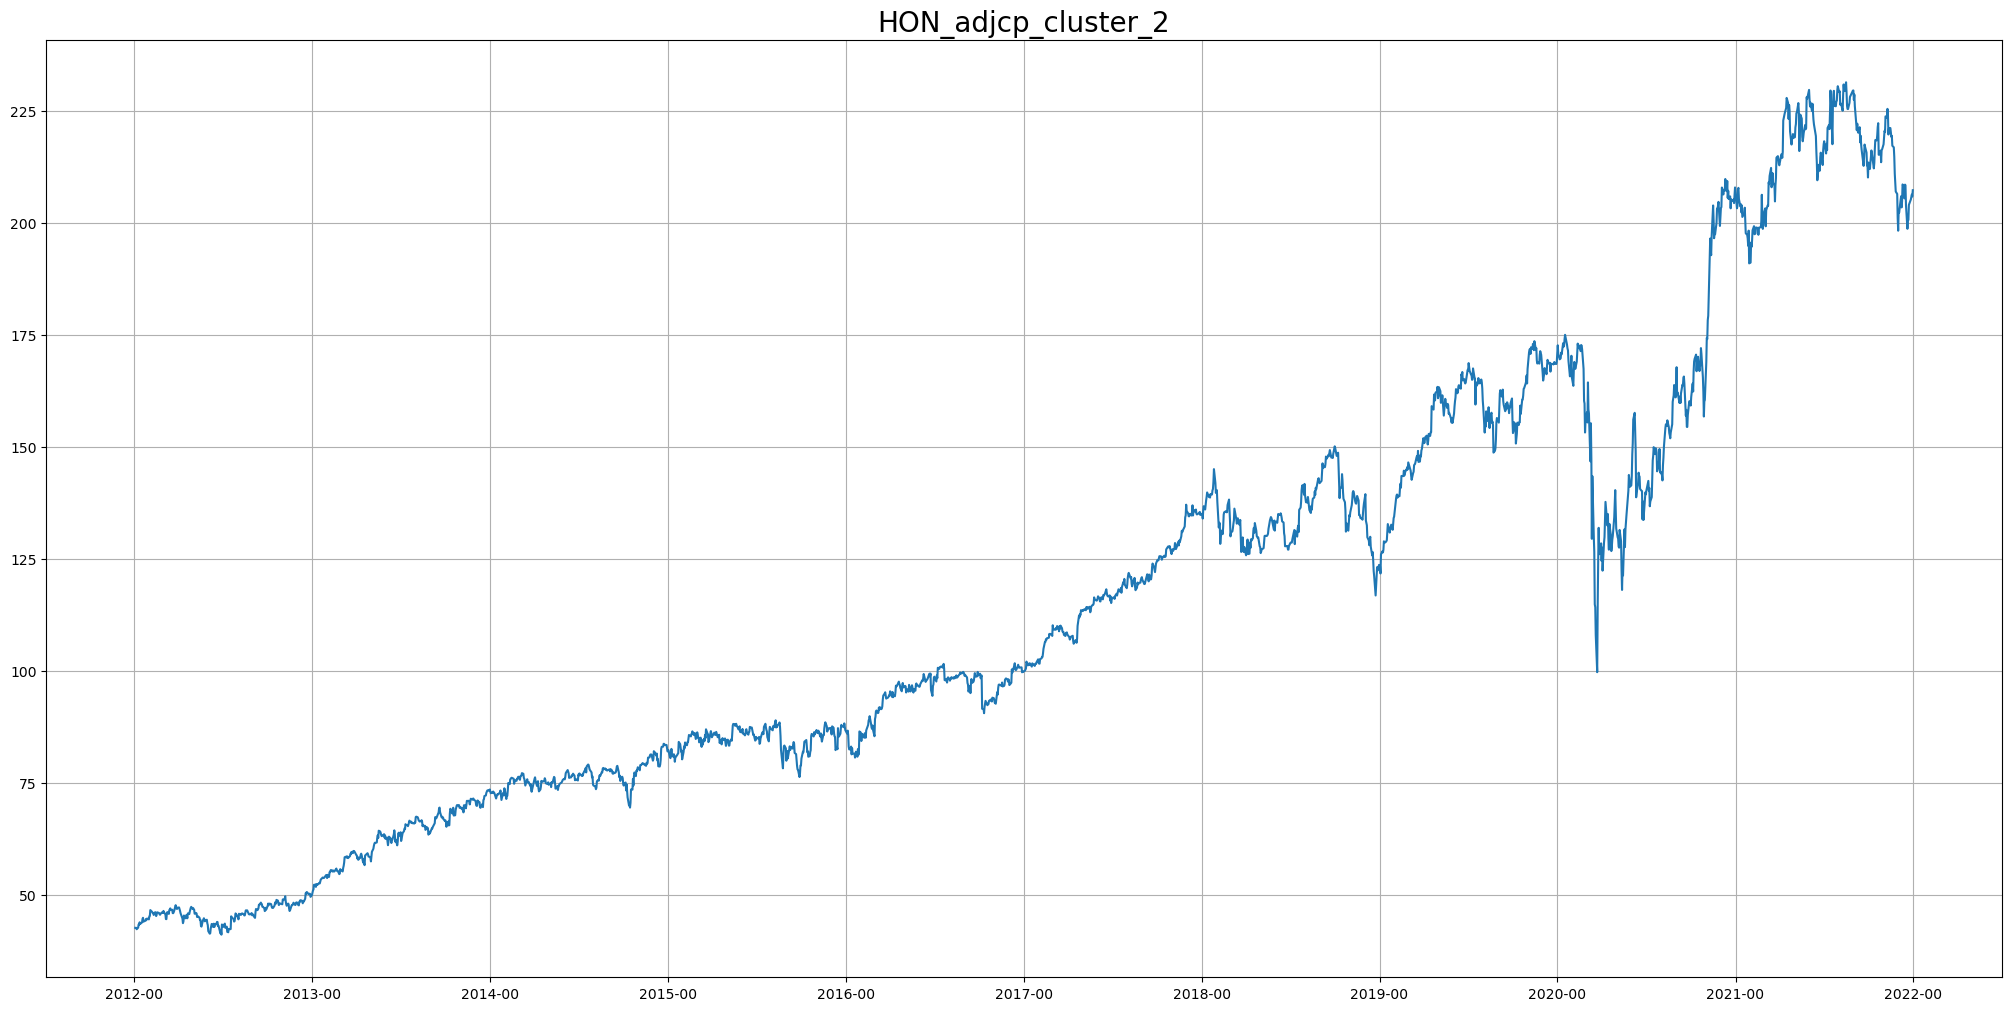

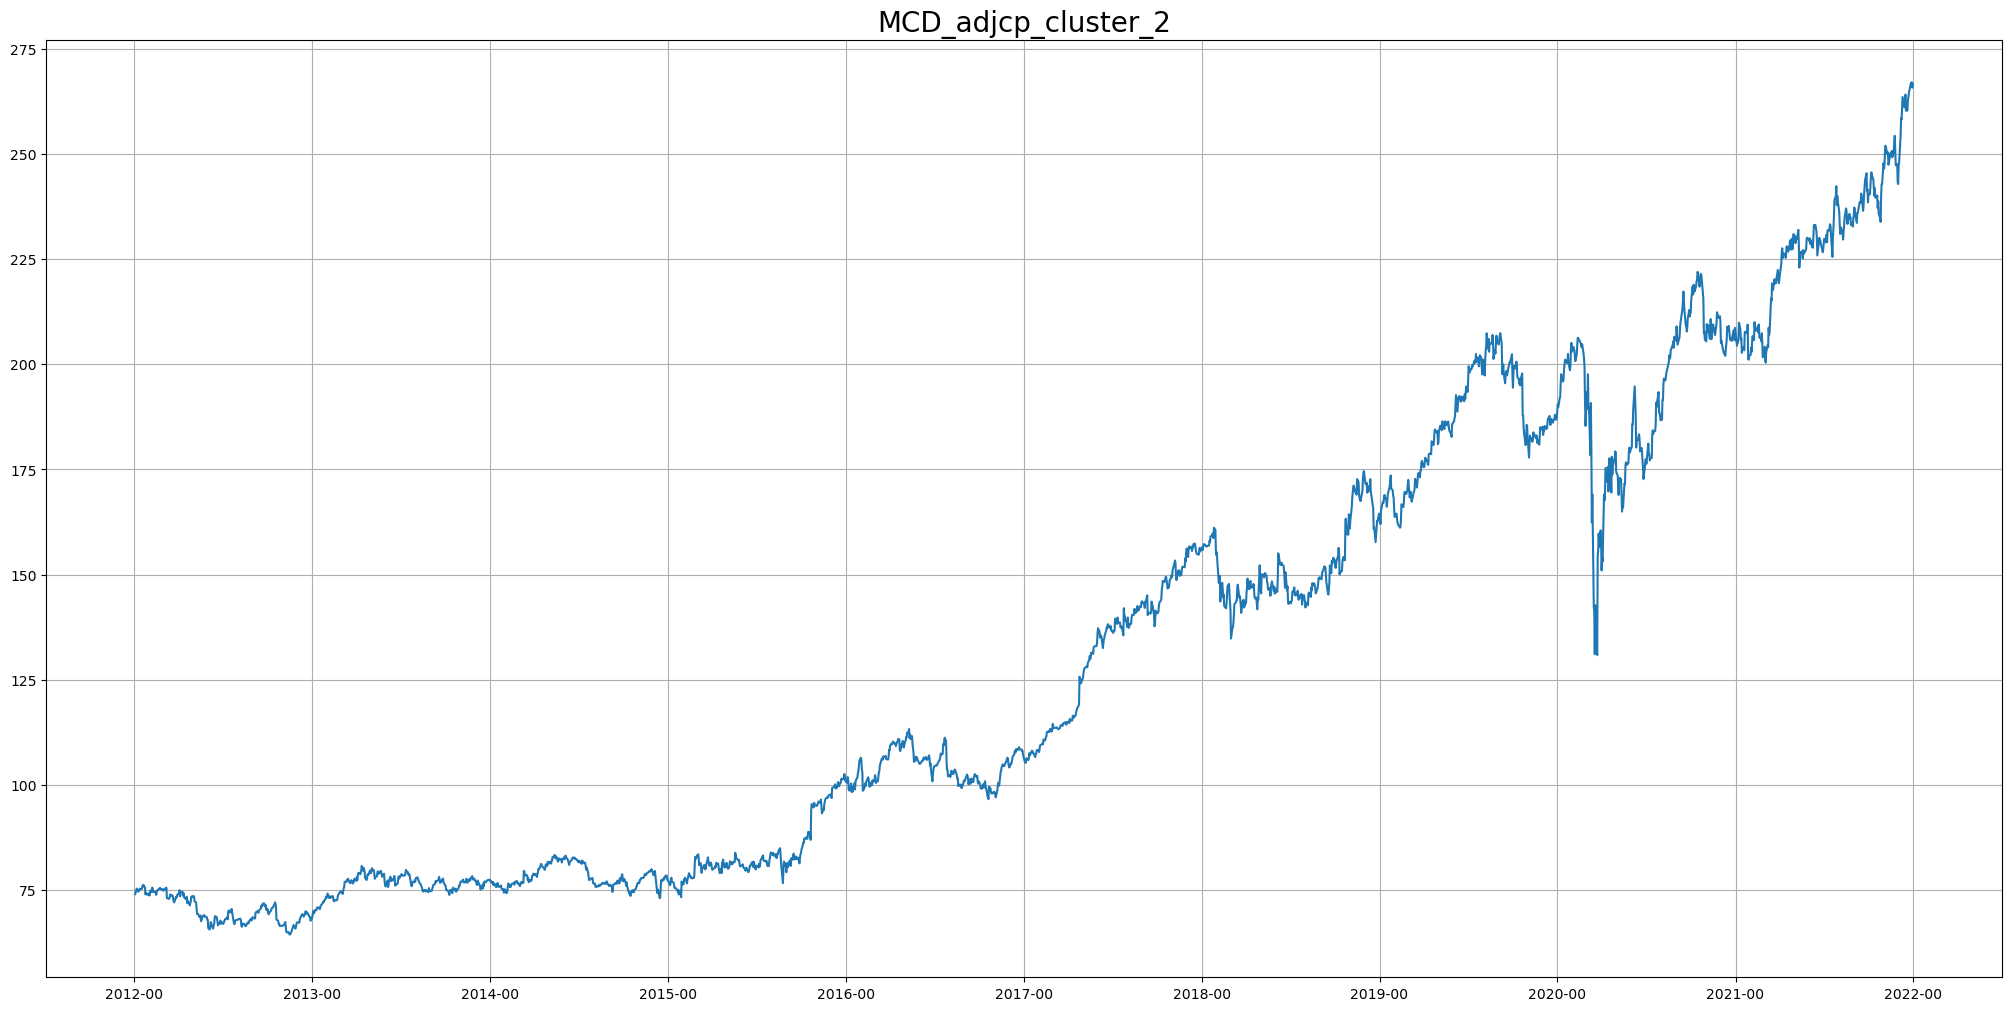

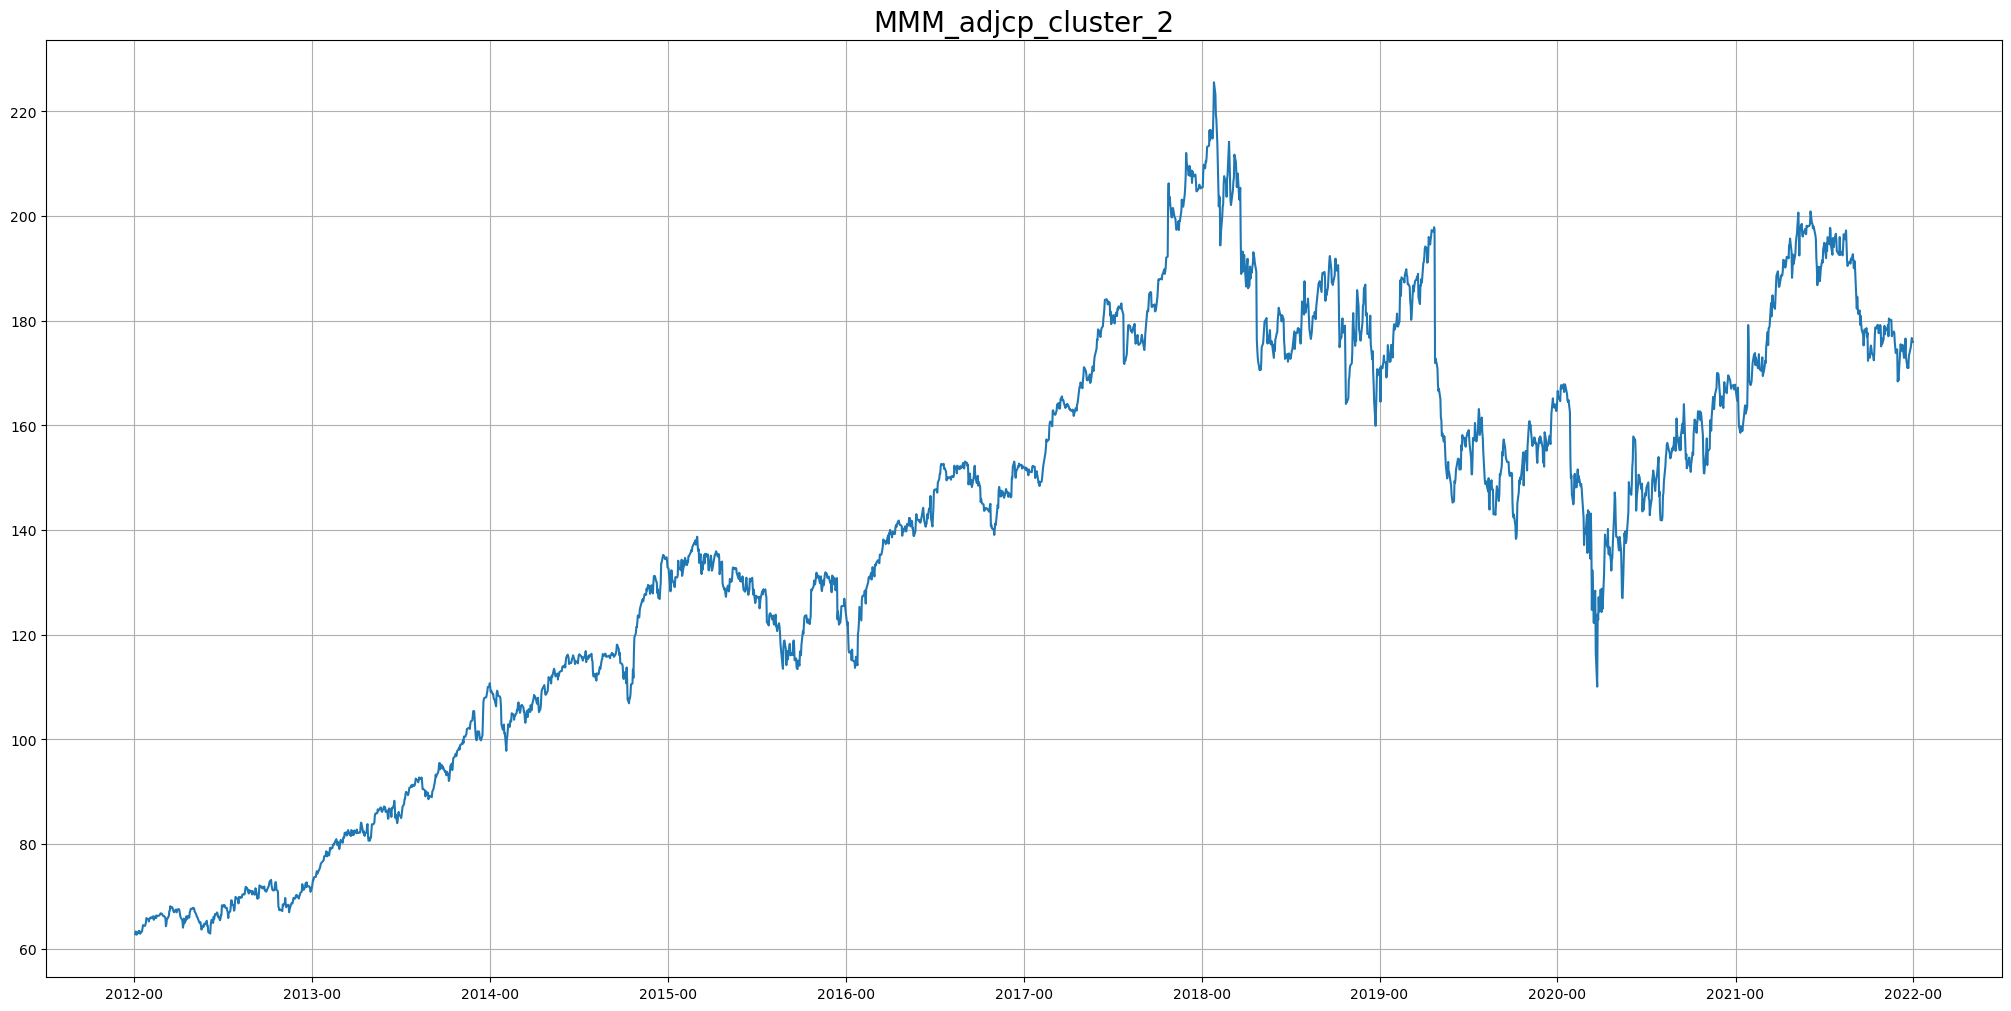

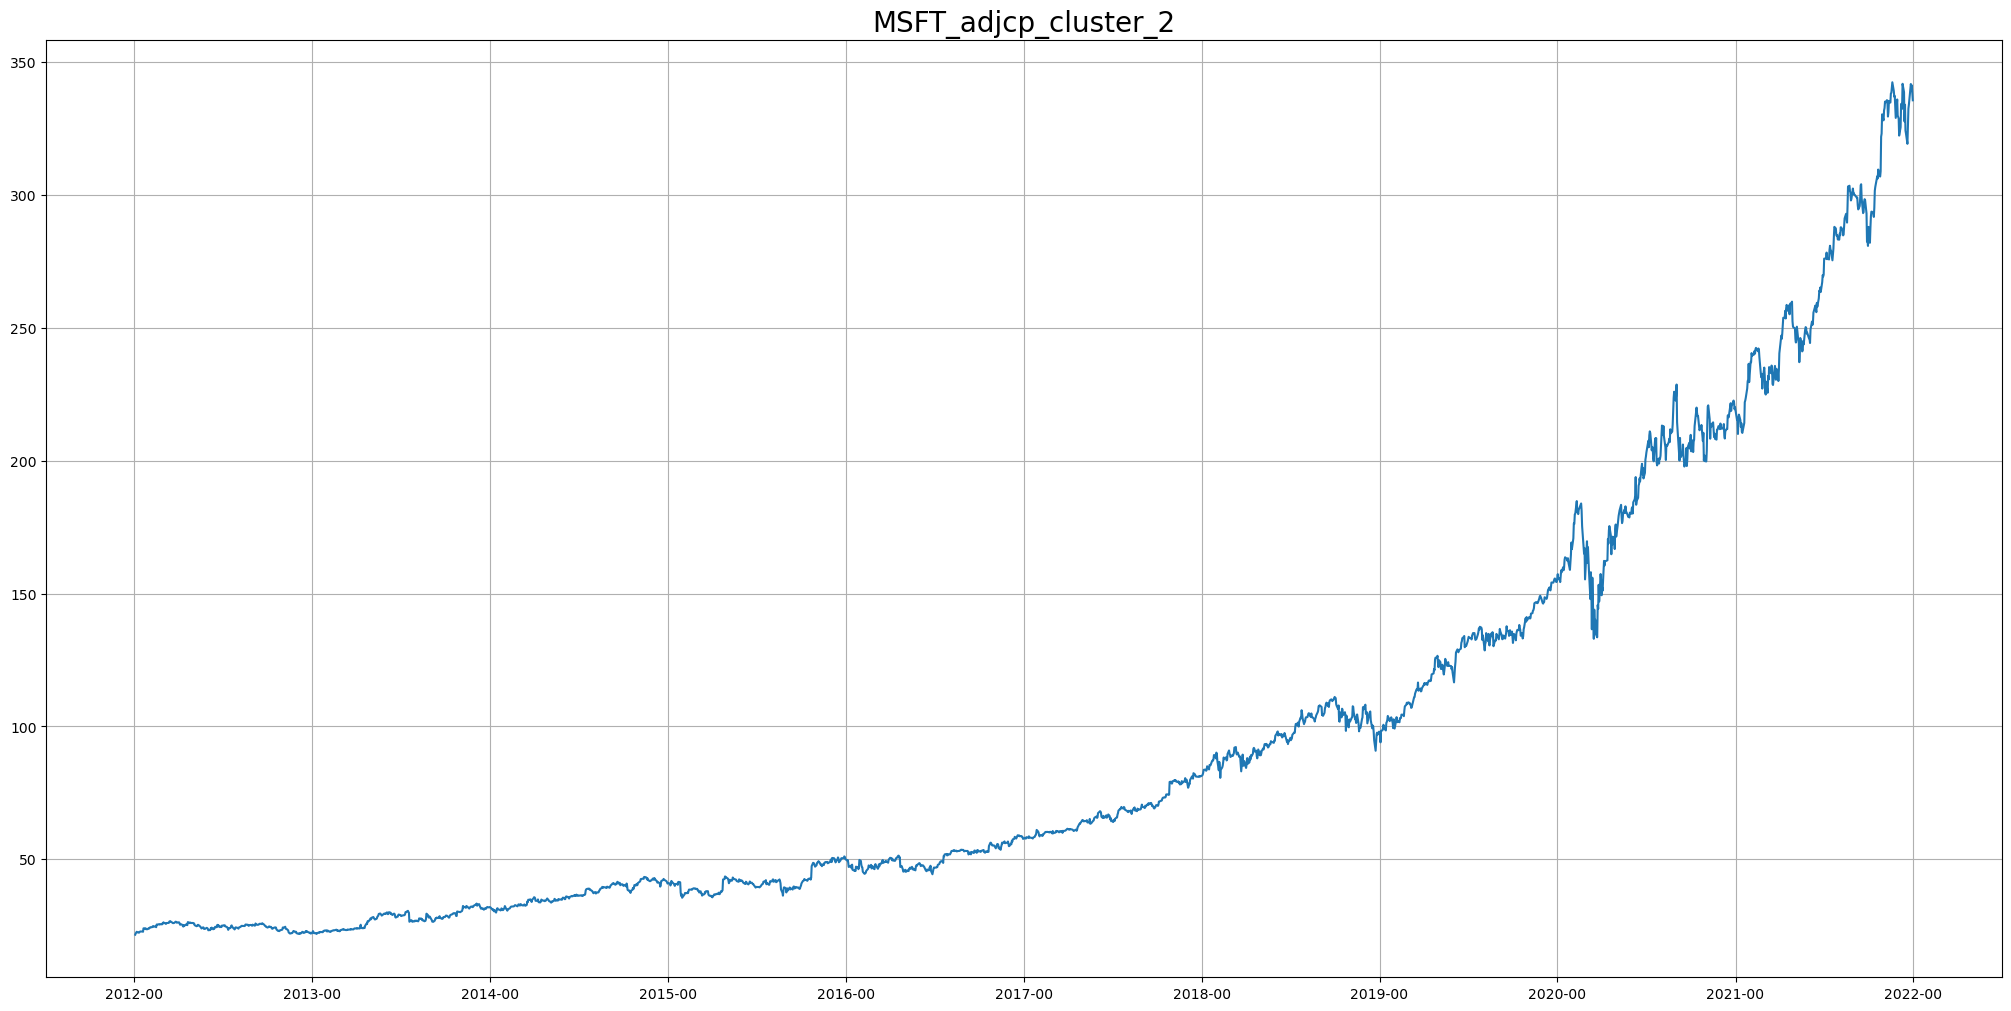

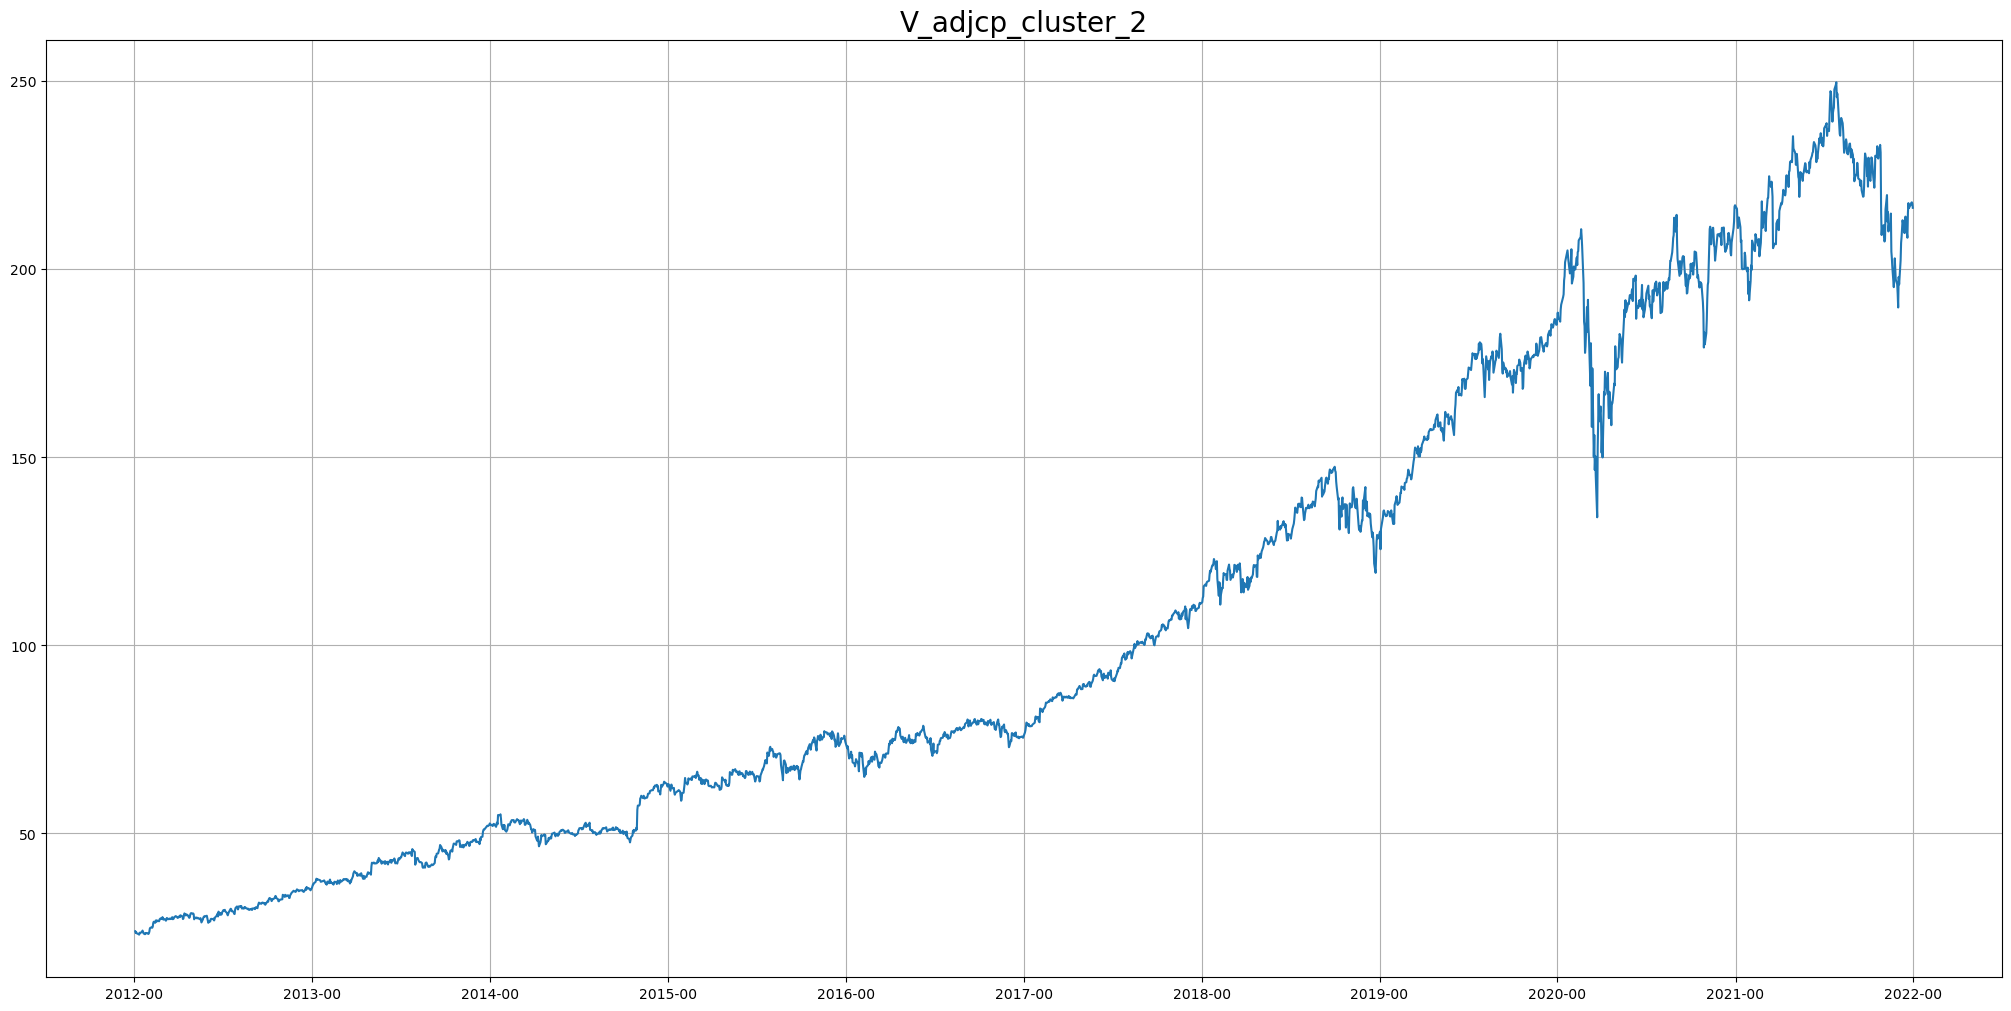

This is cluster 3


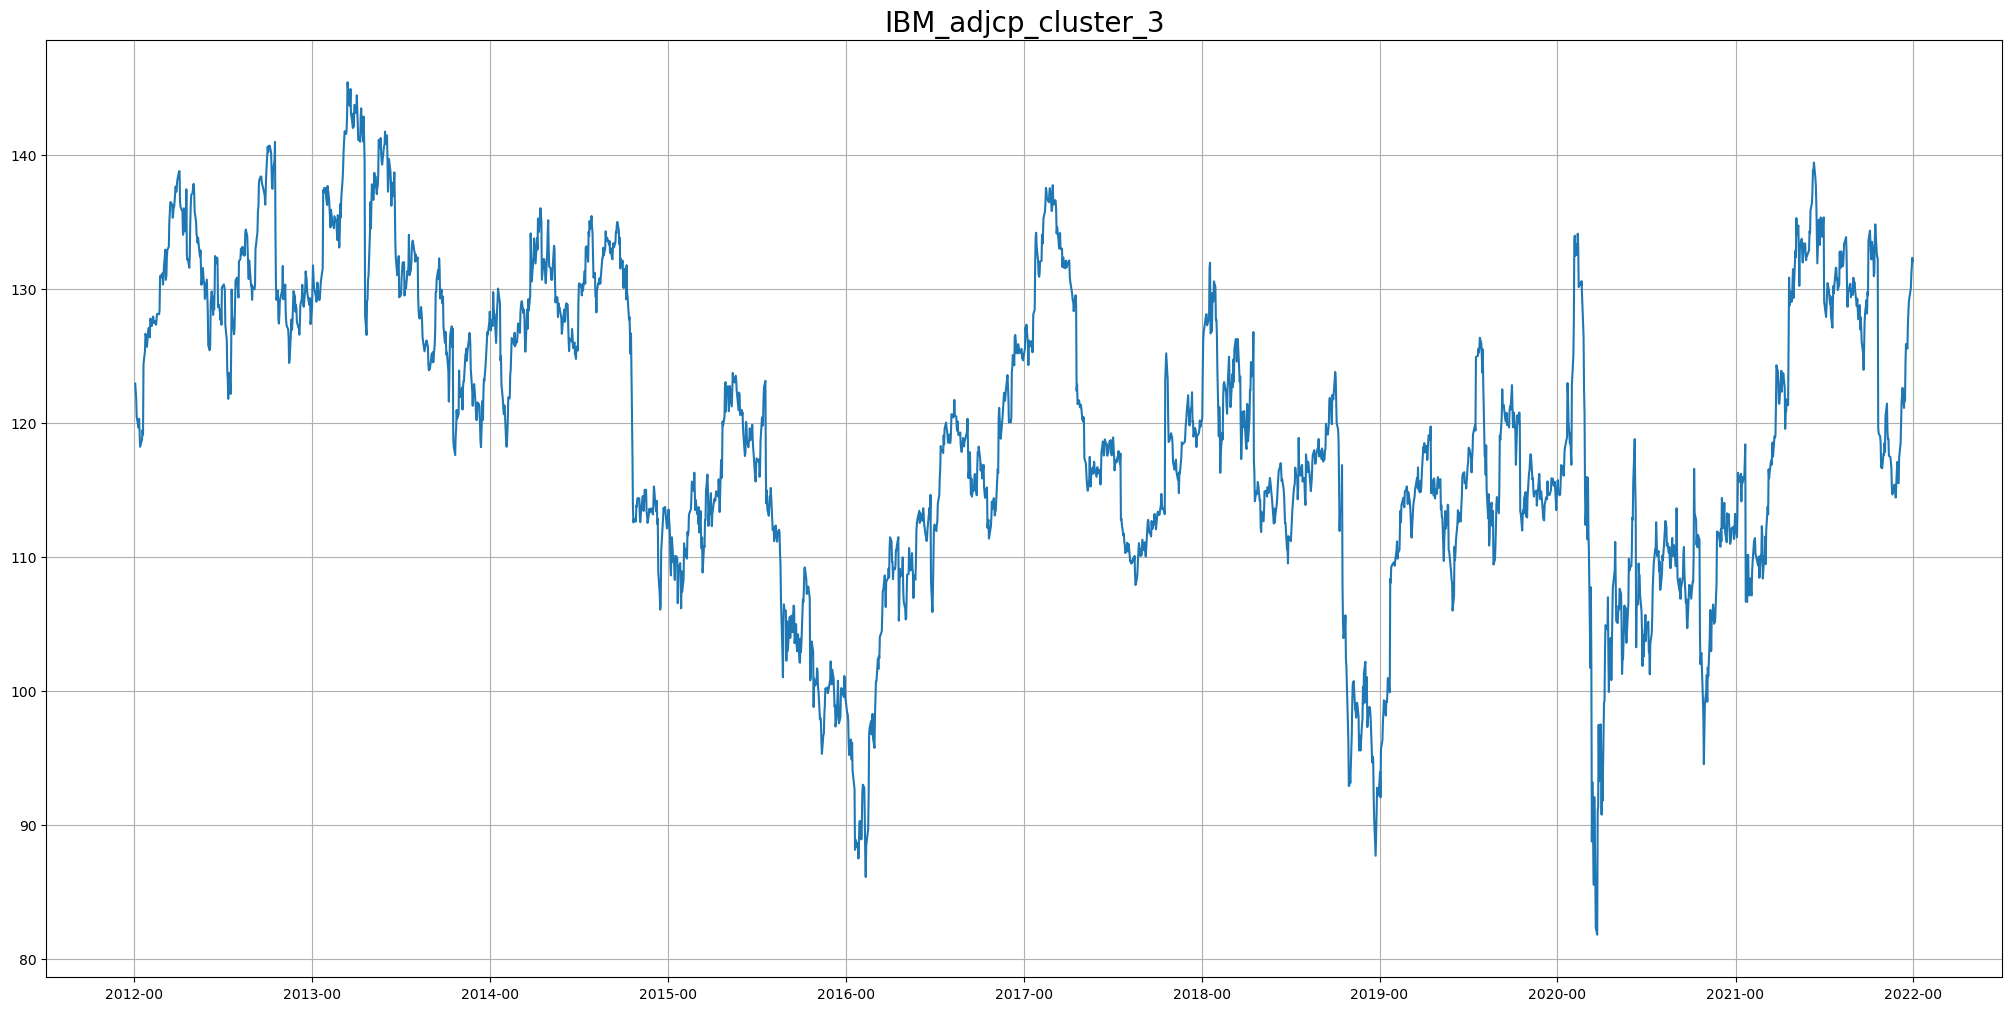

This is cluster 4


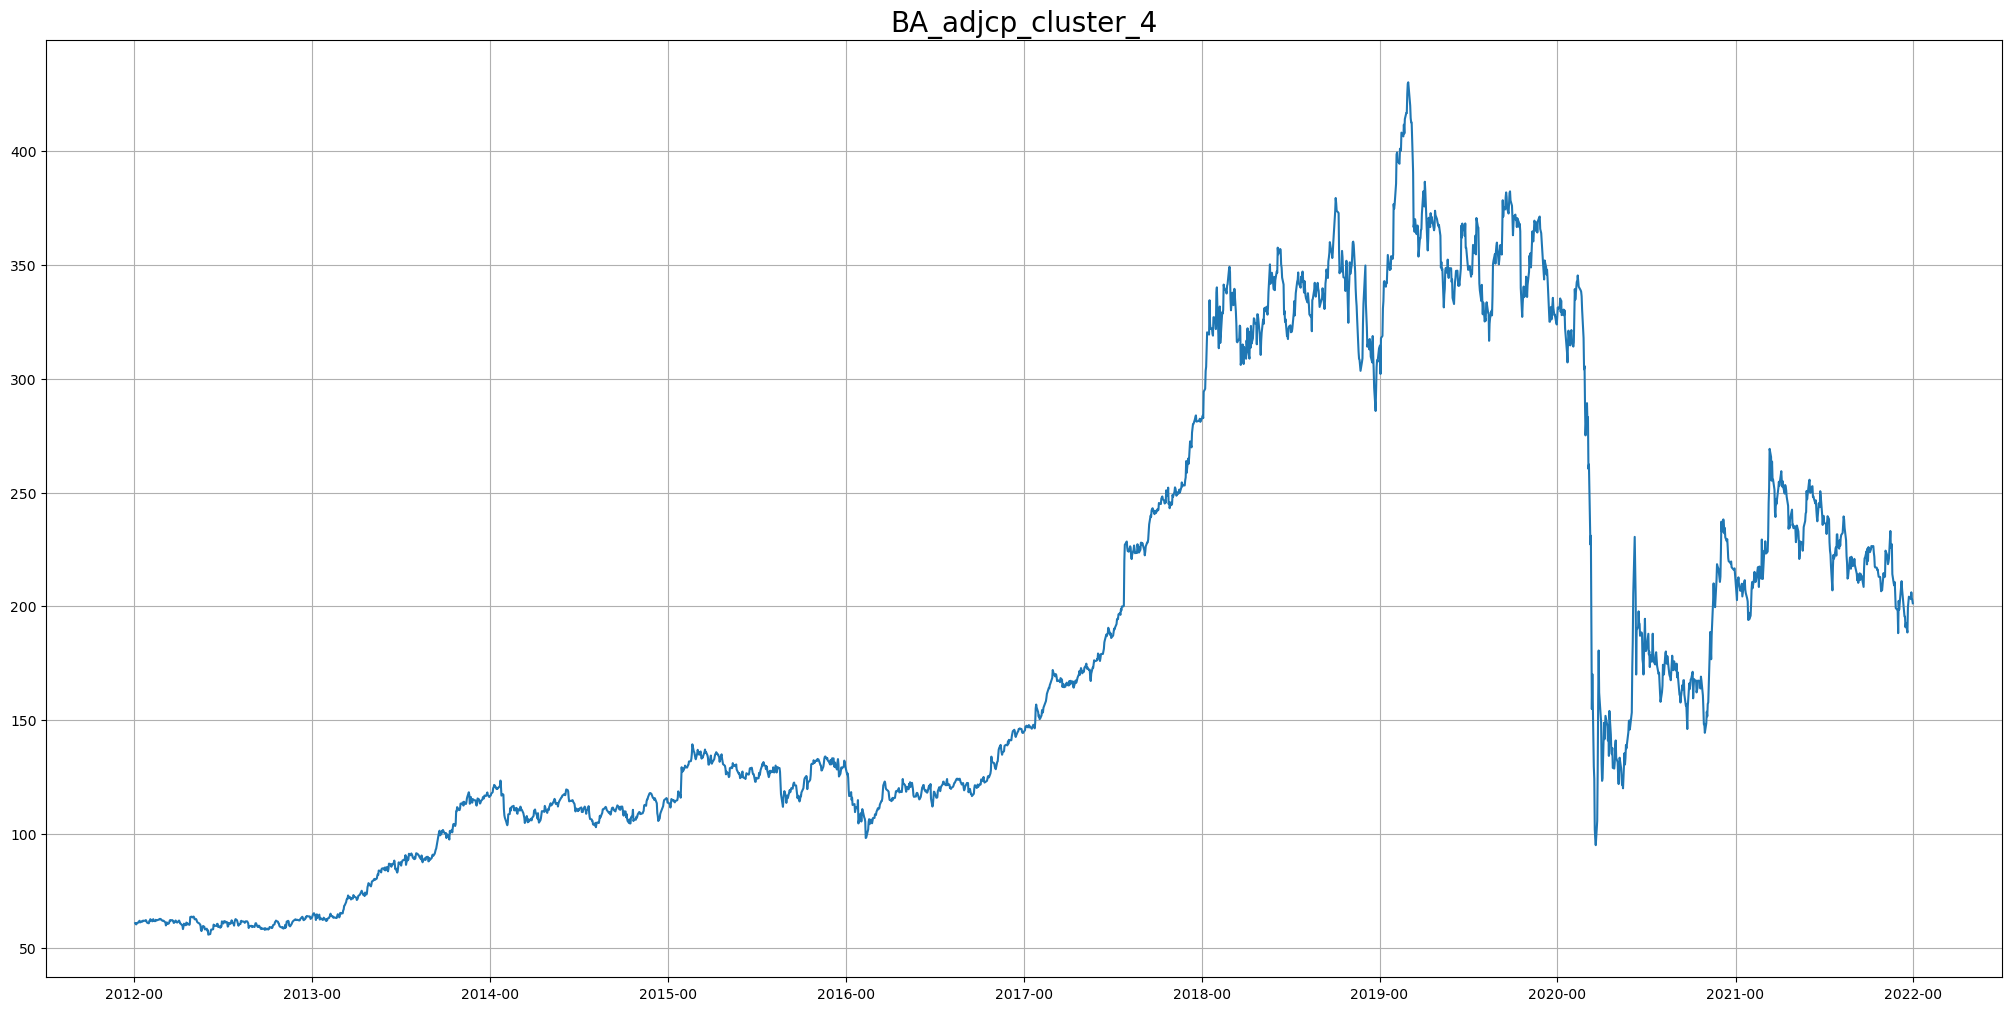

This is cluster 5


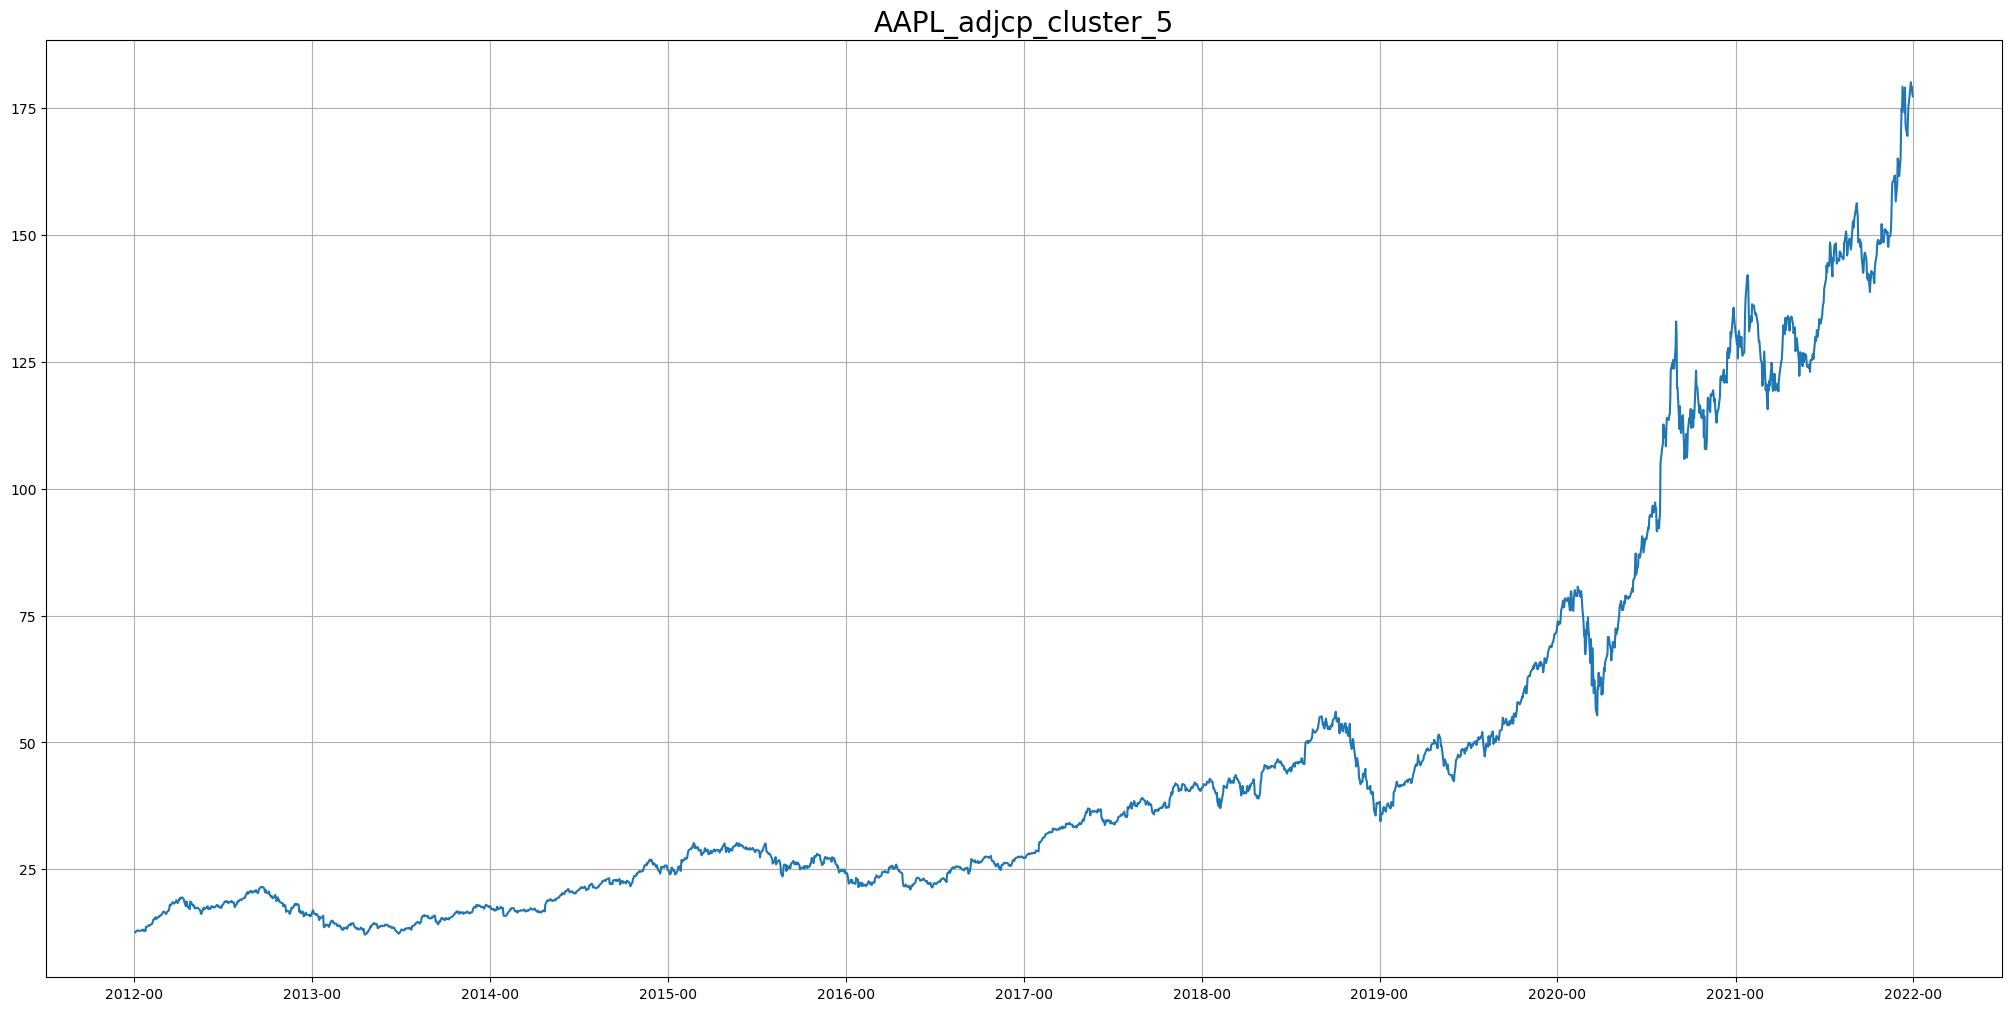

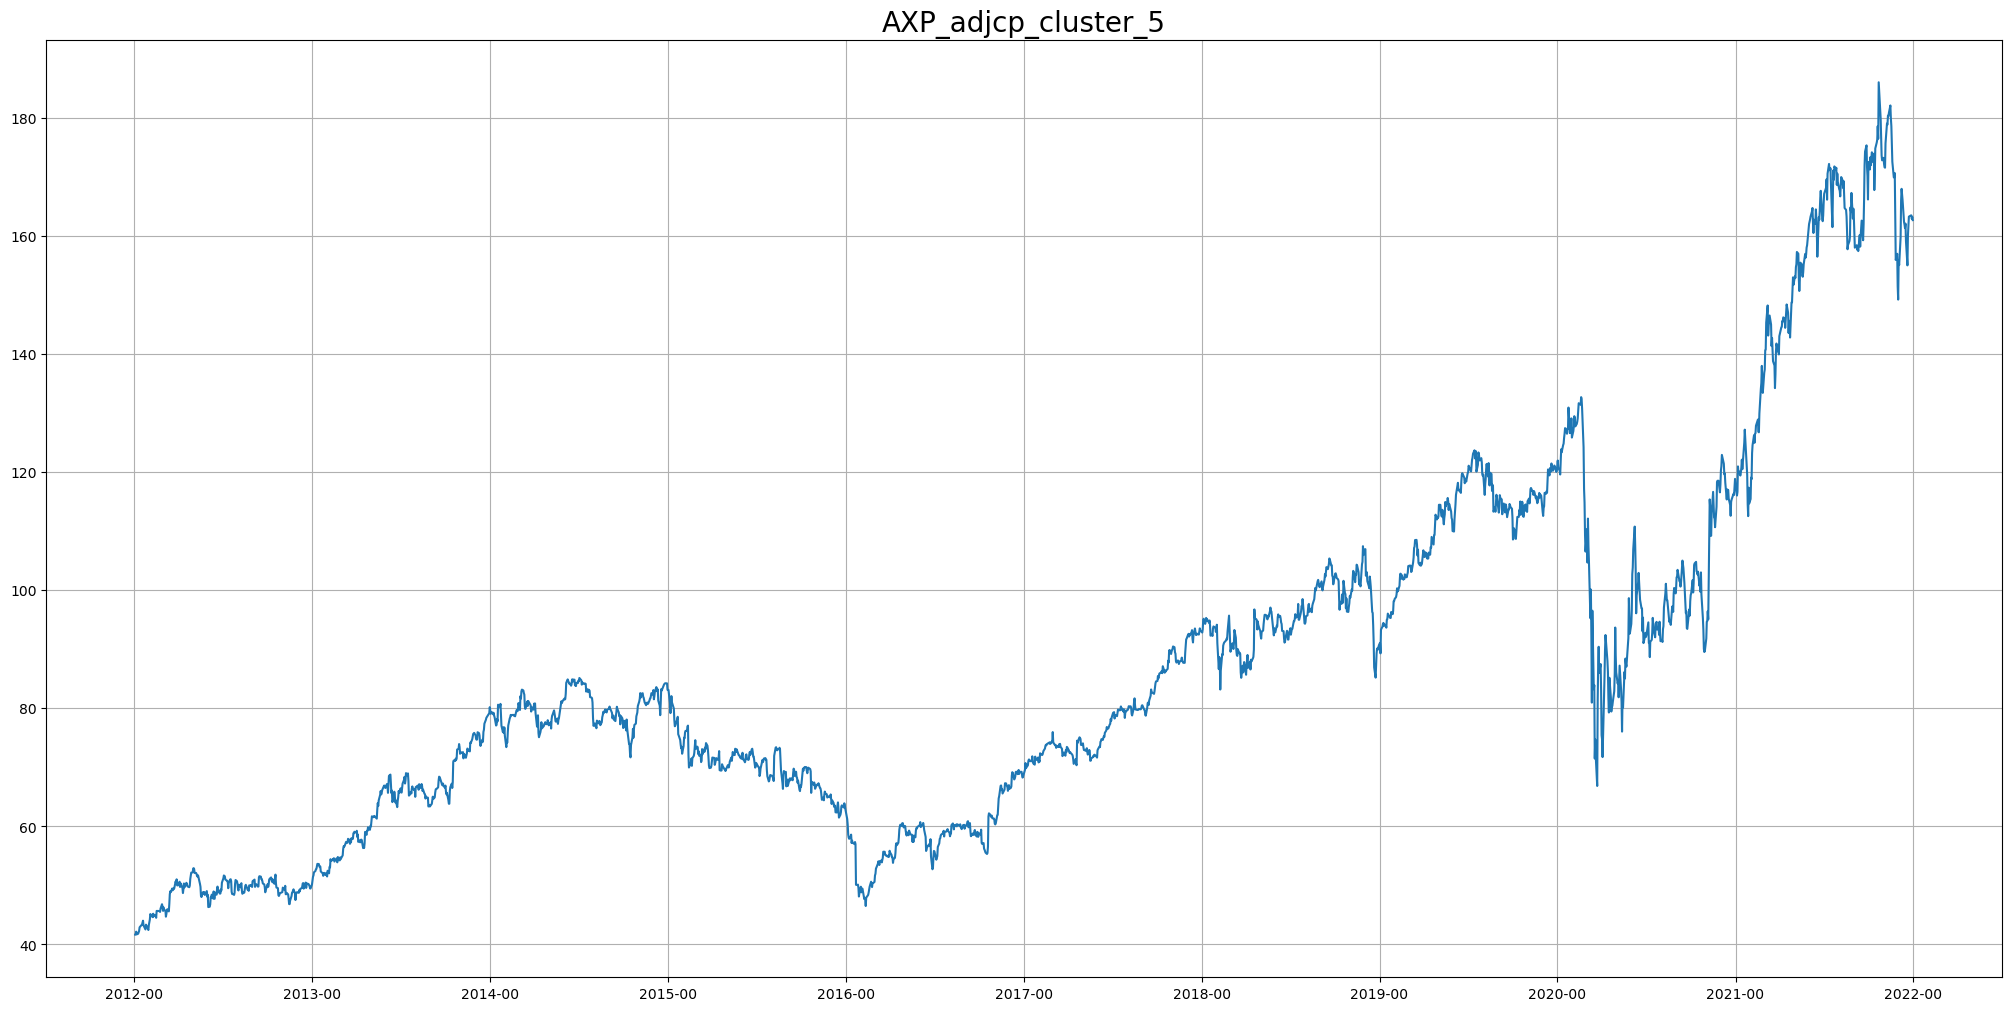

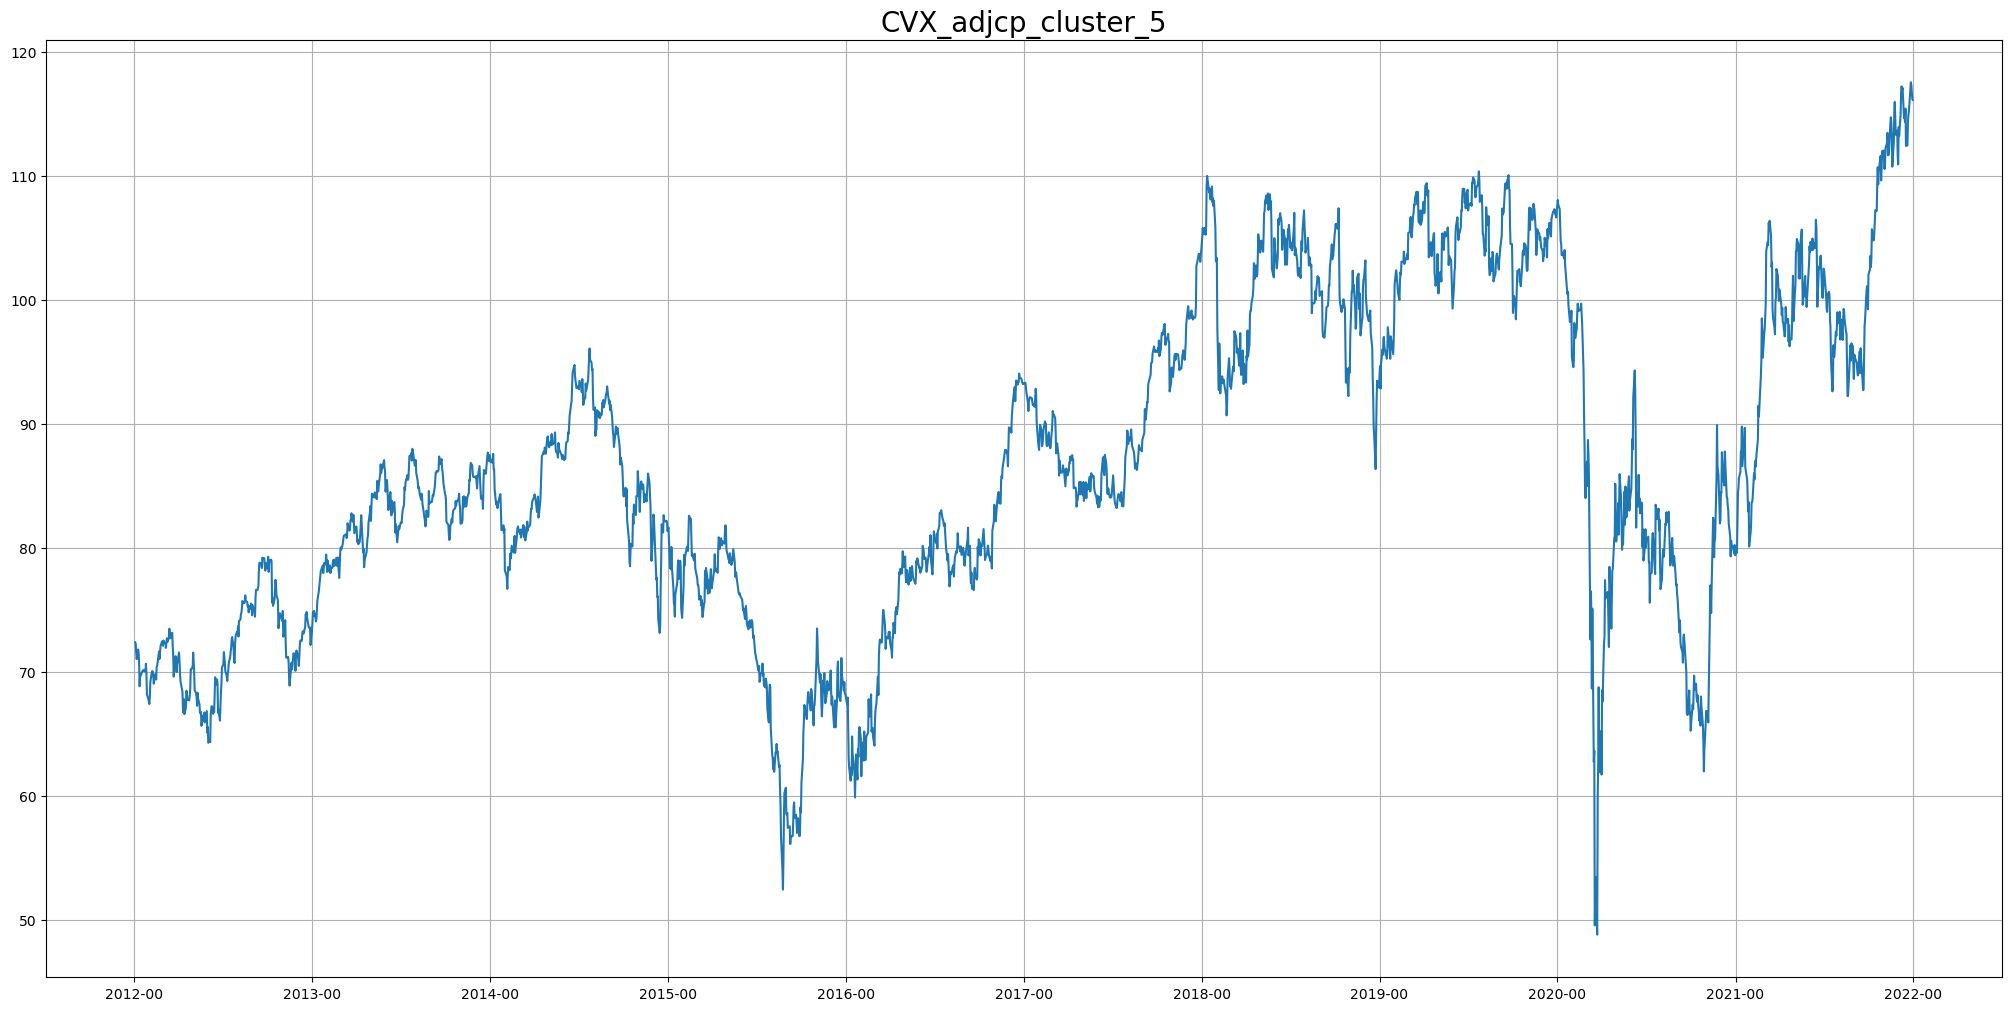

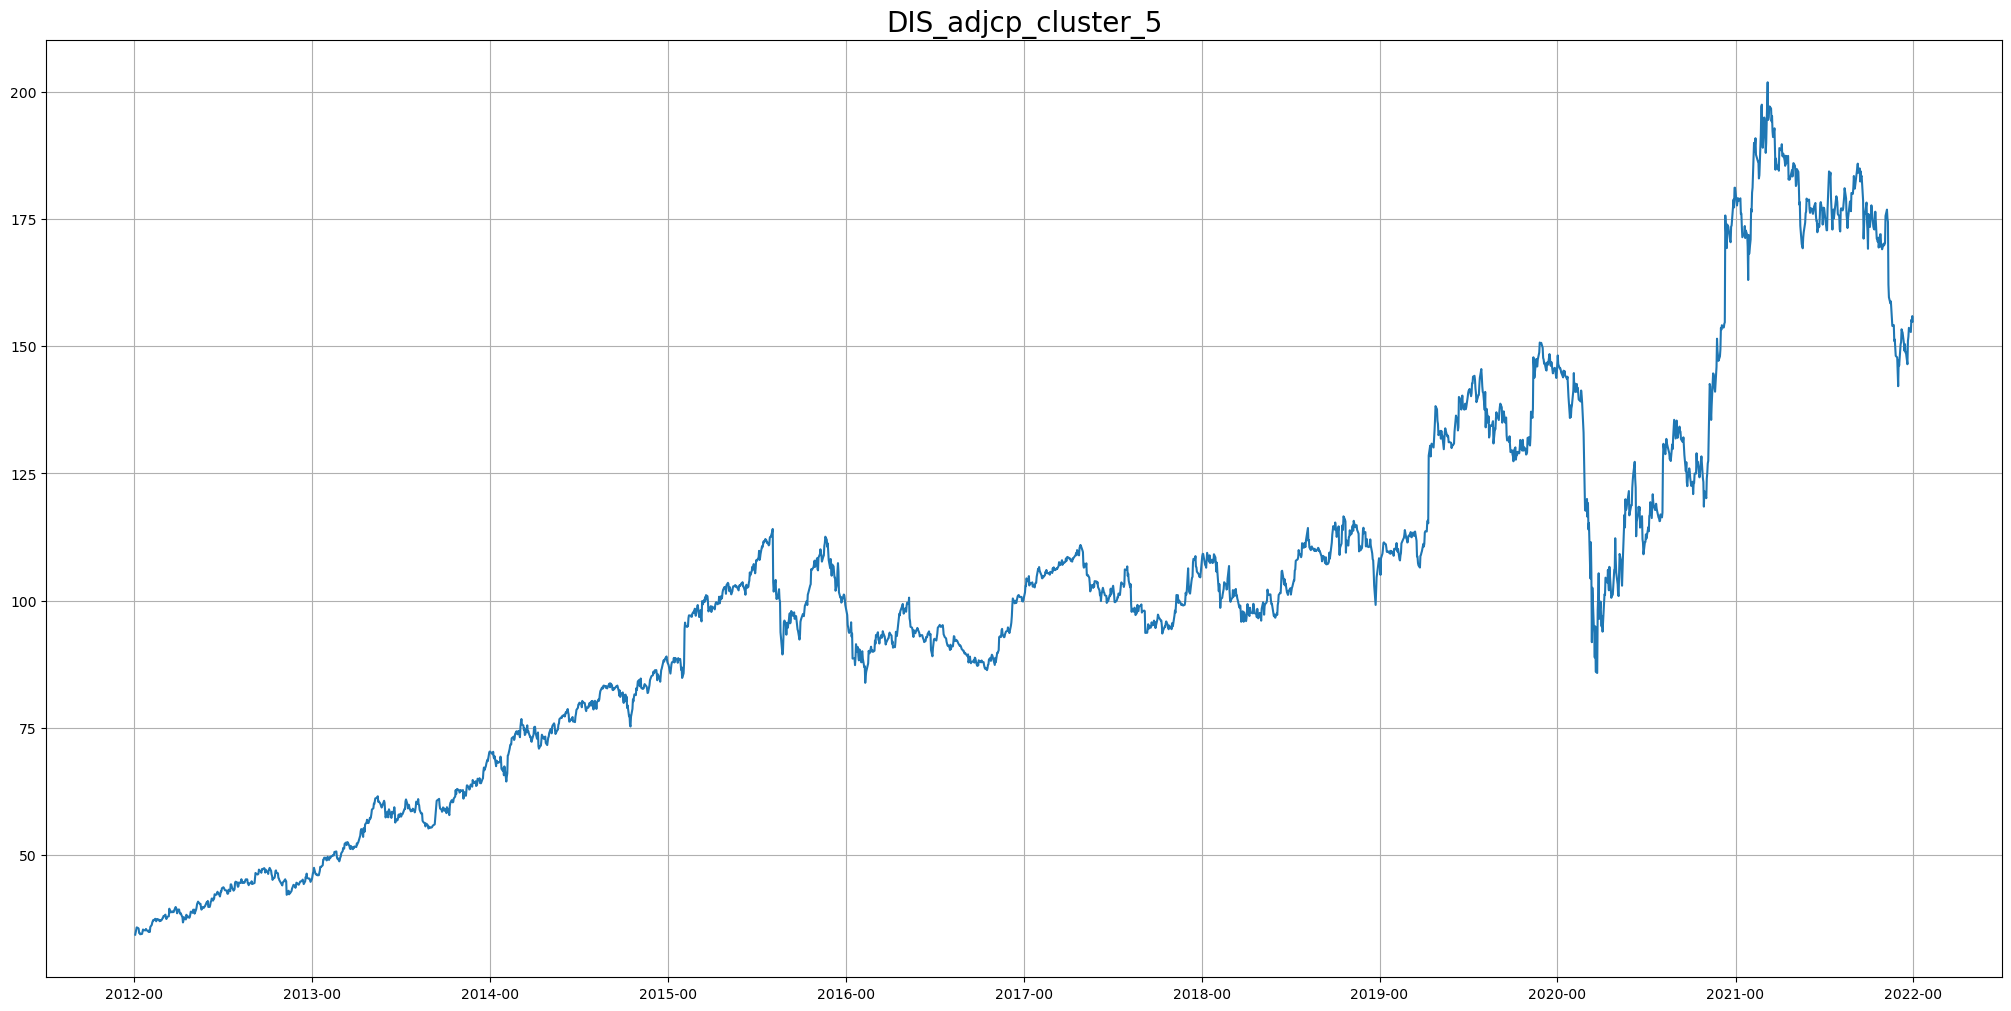

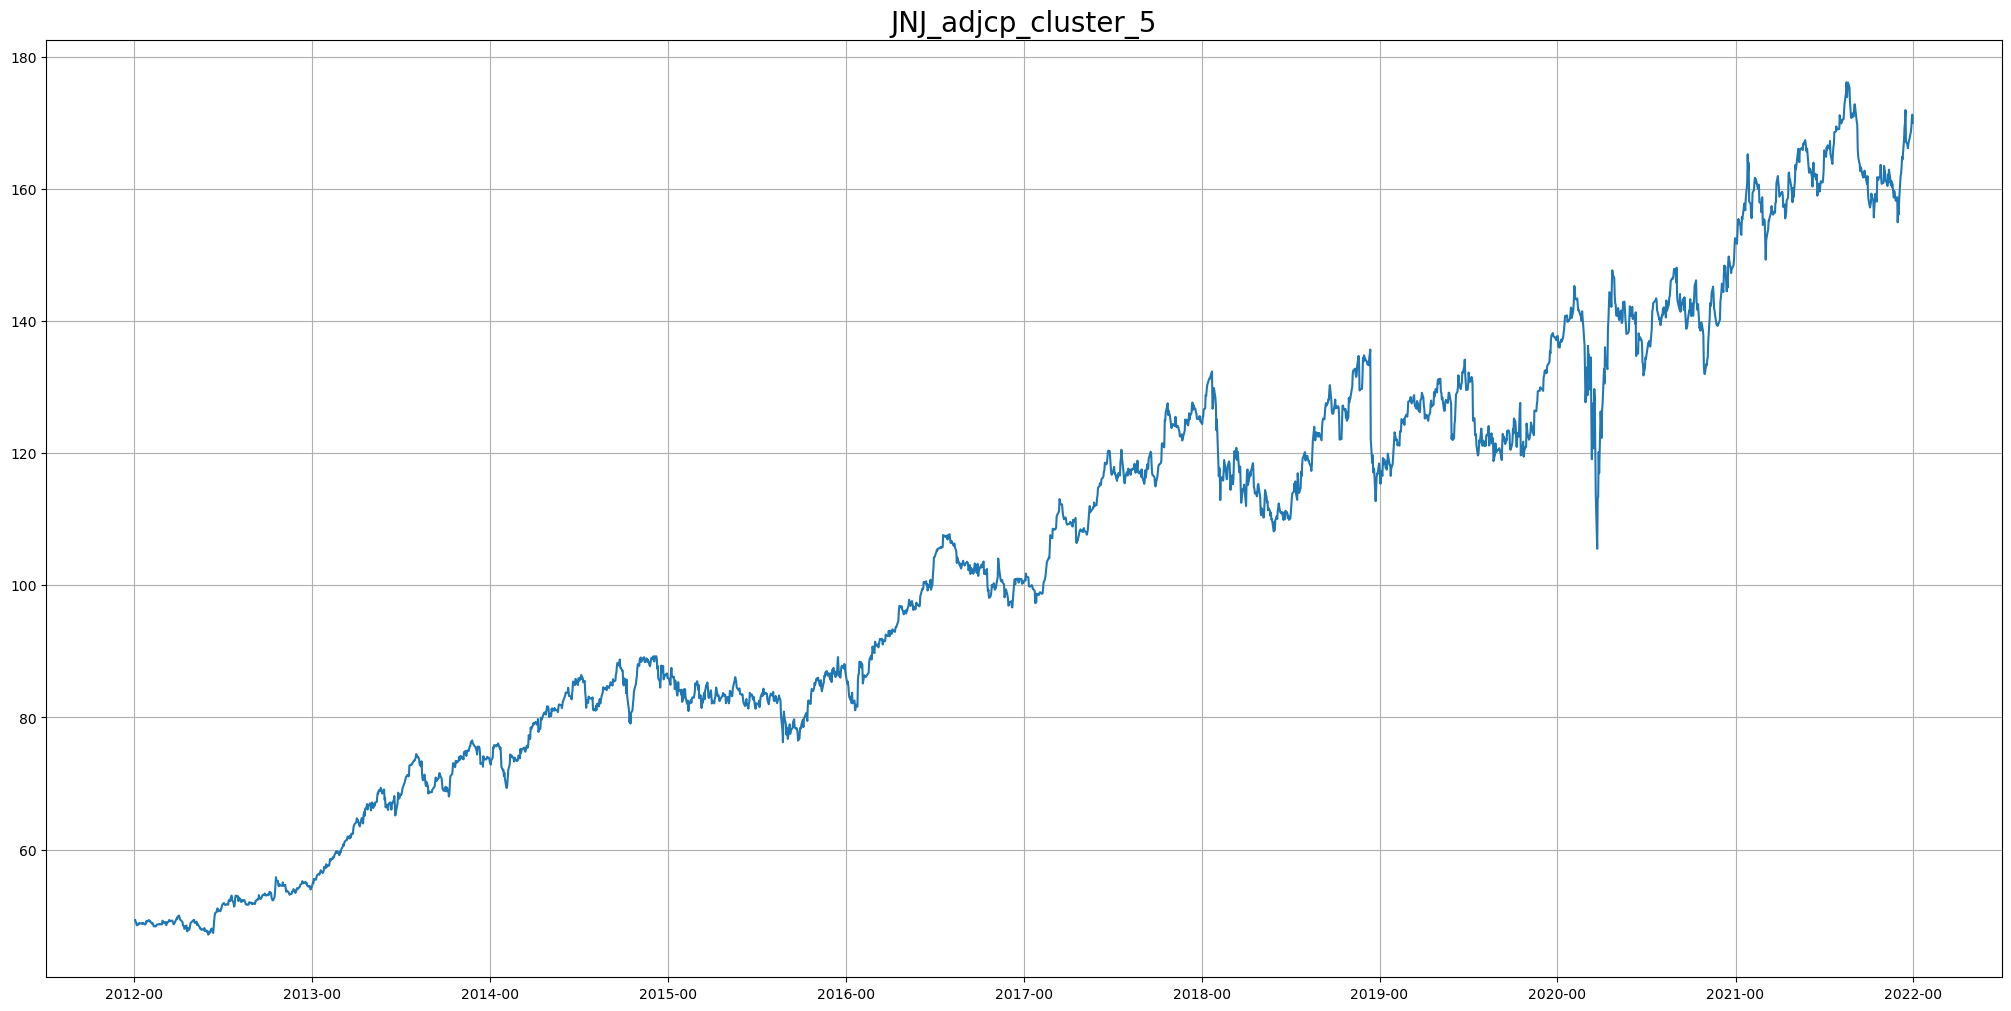

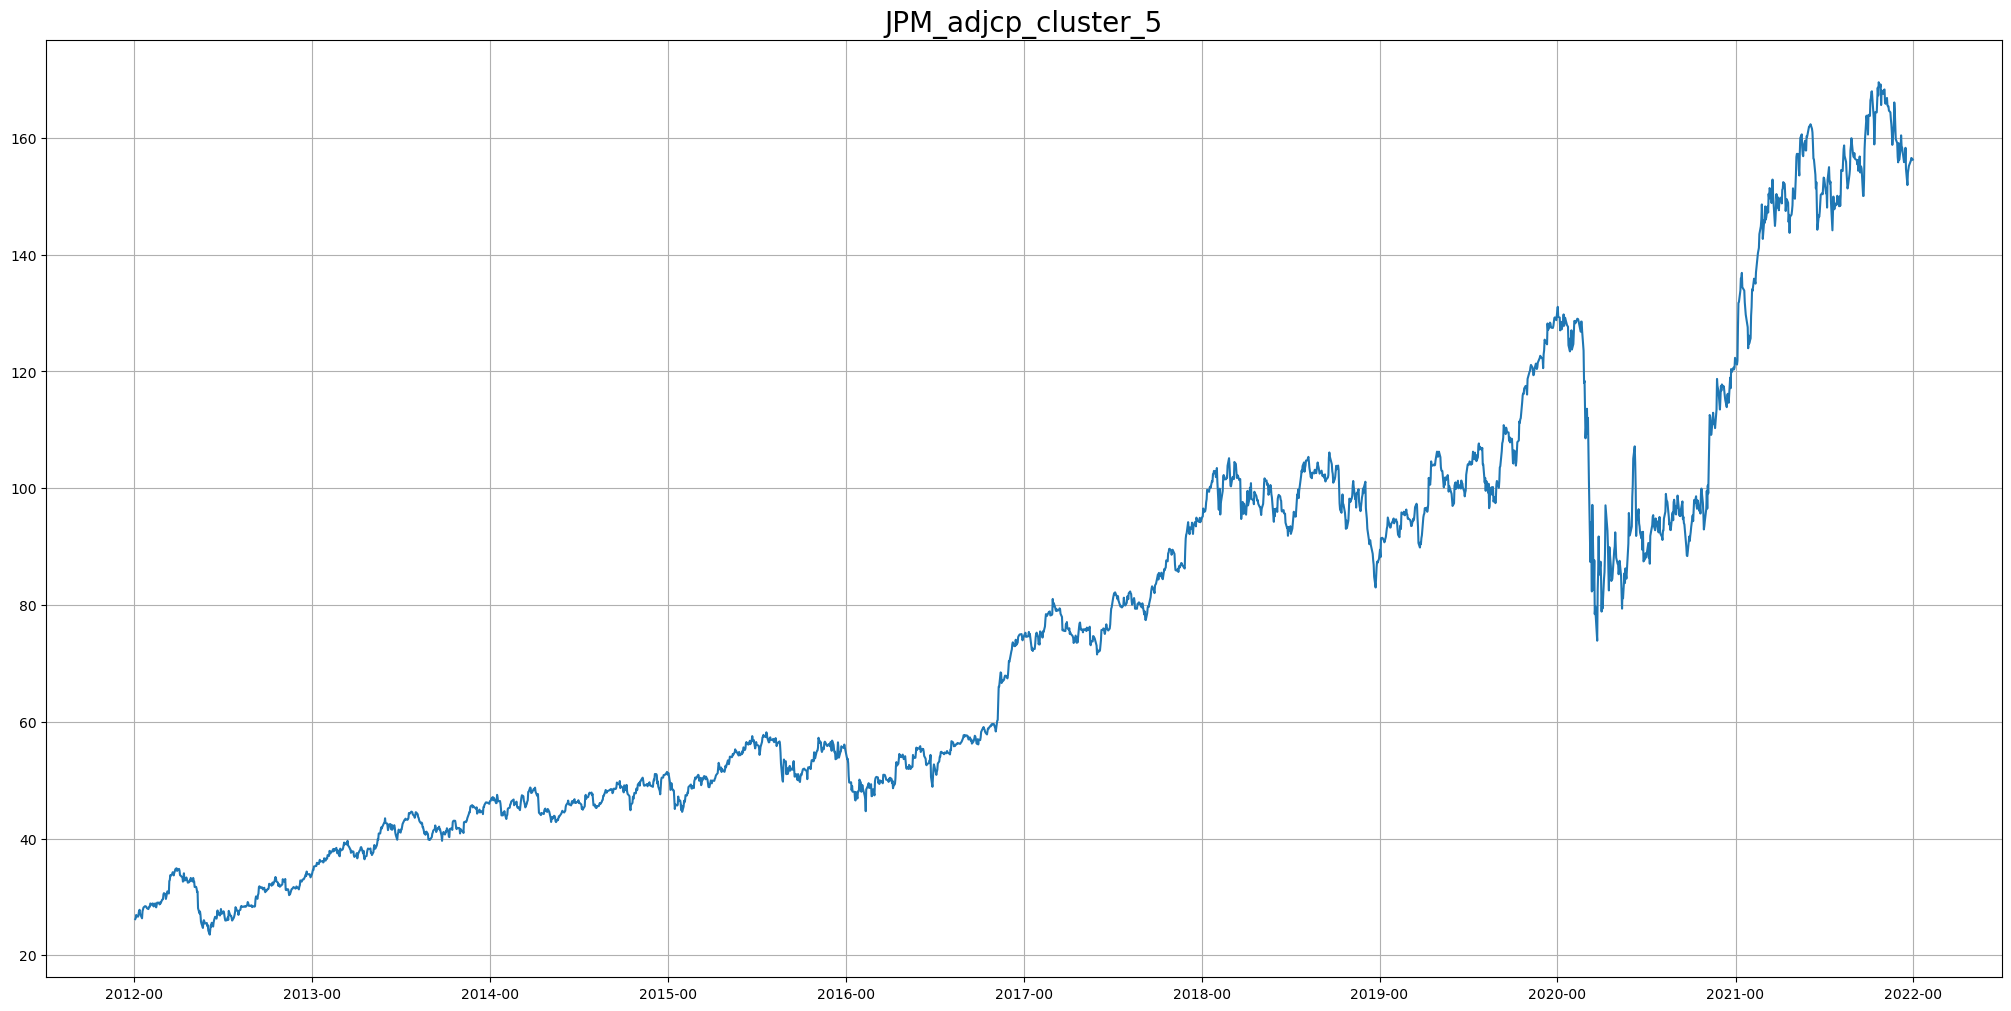

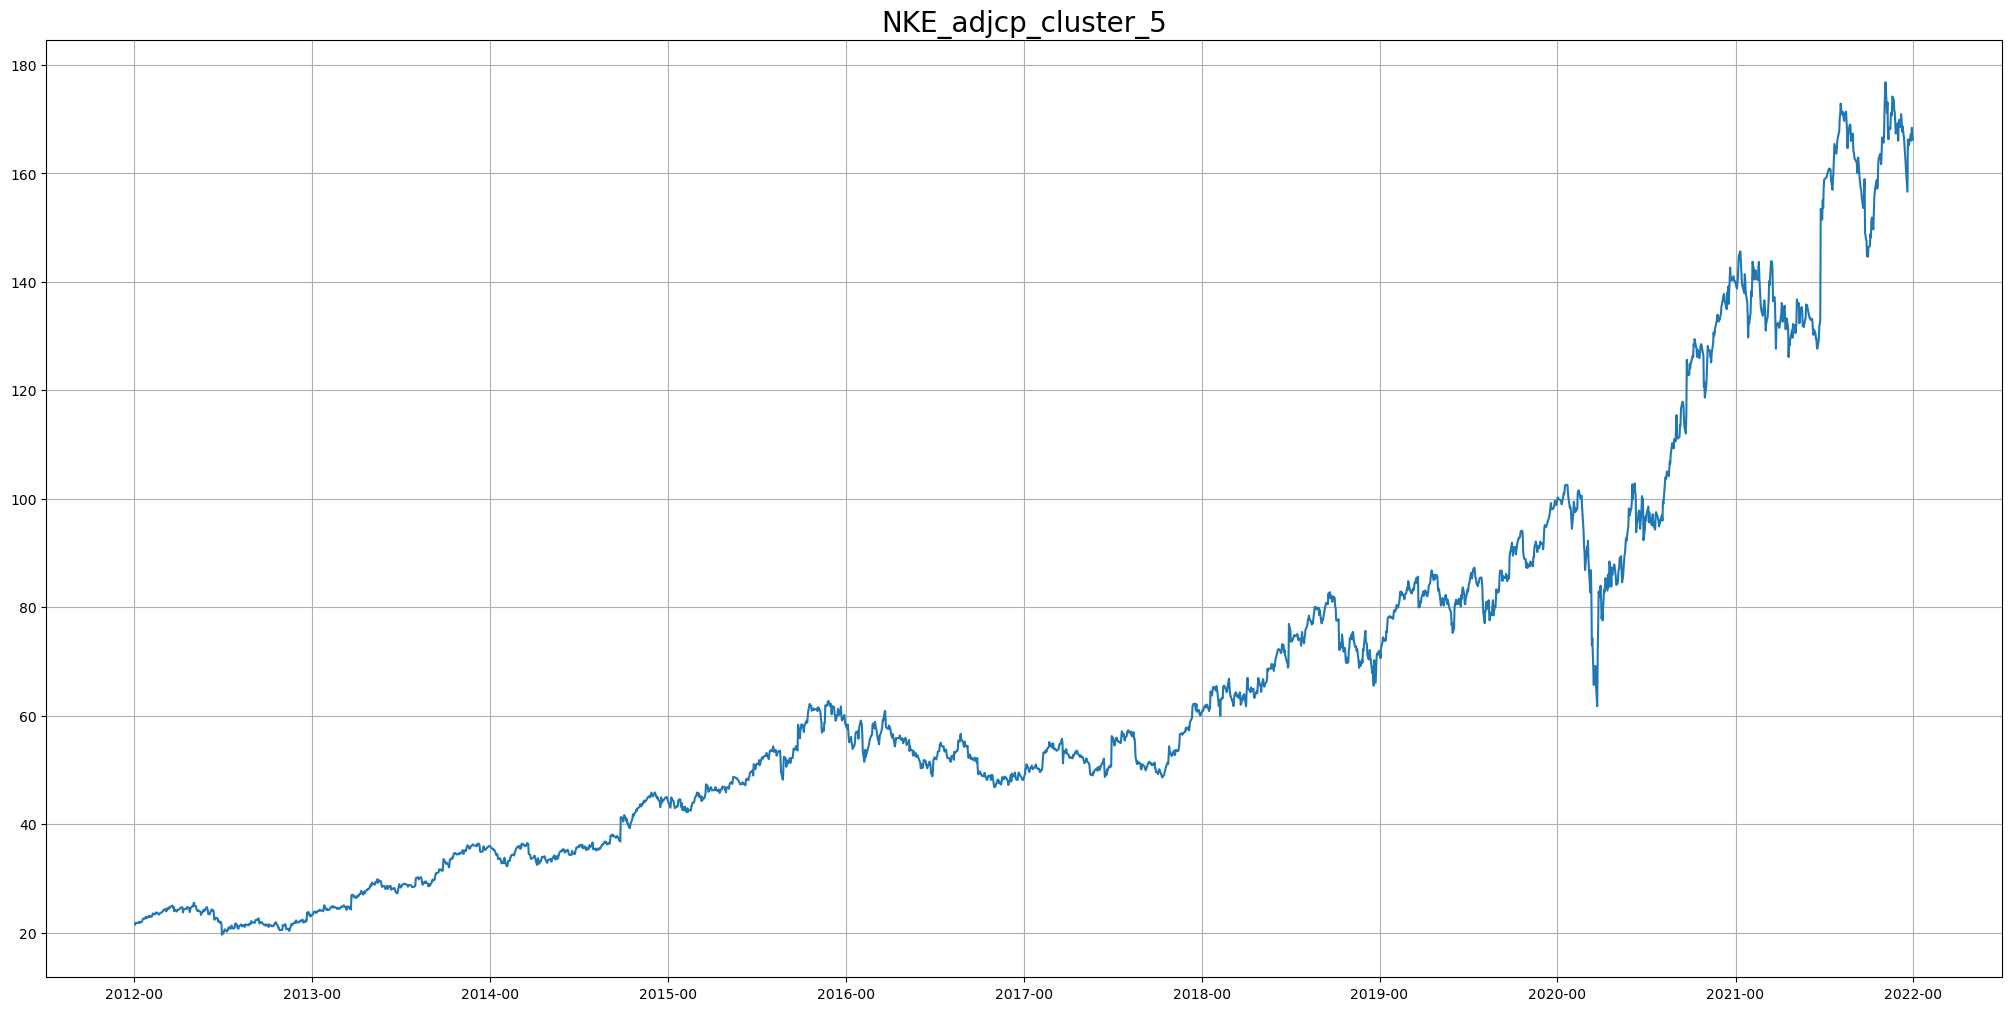

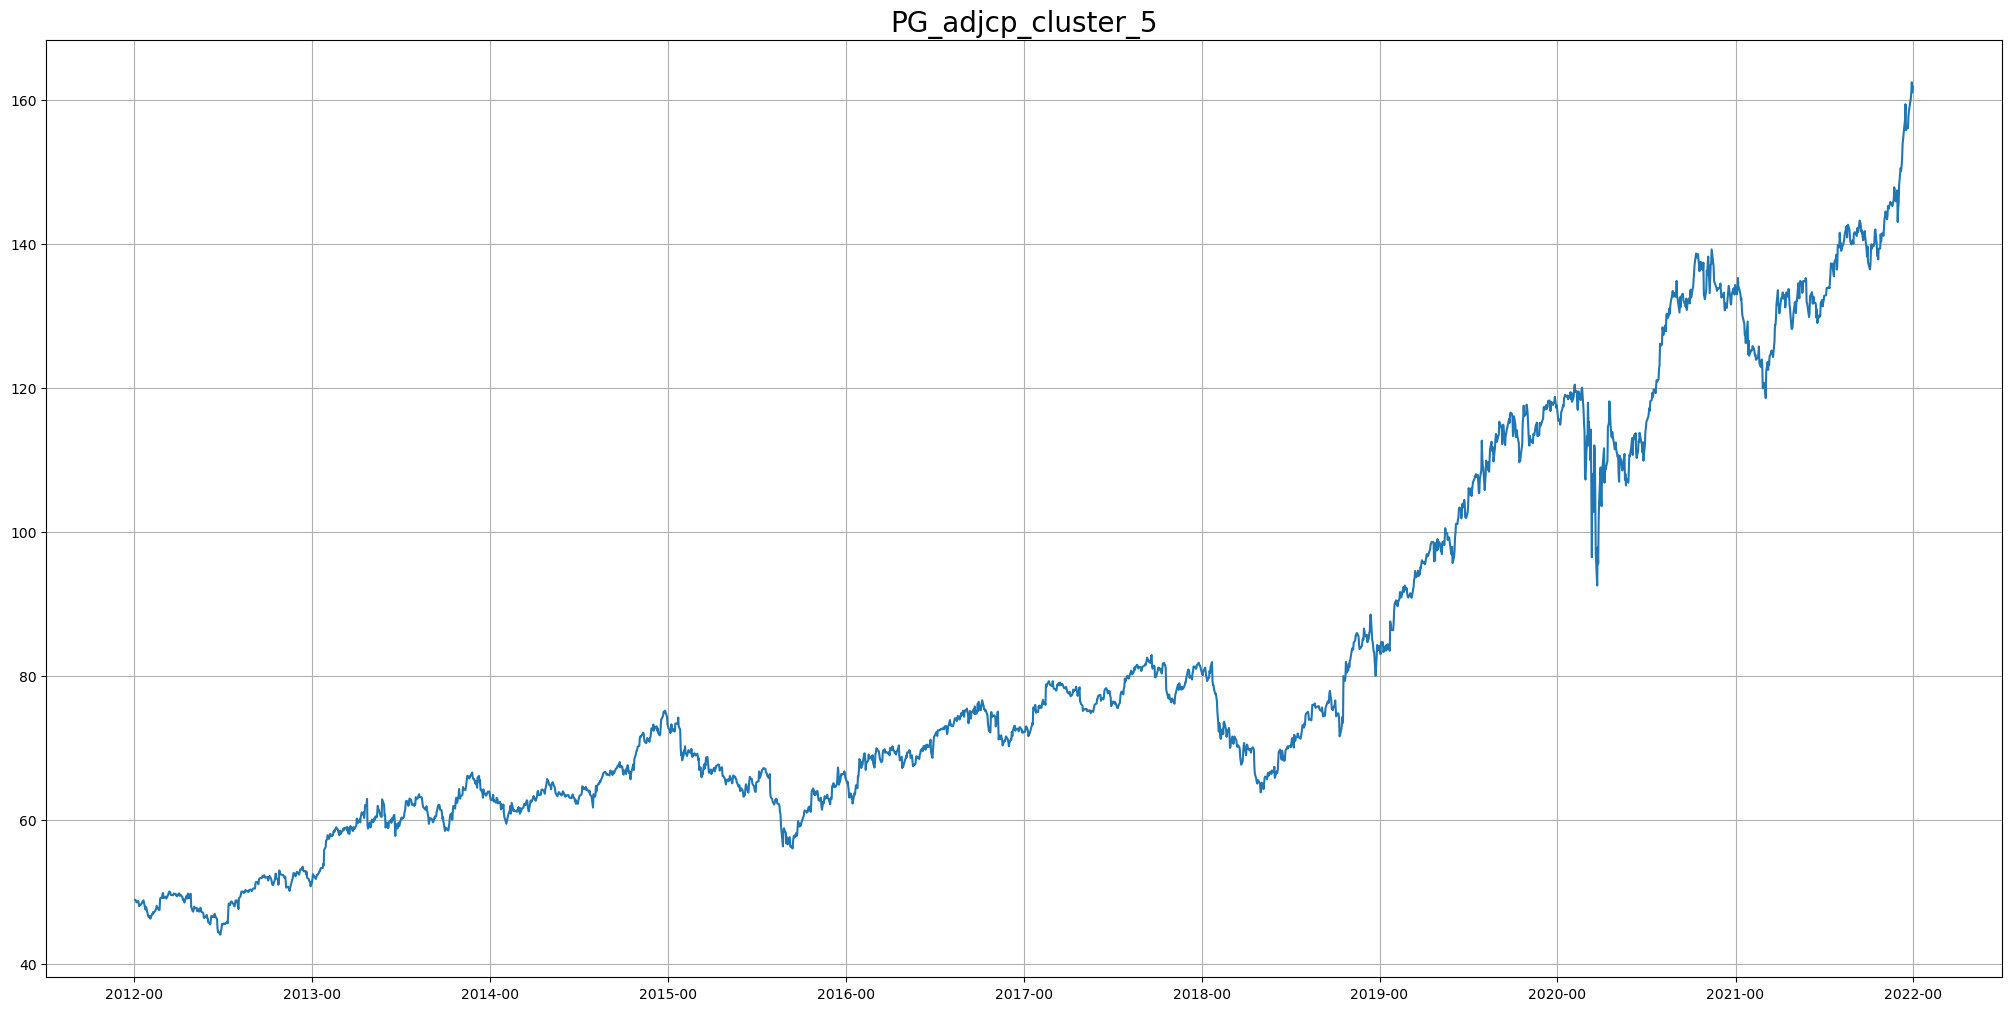

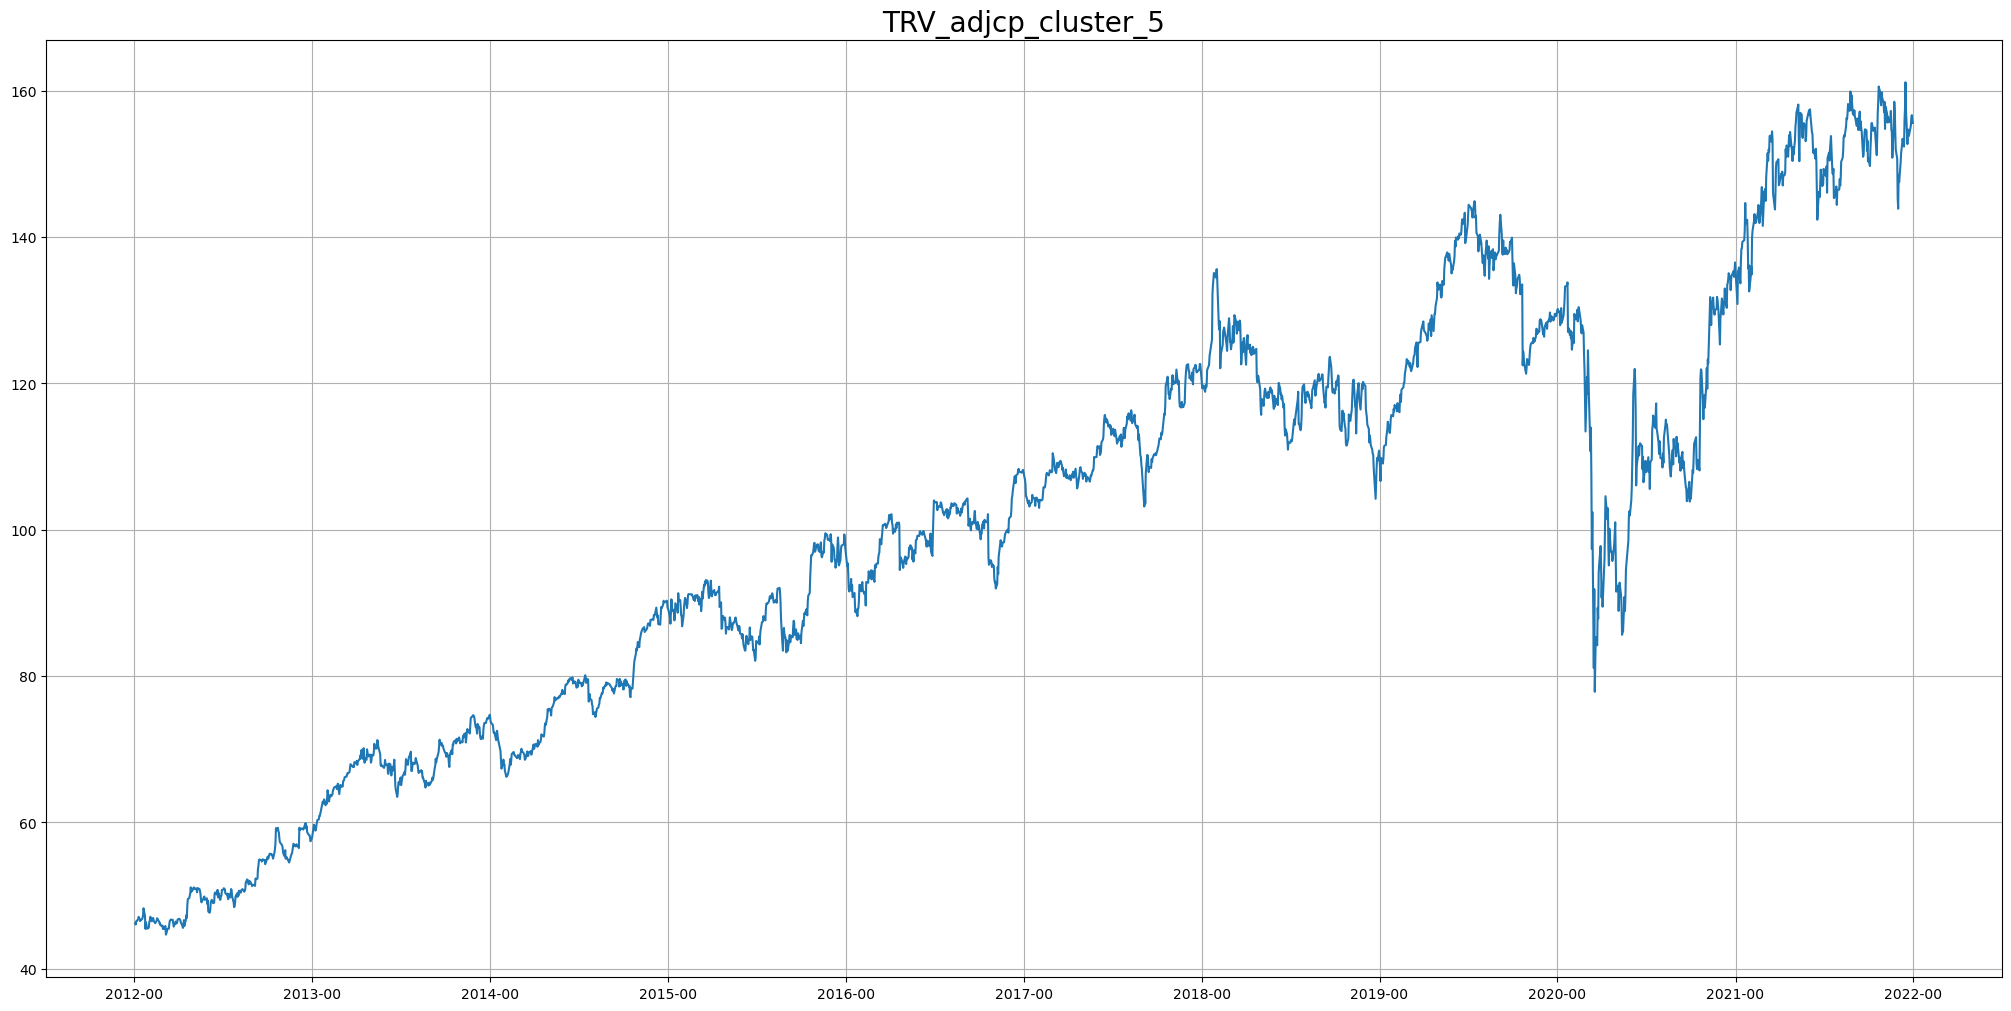

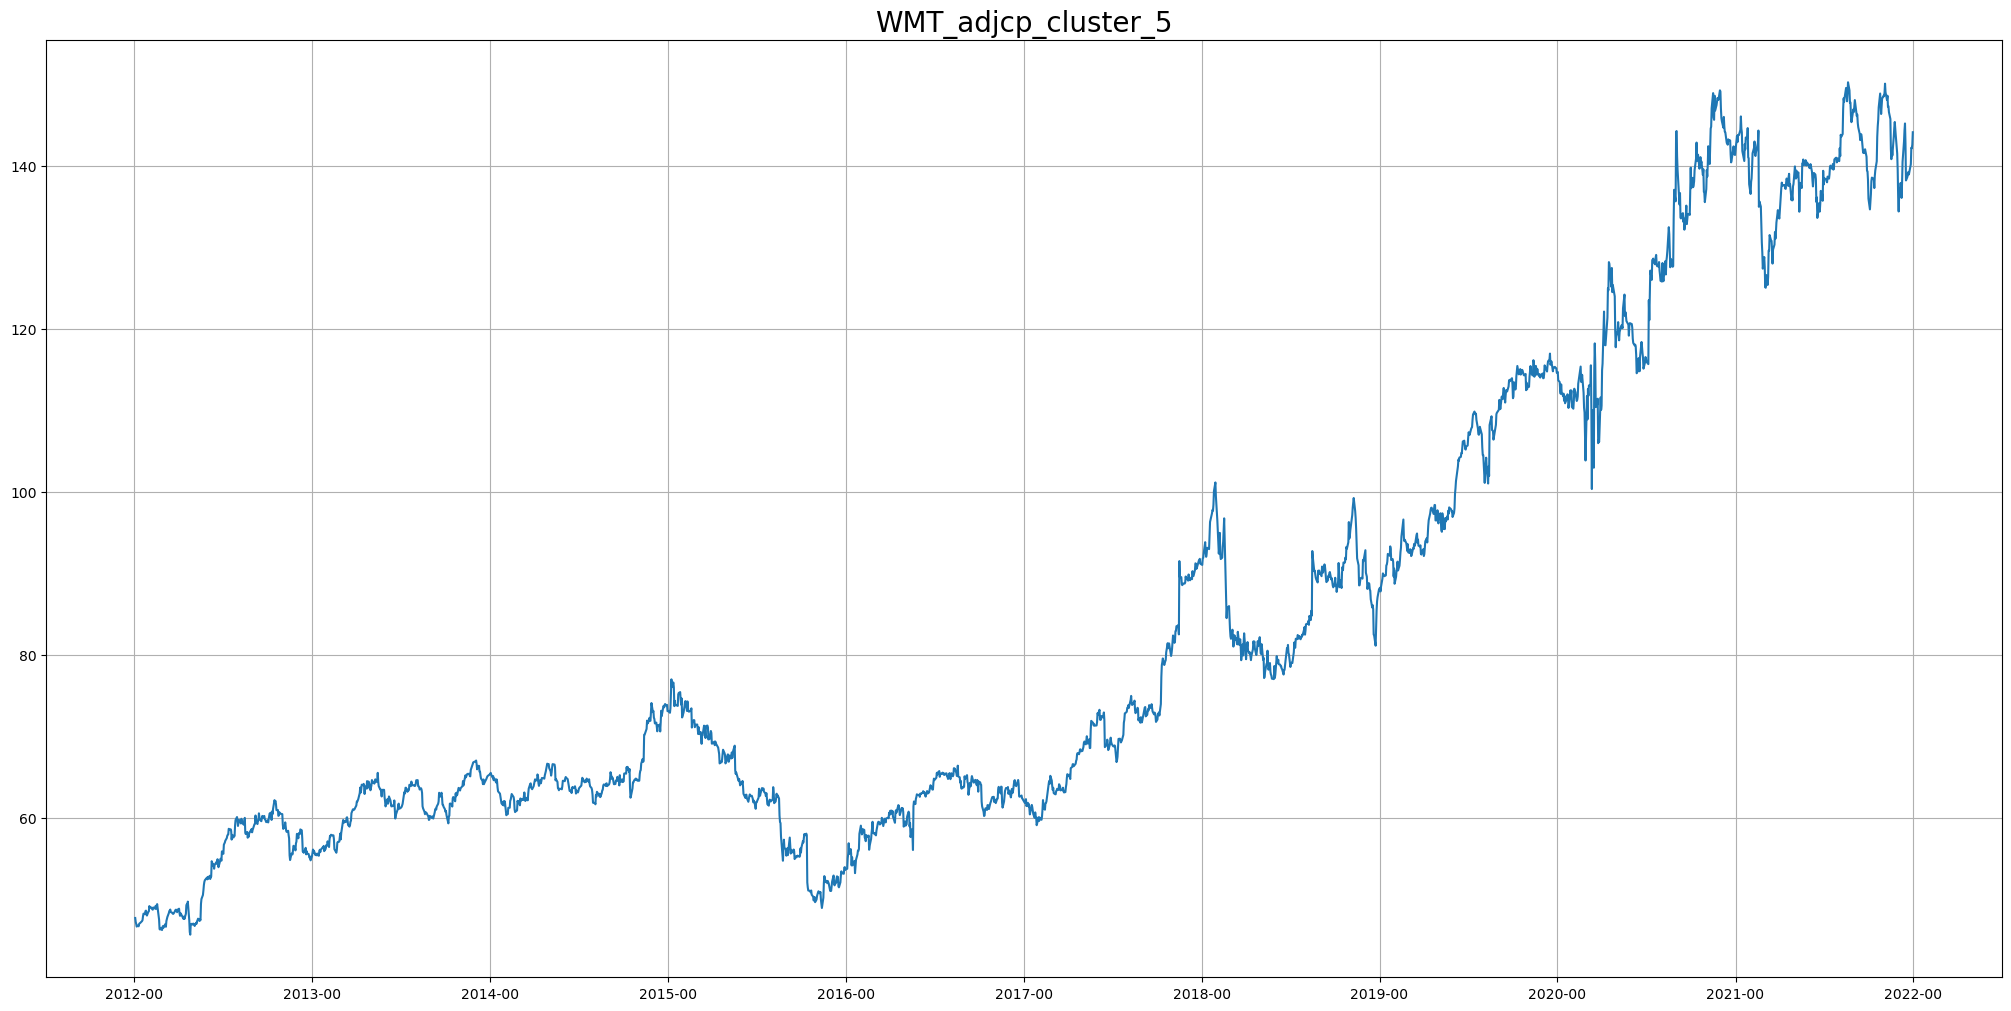

In [297]:
display(label_dict)
for label,tics in enumerate(label_dict):
    print('This is cluster '+str(label))
    for tic in tics:
        plot_ori(data_dict[tic],tic,'_cluster_'+str(label))
    plt.show()